In [46]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('..')

import numpy as np
import random
import torch

from pytorch_pretrained_bert.tokenization import BertTokenizer

from lib import data_processors, tasks
from lib.bert import BertForSequenceClassification
from lib.train_eval import train, evaluate, predict

from lib.train_student import eval_teacher_soft_targets, train_student, train_student_mae_logits

from pytorch_pretrained_bert.modeling import BertConfig
import os
from lib.blend_cnn import BlendCNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %env CUDA_VISIBLE_DEVICES=1

params = {
    'data_dir': '../datasets/SST-2',
    'output_dir': '../output',
    'cache_dir': '../model_cache',
    'task_name': 'sst2',
    'bert_model': 'bert-base-uncased',
    'max_seq_length': 128,
    'train_batch_size': 32,
    'eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_proportion': 0.1,
    'num_train_epochs': 1,
    'seed': 1331,
    'device': torch.device(
        'cuda' if torch.cuda.is_available()
        else 'cpu')
}

random.seed(params['seed'])
np.random.seed(params['seed'])
torch.manual_seed(params['seed'])

In [3]:
params['num_labels'] = tasks.num_labels[params['task_name']]
params['label_list'] = tasks.label_lists[params['task_name']]

processor = tasks.processors[params['task_name']]()
tokenizer = BertTokenizer.from_pretrained(
    params['bert_model'], do_lower_case=True)

train_examples = processor.get_train_examples(params['data_dir'])
dev_examples = processor.get_dev_examples(params['data_dir'])
teacher_model = BertForSequenceClassification.from_pretrained(
                params['bert_model'],
                cache_dir=params['cache_dir'],
                num_labels=params['num_labels']).to(params['device'])

05/13/2019 19:50:38 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/shakhrayv/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
05/13/2019 19:50:39 - INFO - lib.bert -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
05/13/2019 19:50:39 - INFO - lib.bert -   extracting archive file ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpzvx41y_g
05/13/2019 19:50:41 - INFO - lib.bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hid

In [10]:
EPOCH_NUM = 2

params['num_train_epochs'] = 2
checkpoint_files = {
    'config': 'bert_config.json',
    'model_weigths': 'model_{}_epoch_{}_part.pth'.format(
        params['task_name'], EPOCH_NUM)
}

teacher_model, result = train(teacher_model, tokenizer, params,
                              train_examples[:33674],
                              valid_examples=dev_examples,
                              checkpoint_files=checkpoint_files)
result

Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

***** Running training *****
Num examples: 33674
Batch size:   32
Num steps:    2104

Epoch: 1


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.24524392537128778, 'train_global_step': 1053}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   0%|          | 0/1053 [00:00<?, ?it/s]

{'eval_loss': 0.21664104319095864, 'eval_accuracy': 0.9151376146788991, 'eval_f1_score': 0.9160997732426305, 'eval_matthews_corrcoef': 0.8303395837461052}

Epoch: 2


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.09003617818638017, 'train_global_step': 2106}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 35.68it/s]


{'eval_loss': 0.25341028649540304, 'eval_accuracy': 0.9231651376146789, 'eval_f1_score': 0.9251396648044693, 'eval_matthews_corrcoef': 0.8463424318134275}


{'train_loss': 0.09003617818638017, 'train_global_step': 2106}

In [ ]:
# # Load a trained model and config that you have fine-tuned
# config = BertConfig(os.path.join(params['output_dir'], checkpoint_files['config']))
# teacher_model = BertForSequenceClassification(config, num_labels=params['num_labels'])

# teacher_model.load_state_dict(torch.load(os.path.join(params['output_dir'], checkpoint_files['model_weigths'])))
# teacher_model.to(params['device'])

## Дистилляция
Минимизируем mae между логитами, которые были получены от учителя и студента. При этом смотрим как на примеры, на которых обучался учитель, так и на новые примеры.

In [11]:
model = BlendCNN(params['max_seq_length'], len(tokenizer.vocab), len(params['label_list']), n_layers=8).to(params['device'])

In [14]:
all_count_student, all_count_teacher

(4710398, 109483778)

Во сколько раз сжимаем.

In [15]:
all_count_student = 0
for p in model.named_parameters():
    cur_count = 1
    for sh in p[1].size():
        cur_count *= sh
        
    all_count_student += cur_count

all_count_teacher = 0
for p in teacher_model.named_parameters():
    cur_count = 1
    for sh in p[1].size():
        cur_count *= sh
        
    all_count_teacher += cur_count
    
print('Compression in {} '.format(all_count_teacher / all_count_student))

Compression in 23.24299942382788 


Обучаем студента

In [13]:
# compute soft logits from teacher
all_logits_teacher = eval_teacher_soft_targets(teacher_model, tokenizer, params, train_examples)

Evaluating: 100%|██████████| 2105/2105 [03:16<00:00, 10.72it/s]


In [18]:
model, result = train_student_mae_logits(model, teacher_model, tokenizer, params, 
                                         train_examples, valid_examples=dev_examples, 
                                         name='BlendCNN8_mae_logits', 
                                         all_logits_teacher=all_logits_teacher)


Iteration:   0%|          | 10/2105 [00:00<00:21, 98.36it/s]

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    4208

Epoch: 1


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 2.6607068064093875, 'train_global_step': 2105}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   1%|          | 11/2105 [00:00<00:19, 108.37it/s]

{'eval_loss': 0.8634830663461823, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.47268106734434556, 'eval_matthews_corrcoef': 0.053314694991917745}

Epoch: 2


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 2.58055724520015, 'train_global_step': 4210}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 644.93it/s]


{'eval_loss': 0.8484831458225834, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.5483091787439613, 'eval_matthews_corrcoef': 0.1454527083553793}


In [35]:
params['num_train_epochs'] = 500
params['train_batch_size'] = 256

model, result = train_student_mae_logits(model, teacher_model, tokenizer, params, 
                                         train_examples, valid_examples=dev_examples, 
                                         name='BlendCNN8_mae_logits', 
                                         all_logits_teacher=all_logits_teacher)

Iteration:   0%|          | 0/264 [00:00<?, ?it/s]

***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    26300

Epoch: 1


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7701732841405001, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.64it/s]

{'eval_loss': 2.001117482977527, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6538871139510116, 'eval_matthews_corrcoef': 0.25448747655044635}

Epoch: 2


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.767922978283781, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.81it/s]

{'eval_loss': 1.984050547288303, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6508620689655172, 'eval_matthews_corrcoef': 0.25646254065186647}

Epoch: 3


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7734550120252551, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.79it/s]

{'eval_loss': 1.991537968043095, 'eval_accuracy': 0.6295871559633027, 'eval_f1_score': 0.6477644492911668, 'eval_matthews_corrcoef': 0.25859340995784585}

Epoch: 4


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7880070760394587, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.85it/s]

{'eval_loss': 1.9859664172887077, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6509635974304069, 'eval_matthews_corrcoef': 0.2520034278895156}

Epoch: 5


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7992595517725656, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.89it/s]

{'eval_loss': 1.9848409104067513, 'eval_accuracy': 0.625, 'eval_f1_score': 0.648764769065521, 'eval_matthews_corrcoef': 0.24960897574576849}

Epoch: 6


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.801196940017469, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.79it/s]

{'eval_loss': 1.9855867822559357, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6433260393873085, 'eval_matthews_corrcoef': 0.25167135290278697}

Epoch: 7


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8163739767941561, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.85it/s]

{'eval_loss': 1.9759455064418827, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6376811594202898, 'eval_matthews_corrcoef': 0.25410770598532123}

Epoch: 8


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8298617815881064, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.79it/s]

{'eval_loss': 1.9915585029378844, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6567164179104479, 'eval_matthews_corrcoef': 0.26139381082172963}

Epoch: 9


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8291064676913348, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.79it/s]

{'eval_loss': 2.018647865067286, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6487068965517241, 'eval_matthews_corrcoef': 0.25184655370816544}

Epoch: 10


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8364558192816648, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.80it/s]

{'eval_loss': 1.989440996502099, 'eval_accuracy': 0.6238532110091743, 'eval_f1_score': 0.6395604395604395, 'eval_matthews_corrcoef': 0.24707096435195433}

Epoch: 11


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8370473944779598, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.69it/s]

{'eval_loss': 1.977308468187102, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6477024070021883, 'eval_matthews_corrcoef': 0.2608752373068815}

Epoch: 12


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8410382641084266, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.68it/s]

{'eval_loss': 2.0179753194200893, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6524520255863538, 'eval_matthews_corrcoef': 0.25213567097459116}

Epoch: 13


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8311427824876525, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.78it/s]

{'eval_loss': 1.987077119183045, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6457204767063923, 'eval_matthews_corrcoef': 0.24944829226856569}

Epoch: 14


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8197255452925508, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.66it/s]

{'eval_loss': 2.0426248231866806, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.6625641025641027, 'eval_matthews_corrcoef': 0.24739969809129542}

Epoch: 15


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8306242823600769, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.65it/s]

{'eval_loss': 2.040910989309366, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6618407445708375, 'eval_matthews_corrcoef': 0.25143670815692454}

Epoch: 16


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8408853152033055, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.78it/s]

{'eval_loss': 1.9796416161826118, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6509129967776585, 'eval_matthews_corrcoef': 0.2542286172019683}

Epoch: 17


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8070784016992106, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.53it/s]

{'eval_loss': 1.9817475203365016, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6529284164859003, 'eval_matthews_corrcoef': 0.26556705771501343}

Epoch: 18


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.829617356937943, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.57it/s]

{'eval_loss': 1.9549804152978916, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6468646864686468, 'eval_matthews_corrcoef': 0.26316802170570985}

Epoch: 19


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8236170404336669, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.68it/s]

{'eval_loss': 1.9910329784609555, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6516129032258063, 'eval_matthews_corrcoef': 0.2565117402590888}

Epoch: 20


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7940715056928721, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.49it/s]

{'eval_loss': 2.0232888962178017, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6575916230366492, 'eval_matthews_corrcoef': 0.2506210848349034}

Epoch: 21


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8001766297401804, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.40it/s]

{'eval_loss': 1.9757353193260123, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.6525871172122493, 'eval_matthews_corrcoef': 0.24555064844256413}

Epoch: 22


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8013665784489025, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.44it/s]

{'eval_loss': 1.992594491947292, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6581740976645435, 'eval_matthews_corrcoef': 0.26156032719886}

Epoch: 23


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8005443653374007, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.41it/s]

{'eval_loss': 1.9560009410886594, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.644880174291939, 'eval_matthews_corrcoef': 0.25169437548720897}

Epoch: 24


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7985719431078795, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.9429119867515985, 'eval_accuracy': 0.6341743119266054, 'eval_f1_score': 0.6459489456159823, 'eval_matthews_corrcoef': 0.26782073162091274}

Epoch: 25


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.781379140236161, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.42it/s]

{'eval_loss': 1.9963205326300149, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6575342465753424, 'eval_matthews_corrcoef': 0.2549384793192369}

Epoch: 26


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.782138966023922, 'train_global_step': 6864}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 1.9447541797123509, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6477024070021883, 'eval_matthews_corrcoef': 0.2608752373068815}

Epoch: 27


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7791126706834995, 'train_global_step': 7128}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.9541726521506837, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6551724137931034, 'eval_matthews_corrcoef': 0.2656945145392685}

Epoch: 28


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7717214700850573, 'train_global_step': 7392}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.35it/s]

{'eval_loss': 2.001630032600237, 'eval_accuracy': 0.625, 'eval_f1_score': 0.653968253968254, 'eval_matthews_corrcoef': 0.25010111637367016}

Epoch: 29


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7716166510274916, 'train_global_step': 7656}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.36it/s]

{'eval_loss': 1.9279667407417362, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6407982261640798, 'eval_matthews_corrcoef': 0.25632450282389135}

Epoch: 30


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.762169688714273, 'train_global_step': 7920}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.43it/s]

{'eval_loss': 1.9692506722381917, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6479481641468683, 'eval_matthews_corrcoef': 0.25180524017505607}

Epoch: 31


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7986284650184892, 'train_global_step': 8184}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.31it/s]

{'eval_loss': 1.9827172432341194, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.647374062165059, 'eval_matthews_corrcoef': 0.2450405273801102}

Epoch: 32


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7862903073881612, 'train_global_step': 8448}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.41it/s]

{'eval_loss': 1.9703621517958567, 'eval_accuracy': 0.6238532110091743, 'eval_f1_score': 0.6495726495726496, 'eval_matthews_corrcoef': 0.2474405216081071}

Epoch: 33


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7547868203484651, 'train_global_step': 8712}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.49it/s]

{'eval_loss': 1.9871743129416921, 'eval_accuracy': 0.6215596330275229, 'eval_f1_score': 0.6496815286624203, 'eval_matthews_corrcoef': 0.2430202032094757}

Epoch: 34


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7611605773369471, 'train_global_step': 8976}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.9990991732752972, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6553911205073996, 'eval_matthews_corrcoef': 0.25246742303211717}

Epoch: 35


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7962374165654182, 'train_global_step': 9240}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.34it/s]

{'eval_loss': 1.9891803460340511, 'eval_accuracy': 0.6215596330275229, 'eval_f1_score': 0.6526315789473685, 'eval_matthews_corrcoef': 0.24337092281047387}

Epoch: 36


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7634684493144354, 'train_global_step': 9504}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.47it/s]

{'eval_loss': 1.937378090174966, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.646354733405876, 'eval_matthews_corrcoef': 0.2540066932472205}

Epoch: 37


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7589778764681383, 'train_global_step': 9768}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.35it/s]

{'eval_loss': 1.95612123010145, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6453038674033149, 'eval_matthews_corrcoef': 0.2631866128333586}

Epoch: 38


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7797163806178353, 'train_global_step': 10032}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.39it/s]

{'eval_loss': 1.9256832578526266, 'eval_accuracy': 0.6295871559633027, 'eval_f1_score': 0.6446644664466447, 'eval_matthews_corrcoef': 0.25856991088324893}

Epoch: 39


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.78186415203593, 'train_global_step': 10296}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.9652182986316193, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.6481283422459893, 'eval_matthews_corrcoef': 0.24509709351931416}

Epoch: 40


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.765063079920682, 'train_global_step': 10560}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.38it/s]

{'eval_loss': 1.952095339219716, 'eval_accuracy': 0.6238532110091743, 'eval_f1_score': 0.6379690949227372, 'eval_matthews_corrcoef': 0.247093497856962}

Epoch: 41


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.748724602162838, 'train_global_step': 10824}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.45it/s]

{'eval_loss': 1.9315586461859287, 'eval_accuracy': 0.6295871559633027, 'eval_f1_score': 0.6415094339622642, 'eval_matthews_corrcoef': 0.2586342129373538}

Epoch: 42


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7240479160664659, 'train_global_step': 11088}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.48it/s]

{'eval_loss': 1.9622331752701556, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.6450916936353829, 'eval_matthews_corrcoef': 0.2449029840096435}

Epoch: 43


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.757286196518125, 'train_global_step': 11352}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.38it/s]

{'eval_loss': 1.9374159066303054, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6434023991275899, 'eval_matthews_corrcoef': 0.24938433320038275}

Epoch: 44


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7475643544034525, 'train_global_step': 11616}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.51it/s]

{'eval_loss': 1.9265725577841946, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6477024070021883, 'eval_matthews_corrcoef': 0.2608752373068815}

Epoch: 45


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7698054622971651, 'train_global_step': 11880}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.47it/s]

{'eval_loss': 1.896128898565863, 'eval_accuracy': 0.6295871559633027, 'eval_f1_score': 0.6333711691259931, 'eval_matthews_corrcoef': 0.25917654192694334}

Epoch: 46


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7376273172822866, 'train_global_step': 12144}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.35it/s]

{'eval_loss': 1.974970897381671, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6575342465753424, 'eval_matthews_corrcoef': 0.2549384793192369}

Epoch: 47


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7321285334500399, 'train_global_step': 12408}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.53it/s]

{'eval_loss': 1.9438161039410544, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.6450916936353829, 'eval_matthews_corrcoef': 0.2449029840096435}

Epoch: 48


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7175894486858989, 'train_global_step': 12672}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.33it/s]

{'eval_loss': 1.9105533515651194, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.64, 'eval_matthews_corrcoef': 0.2563520154102458}

Epoch: 49


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.8026890407005945, 'train_global_step': 12936}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.899489194582085, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6338672768878719, 'eval_matthews_corrcoef': 0.26637761456363995}

Epoch: 50


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7364470371694276, 'train_global_step': 13200}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.22it/s]

{'eval_loss': 1.9289621613922938, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6464208242950108, 'eval_matthews_corrcoef': 0.2517389641046935}

Epoch: 51


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.74038362164389, 'train_global_step': 13464}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.02it/s]

{'eval_loss': 1.8830367944493287, 'eval_accuracy': 0.6387614678899083, 'eval_f1_score': 0.6358381502890172, 'eval_matthews_corrcoef': 0.2783658183708218}

Epoch: 52


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7116653790528124, 'train_global_step': 13728}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.12it/s]

{'eval_loss': 1.9181833945398583, 'eval_accuracy': 0.6215596330275229, 'eval_f1_score': 0.6397379912663755, 'eval_matthews_corrcoef': 0.2424728791280298}

Epoch: 53


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7362805075491919, 'train_global_step': 13992}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.34it/s]

{'eval_loss': 1.9109312890735246, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6464864864864865, 'eval_matthews_corrcoef': 0.24948034976327293}

Epoch: 54


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7160090319812298, 'train_global_step': 14256}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.36it/s]

{'eval_loss': 1.8745305663922727, 'eval_accuracy': 0.6364678899082569, 'eval_f1_score': 0.6318234610917538, 'eval_matthews_corrcoef': 0.27404179885570995}

Epoch: 55


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7305349280888384, 'train_global_step': 14520}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.45it/s]

{'eval_loss': 1.937269388730216, 'eval_accuracy': 0.6227064220183486, 'eval_f1_score': 0.6427795874049946, 'eval_matthews_corrcoef': 0.24481326503012577}

Epoch: 56


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6967839780404712, 'train_global_step': 14784}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.45it/s]

{'eval_loss': 1.933742557683935, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6522678185745141, 'eval_matthews_corrcoef': 0.26103259642957993}

Epoch: 57


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7701123788049726, 'train_global_step': 15048}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.886065166988282, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6389201349831272, 'eval_matthews_corrcoef': 0.26348320102561146}

Epoch: 58


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7453470705359271, 'train_global_step': 15312}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.9221584814760317, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.64293659621802, 'eval_matthews_corrcoef': 0.26325623493733624}

Epoch: 59


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7496959188896598, 'train_global_step': 15576}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.8866813913569251, 'eval_accuracy': 0.6353211009174312, 'eval_f1_score': 0.6402714932126697, 'eval_matthews_corrcoef': 0.2705307930817596}

Epoch: 60


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7389232754481562, 'train_global_step': 15840}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.35it/s]

{'eval_loss': 1.8804251807755838, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6338672768878719, 'eval_matthews_corrcoef': 0.26637761456363995}

Epoch: 61


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.701979095285589, 'train_global_step': 16104}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.49it/s]

{'eval_loss': 1.889553356867117, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6376811594202898, 'eval_matthews_corrcoef': 0.25410770598532123}

Epoch: 62


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7194618641427069, 'train_global_step': 16368}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.9005874311488704, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6396396396396397, 'eval_matthews_corrcoef': 0.26580786393870504}

Epoch: 63


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7298934071352987, 'train_global_step': 16632}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.42it/s]

{'eval_loss': 1.8817987558136213, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6444444444444444, 'eval_matthews_corrcoef': 0.2655375412747155}

Epoch: 64


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7250911071896553, 'train_global_step': 16896}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.49it/s]

{'eval_loss': 1.8859137777153507, 'eval_accuracy': 0.6387614678899083, 'eval_f1_score': 0.6432616081540204, 'eval_matthews_corrcoef': 0.27744995936529915}

Epoch: 65


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7306730761898287, 'train_global_step': 17160}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.35it/s]

{'eval_loss': 1.892511331152324, 'eval_accuracy': 0.6353211009174312, 'eval_f1_score': 0.6535947712418301, 'eval_matthews_corrcoef': 0.2701161897750087}

Epoch: 66


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7350107176285802, 'train_global_step': 17424}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.26it/s]

{'eval_loss': 1.9176724019113671, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6441784548422197, 'eval_matthews_corrcoef': 0.249400299508938}

Epoch: 67


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7338714004691803, 'train_global_step': 17688}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.34it/s]

{'eval_loss': 1.884714333085934, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6468646864686468, 'eval_matthews_corrcoef': 0.26316802170570985}

Epoch: 68


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6885916839043299, 'train_global_step': 17952}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.29it/s]

{'eval_loss': 1.9065212796022608, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6432491767288694, 'eval_matthews_corrcoef': 0.25396795993836646}

Epoch: 69


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7011108695331848, 'train_global_step': 18216}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.42it/s]

{'eval_loss': 1.8976548289499138, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6476399560922064, 'eval_matthews_corrcoef': 0.2631670984723141}

Epoch: 70


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7091244835067879, 'train_global_step': 18480}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.8818415569138436, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6438053097345133, 'eval_matthews_corrcoef': 0.2608972949598549}

Epoch: 71


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7345173221194383, 'train_global_step': 18744}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.42it/s]

{'eval_loss': 1.906978298799154, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6471226927252985, 'eval_matthews_corrcoef': 0.25402996337682593}

Epoch: 72


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6860709004104137, 'train_global_step': 19008}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.36it/s]

{'eval_loss': 1.8931077315816907, 'eval_accuracy': 0.6364678899082569, 'eval_f1_score': 0.6385404789053591, 'eval_matthews_corrcoef': 0.2731144749058247}

Epoch: 73


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.725697965897394, 'train_global_step': 19272}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.54it/s]

{'eval_loss': 1.8997463342005285, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6453744493392071, 'eval_matthews_corrcoef': 0.26087186893677183}

Epoch: 74


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6804249361157417, 'train_global_step': 19536}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.886777903357643, 'eval_accuracy': 0.6341743119266054, 'eval_f1_score': 0.6427771556550951, 'eval_matthews_corrcoef': 0.267965764431652}

Epoch: 75


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7004071829671209, 'train_global_step': 19800}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.42it/s]

{'eval_loss': 1.9072225742352327, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.644880174291939, 'eval_matthews_corrcoef': 0.25169437548720897}

Epoch: 76


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6875387035084494, 'train_global_step': 20064}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.47it/s]

{'eval_loss': 1.8945523947453977, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.648471615720524, 'eval_matthews_corrcoef': 0.2608874715857586}

Epoch: 77


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6900811220208803, 'train_global_step': 20328}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.30it/s]

{'eval_loss': 1.9134366624330308, 'eval_accuracy': 0.6295871559633027, 'eval_f1_score': 0.6515641855447681, 'eval_matthews_corrcoef': 0.258747443473928}

Epoch: 78


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6995505371102781, 'train_global_step': 20592}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.29it/s]

{'eval_loss': 1.8904131301680052, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6381059751972943, 'eval_matthews_corrcoef': 0.2635452105430898}

Epoch: 79


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7017064626243982, 'train_global_step': 20856}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.46it/s]

{'eval_loss': 1.8861407075045789, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6421404682274248, 'eval_matthews_corrcoef': 0.2632905455882719}

Epoch: 80


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7146749521295229, 'train_global_step': 21120}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.39it/s]

{'eval_loss': 1.8891173999234174, 'eval_accuracy': 0.6399082568807339, 'eval_f1_score': 0.639908256880734, 'eval_matthews_corrcoef': 0.28024753725688306}

Epoch: 81


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.7131329938543566, 'train_global_step': 21384}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.55it/s]

{'eval_loss': 1.9093162724957855, 'eval_accuracy': 0.6364678899082569, 'eval_f1_score': 0.6565547128927411, 'eval_matthews_corrcoef': 0.27250031758206605}

Epoch: 82


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6835006574789683, 'train_global_step': 21648}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:07, 32.52it/s]

{'eval_loss': 1.9047949962281765, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.65, 'eval_matthews_corrcoef': 0.26092868470444275}

Epoch: 83


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6844717737174395, 'train_global_step': 21912}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.40it/s]

{'eval_loss': 1.8971361729568468, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6397306397306397, 'eval_matthews_corrcoef': 0.2634267293132193}

Epoch: 84


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.690382835427017, 'train_global_step': 22176}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.47it/s]

{'eval_loss': 1.887376213164967, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.64, 'eval_matthews_corrcoef': 0.2563520154102458}

Epoch: 85


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6872720371818903, 'train_global_step': 22440}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.39it/s]

{'eval_loss': 1.8982814205132228, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6383928571428572, 'eval_matthews_corrcoef': 0.2564232489945797}

Epoch: 86


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6925576655476382, 'train_global_step': 22704}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.40it/s]

{'eval_loss': 1.8944374407833033, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6415929203539824, 'eval_matthews_corrcoef': 0.2563023999605619}

Epoch: 87


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6877438196855964, 'train_global_step': 22968}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.44it/s]

{'eval_loss': 1.8977376059526894, 'eval_accuracy': 0.6307339449541285, 'eval_f1_score': 0.6373873873873874, 'eval_matthews_corrcoef': 0.261219163088322}

Epoch: 88


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6808909394524314, 'train_global_step': 23232}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.9041705593990628, 'eval_accuracy': 0.6295871559633027, 'eval_f1_score': 0.6399108138238574, 'eval_matthews_corrcoef': 0.2586991257867966}

Epoch: 89


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6792873890336716, 'train_global_step': 23496}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.32it/s]

{'eval_loss': 1.9158741078848034, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6394707828004409, 'eval_matthews_corrcoef': 0.24938427708152916}

Epoch: 90


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.677811495621096, 'train_global_step': 23760}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.31it/s]

{'eval_loss': 1.9436711614174231, 'eval_accuracy': 0.6330275229357798, 'eval_f1_score': 0.6581196581196581, 'eval_matthews_corrcoef': 0.2659455074436362}

Epoch: 91


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6664690466767008, 'train_global_step': 24024}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.21it/s]

{'eval_loss': 1.9384488609741328, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6501079913606912, 'eval_matthews_corrcoef': 0.256418918302318}

Epoch: 92


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6660303050144152, 'train_global_step': 24288}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.27it/s]

{'eval_loss': 1.9451488668172874, 'eval_accuracy': 0.6318807339449541, 'eval_f1_score': 0.6537216828478964, 'eval_matthews_corrcoef': 0.2633622632953561}

Epoch: 93


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6675138042280169, 'train_global_step': 24552}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.37it/s]

{'eval_loss': 1.9409983968625881, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6487068965517241, 'eval_matthews_corrcoef': 0.25184655370816544}

Epoch: 94


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6625526328430031, 'train_global_step': 24816}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.26it/s]

{'eval_loss': 1.9386502918868738, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.647887323943662, 'eval_matthews_corrcoef': 0.2540586973312658}

Epoch: 95


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6620751587730466, 'train_global_step': 25080}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.24it/s]

{'eval_loss': 1.9396145564542417, 'eval_accuracy': 0.6272935779816514, 'eval_f1_score': 0.6471226927252985, 'eval_matthews_corrcoef': 0.25402996337682593}

Epoch: 96


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.663288293462811, 'train_global_step': 25344}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.32it/s]

{'eval_loss': 1.9446451469798334, 'eval_accuracy': 0.625, 'eval_f1_score': 0.6464864864864865, 'eval_matthews_corrcoef': 0.24948034976327293}

Epoch: 97


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6563922146504576, 'train_global_step': 25608}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.23it/s]

{'eval_loss': 1.9447592224064925, 'eval_accuracy': 0.6261467889908257, 'eval_f1_score': 0.6487068965517241, 'eval_matthews_corrcoef': 0.25184655370816544}

Epoch: 98


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6525273407724771, 'train_global_step': 25872}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.23it/s]

{'eval_loss': 1.9334288725684585, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6508620689655172, 'eval_matthews_corrcoef': 0.25646254065186647}

Epoch: 99


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6459872683115078, 'train_global_step': 26136}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Iteration:   2%|▏         | 4/264 [00:00<00:08, 32.03it/s]

{'eval_loss': 1.9314130968985643, 'eval_accuracy': 0.6341743119266054, 'eval_f1_score': 0.6580921757770631, 'eval_matthews_corrcoef': 0.26815155747826025}

Epoch: 100


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

{'train_loss': 0.6415327499535951, 'train_global_step': 26400}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.01it/s]


{'eval_loss': 1.9107687158320246, 'eval_accuracy': 0.6284403669724771, 'eval_f1_score': 0.6423841059602649, 'eval_matthews_corrcoef': 0.2562857133062483}


Перебираем разные temperature и alpha для дистилляции.

In [50]:
from itertools import product
import pickle


params['num_train_epochs'] = 15
params['train_batch_size'] = 256

Ts = [1, 2, 3, 4, 6, 8, 12, 15, 20]
alphas = np.linspace(0, 1, 6)

different_params = product(Ts, alphas)
all_result_parameters = []
count_experiments = 5
for param in list(different_params):
    cur_result = []
    mean_acc_val = 0
    mean_loss_val = 0
    mean_loss_train = 0
    for i in range(count_experiments):
        model = BlendCNN(params['max_seq_length'], len(tokenizer.vocab), len(params['label_list']), n_layers=8).to(params['device'])


        model, result = train_student(model, teacher_model, tokenizer, params, train_examples, 
                                      valid_examples=dev_examples, name='BlendCNN', 
                                      checkpoint_files=checkpoint_files, 
                                      all_logits_teacher=all_logits_teacher,
                                      temperature=param[0], alpha=param[1])
        
        mean_loss_val += result['eval_loss']
        mean_loss_train += result['train_loss']
        mean_acc_val += result['eval_accuracy']
    
    
    all_result_parameters.append((param, mean_loss_train / count_experiments, mean_loss_val / count_experiments, 
                                   mean_acc_val / count_experiments))
    
    with open('all_result_parameters.pickle', 'wb') as file:
        pickle.dump(all_result_parameters, file)
    print('---------------------------------------------------------------------------------------')
    print('T = {}, alpha = {}, \n train_loss={}, eval_loss={}, eval_accuracy={}'.format(all_result_parameters[-1][0][0], 
                                                                                        all_result_parameters[-1][0][1],
                                                                                        all_result_parameters[-1][1],
                                                                                        all_result_parameters[-1][2],
                                                                                        all_result_parameters[-1][3]))
    

***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]


{'train_loss': 0.6850272496089791, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.50it/s]

{'eval_loss': 0.6964814756920031, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6806635621822241, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.48it/s]

{'eval_loss': 0.6958315900843078, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6783298775553703, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.79it/s]

{'eval_loss': 0.6940963212571559, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.6707597851112818, 'eval_matthews_corrcoef': -0.007207032094474233}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6755353817434022, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.30it/s]

{'eval_loss': 0.6916331862432694, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.6587112171837708, 'eval_matthews_corrcoef': 0.0003770664156204428}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6847012207815142, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 635.99it/s]

{'eval_loss': 0.6971365522012252, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.6707597851112818, 'eval_matthews_corrcoef': -0.007207032094474233}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805428440372149, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 633.06it/s]

{'eval_loss': 0.6965035527534441, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780933498433142, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 627.48it/s]

{'eval_loss': 0.6947696801240838, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6764252696456086, 'eval_matthews_corrcoef': 0.06719969197773512}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749995890440363, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.48it/s]

{'eval_loss': 0.69216991332146, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6693227091633466, 'eval_matthews_corrcoef': 0.06349066808384456}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6703971547610832, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 633.07it/s]

{'eval_loss': 0.68930379014223, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6622734761120262, 'eval_matthews_corrcoef': 0.0709185137723626}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6637876485333298, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.43it/s]

{'eval_loss': 0.6865101597109519, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6521008403361345, 'eval_matthews_corrcoef': 0.053213728820490795}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6557831272031321, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.01it/s]

{'eval_loss': 0.6840364247423794, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6480836236933798, 'eval_matthews_corrcoef': 0.0787629555452307}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6478413566946983, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.76it/s]

{'eval_loss': 0.68181249002046, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6398570151921359, 'eval_matthews_corrcoef': 0.07848325327065064}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."



{'train_loss': 0.6409718676498442, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.65it/s]

{'eval_loss': 0.6797310995501936, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6396313364055299, 'eval_matthews_corrcoef': 0.1071868018814302}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6353054276921533, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.36it/s]

{'eval_loss': 0.6770732333849466, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6287367405978787, 'eval_matthews_corrcoef': 0.11832122735313427}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6306744491060575, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.64it/s]

{'eval_loss': 0.6758733118687748, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6158415841584158, 'eval_matthews_corrcoef': 0.10962479971042852}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6269643250288386, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.24it/s]

{'eval_loss': 0.6768948854109563, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.625, 'eval_matthews_corrcoef': 0.1199564141451766}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6242254697012178, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 631.38it/s]

{'eval_loss': 0.6763584256906985, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6242544731610338, 'eval_matthews_corrcoef': 0.13344008444775526}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6224254392313234, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.12it/s]

{'eval_loss': 0.6745644115817246, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.611740473738414, 'eval_matthews_corrcoef': 0.13447522861824138}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6213490662701202, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.37it/s]


{'eval_loss': 0.6736660587319404, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.5957446808510638, 'eval_matthews_corrcoef': 0.12714621782994778}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6847090287642046, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 634.07it/s]

{'eval_loss': 0.6971719236959011, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6717791411042945, 'eval_matthews_corrcoef': 0.0021677940245231897}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805440776727416, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 633.23it/s]

{'eval_loss': 0.696566433056232, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6757990867579908, 'eval_matthews_corrcoef': 0.04883430058835938}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780856102705002, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 633.42it/s]

{'eval_loss': 0.6948142073570042, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6774441878367974, 'eval_matthews_corrcoef': 0.077251184274487}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749363988637924, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.67it/s]

{'eval_loss': 0.692263053337095, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6677341873498799, 'eval_matthews_corrcoef': 0.06128060976565712}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6702621696573315, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 632.62it/s]

{'eval_loss': 0.6893171690267708, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6611706512778237, 'eval_matthews_corrcoef': 0.06713070159973782}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.5705432417717847, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 634.17it/s]

{'eval_loss': 0.6788508996640871, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6339202965708991, 'eval_matthews_corrcoef': 0.09629121984140451}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5655629260070396, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 629.22it/s]

{'eval_loss': 0.6763919504923285, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6290630975143403, 'eval_matthews_corrcoef': 0.11152251993750417}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5615098821845922, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.26it/s]

{'eval_loss': 0.6748323012485143, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6194690265486725, 'eval_matthews_corrcoef': 0.11232711920656654}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5582791207866236, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.21it/s]

{'eval_loss': 0.6755209435717365, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6241413150147203, 'eval_matthews_corrcoef': 0.12210071144045127}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5558744838291948, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.33it/s]

{'eval_loss': 0.6750853366449202, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6264822134387351, 'eval_matthews_corrcoef': 0.13377191095970417}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5542934367602522, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.25it/s]

{'eval_loss': 0.6731660658271488, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6168032786885245, 'eval_matthews_corrcoef': 0.14166162702475438}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5533662433877136, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.54it/s]


{'eval_loss': 0.6723153421809094, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6084210526315789, 'eval_matthews_corrcoef': 0.1457581591319782}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.609488189897754, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.54it/s]

{'eval_loss': 0.6970438119536693, 'eval_accuracy': 0.5068807339449541, 'eval_f1_score': 0.6692307692307692, 'eval_matthews_corrcoef': -0.014583531106286041}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.605670182090817, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.62it/s]

{'eval_loss': 0.6964671242674556, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6034503635583501, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.85it/s]

{'eval_loss': 0.6944960565947065, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6718146718146717, 'eval_matthews_corrcoef': 0.02532786370656124}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6005500769524863, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.84it/s]

{'eval_loss': 0.6917112067410158, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6704, 'eval_matthews_corrcoef': 0.07463455833447315}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5961786490498167, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.58it/s]

{'eval_loss': 0.6888487937116842, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6573311367380561, 'eval_matthews_corrcoef': 0.049505444516995505}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5900842678366285, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.27it/s]

{'eval_loss': 0.6860528086576987, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6502546689303905, 'eval_matthews_corrcoef': 0.05823853182980432}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.582954639286706, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.58it/s]

{'eval_loss': 0.6833373737957226, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6379613356766256, 'eval_matthews_corrcoef': 0.054824689422909044}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5760269140203794, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.98it/s]

{'eval_loss': 0.6811045622196766, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6372637263726372, 'eval_matthews_corrcoef': 0.07779368059772718}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5700527775016698, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.65it/s]

{'eval_loss': 0.6788810466270928, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6423220973782772, 'eval_matthews_corrcoef': 0.12852277242827168}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5651266665169687, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.66it/s]

{'eval_loss': 0.6762877794649076, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6280193236714976, 'eval_matthews_corrcoef': 0.11818879209884649}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5610948889092966, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.56it/s]

{'eval_loss': 0.6746027468182488, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6256206554121152, 'eval_matthews_corrcoef': 0.13589102860147725}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5578667279897314, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.48it/s]

{'eval_loss': 0.6752836979378801, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6266009852216748, 'eval_matthews_corrcoef': 0.1315379442281828}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.5554734520388372, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.19it/s]

{'eval_loss': 0.6748390503552392, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6281156530408774, 'eval_matthews_corrcoef': 0.14524197202780273}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.45901902336062805, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.45it/s]

{'eval_loss': 0.6968254344110641, 'eval_accuracy': 0.5011467889908257, 'eval_f1_score': 0.6528332003192339, 'eval_matthews_corrcoef': -0.0258905644386698}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4559054293415763, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.87it/s]

{'eval_loss': 0.6962373277531304, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.45415850898081606, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.30it/s]

{'eval_loss': 0.6945271287626082, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.674884437596302, 'eval_matthews_corrcoef': 0.0510658452253714}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4518725997345014, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.68it/s]

{'eval_loss': 0.6917771108175089, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.671451355661882, 'eval_matthews_corrcoef': 0.07648656186662987}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4484649699068431, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 629.77it/s]

{'eval_loss': 0.6889181888636646, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6644951140065146, 'eval_matthews_corrcoef': 0.06707311605007416}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4438120974510005, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 631.77it/s]

{'eval_loss': 0.6859738454564449, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6593591905564924, 'eval_matthews_corrcoef': 0.0849692675710204}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.43849075055032066, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.01it/s]

{'eval_loss': 0.6834685641144393, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6455584872471416, 'eval_matthews_corrcoef': 0.08032061288589902}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4333651783791455, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.57it/s]

{'eval_loss': 0.6816811642583904, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.6438848920863308, 'eval_matthews_corrcoef': 0.09684166664014984}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4289040758528493, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.80it/s]

{'eval_loss': 0.6801224571199865, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.643720930232558, 'eval_matthews_corrcoef': 0.12675654595582098}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4251992168525855, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.13it/s]

{'eval_loss': 0.6779908363903882, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.634377967711301, 'eval_matthews_corrcoef': 0.11952199295701327}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.42220664543635916, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.28it/s]

{'eval_loss': 0.6760367568360146, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6230468750000001, 'eval_matthews_corrcoef': 0.11509572673185904}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4198058760075858, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.51it/s]

{'eval_loss': 0.6760545433797968, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6187192118226601, 'eval_matthews_corrcoef': 0.11223774443565791}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.41798360194220685, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.76it/s]

{'eval_loss': 0.6762281966250424, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6223984142715561, 'eval_matthews_corrcoef': 0.1263973765468537}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4167905765952486, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.70it/s]

{'eval_loss': 0.6745041629145725, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6080661840744571, 'eval_matthews_corrcoef': 0.12970242423846137}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4161181010757432, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.55it/s]


{'eval_loss': 0.6737241195771125, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6065747613997878, 'eval_matthews_corrcoef': 0.14800921986992704}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.45902204886078835, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.96it/s]

{'eval_loss': 0.696814243092176, 'eval_accuracy': 0.5022935779816514, 'eval_f1_score': 0.658267716535433, 'eval_matthews_corrcoef': -0.026455379622121244}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4559044860529177, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.67it/s]

{'eval_loss': 0.6962616561202828, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.454162765407201, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.81it/s]

{'eval_loss': 0.6944670221605979, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.4518558580541249, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.98it/s]

{'eval_loss': 0.6918641224571871, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6687847498014298, 'eval_matthews_corrcoef': 0.055897851507966306}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.44836748052727093, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.52it/s]

{'eval_loss': 0.689071427073774, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6655817737998372, 'eval_matthews_corrcoef': 0.07117146668770688}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.44359374125346995, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.93it/s]

{'eval_loss': 0.686275634401982, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6554054054054054, 'eval_matthews_corrcoef': 0.07175381521786504}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.3615550012751059, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.85it/s]

{'eval_loss': 0.6818687563095618, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6378378378378379, 'eval_matthews_corrcoef': 0.08041265702706585}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3579117175981854, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.11it/s]

{'eval_loss': 0.6805122873207571, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6372007366482504, 'eval_matthews_corrcoef': 0.09947969734988503}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3548760750528538, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.48it/s]

{'eval_loss': 0.6787070003808091, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6402266288951841, 'eval_matthews_corrcoef': 0.130103966459138}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.35239866161436745, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.35it/s]

{'eval_loss': 0.6767902820533432, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6239067055393587, 'eval_matthews_corrcoef': 0.11293191914199897}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.35042325791084405, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.10it/s]

{'eval_loss': 0.6764503704093465, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6223091976516634, 'eval_matthews_corrcoef': 0.11499089102470575}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."



{'train_loss': 0.3489179607819427, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.17it/s]

{'eval_loss': 0.676634089858912, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6236559139784946, 'eval_matthews_corrcoef': 0.11747117182720258}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3479332218341755, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.36it/s]

{'eval_loss': 0.6748655067004878, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6111111111111113, 'eval_matthews_corrcoef': 0.1321530903221989}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3473779507207148, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.96it/s]


{'eval_loss': 0.6740538509084134, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6061899679829242, 'eval_matthews_corrcoef': 0.15260615168421907}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3837968149419987, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.44it/s]

{'eval_loss': 0.6967435947730454, 'eval_accuracy': 0.49426605504587157, 'eval_f1_score': 0.6358381502890175, 'eval_matthews_corrcoef': -0.03902667577059713}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3810262477984934, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.94it/s]

{'eval_loss': 0.6962121809499526, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.37949242318669957, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.23it/s]

{'eval_loss': 0.694503143668995, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6733590733590733, 'eval_matthews_corrcoef': 0.04029120866057303}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3774555805280353, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.95it/s]

{'eval_loss': 0.6920893347112957, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6703821656050954, 'eval_matthews_corrcoef': 0.06842626150953059}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3744350490019177, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 629.55it/s]

{'eval_loss': 0.6895481477226686, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6612244897959184, 'eval_matthews_corrcoef': 0.05503625477242268}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3703766067822774, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.90it/s]

{'eval_loss': 0.6866936684680094, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6497031382527565, 'eval_matthews_corrcoef': 0.055201209943011656}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.36584340769684676, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.70it/s]

{'eval_loss': 0.6841974088563285, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6455584872471416, 'eval_matthews_corrcoef': 0.08032061288589902}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.36155675091978273, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 629.10it/s]

{'eval_loss': 0.682583503134617, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6377597109304427, 'eval_matthews_corrcoef': 0.08284861010947145}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3578664231480974, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.17it/s]

{'eval_loss': 0.6813572792661026, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6408125577100646, 'eval_matthews_corrcoef': 0.1121719083364598}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.35480730337175453, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 629.60it/s]

{'eval_loss': 0.6795894631757102, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6328871892925431, 'eval_matthews_corrcoef': 0.1214457482421474}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.35233119694572507, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 629.74it/s]

{'eval_loss': 0.6777147555877583, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6236559139784946, 'eval_matthews_corrcoef': 0.11747117182720258}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.3503539346610055, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.45it/s]

{'eval_loss': 0.677423821933089, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6226600985221674, 'eval_matthews_corrcoef': 0.12188784433192036}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.348853352394971, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.73it/s]

{'eval_loss': 0.6776304188603108, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6238894373149062, 'eval_matthews_corrcoef': 0.12660416596506185}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.6479833074139826, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.28it/s]

{'eval_loss': 0.6826702334807007, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6384129846708747, 'eval_matthews_corrcoef': 0.08302367774206085}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6412040360949256, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.34it/s]

{'eval_loss': 0.6807607860740171, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.634011090573013, 'eval_matthews_corrcoef': 0.09394737212625003}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6356175180637476, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.66it/s]

{'eval_loss': 0.6783915158241577, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6195546950629235, 'eval_matthews_corrcoef': 0.09846208086887884}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.631060440883492, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 627.57it/s]

{'eval_loss': 0.6772990227001933, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6152324431256183, 'eval_matthews_corrcoef': 0.1072582714566149}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6274065980405519, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 628.41it/s]

{'eval_loss': 0.6783580668697801, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6177908113391986, 'eval_matthews_corrcoef': 0.10290144939689906}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6246845295483415, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.87it/s]

{'eval_loss': 0.6777385384305765, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6189054726368158, 'eval_matthews_corrcoef': 0.12141559185103652}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6228788736643214, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.05it/s]

{'eval_loss': 0.6760664573708258, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6177685950413223, 'eval_matthews_corrcoef': 0.15080117317074115}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6217896084893834, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.21it/s]


{'eval_loss': 0.675317784344111, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6059322033898304, 'eval_matthews_corrcoef': 0.14569810436321534}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.684698623463963, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.92it/s]

{'eval_loss': 0.6971357544764466, 'eval_accuracy': 0.5068807339449541, 'eval_f1_score': 0.6692307692307692, 'eval_matthews_corrcoef': -0.014583531106286041}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805379268797961, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.46it/s]

{'eval_loss': 0.6964273090824622, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780800984212847, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.85it/s]

{'eval_loss': 0.6945923071935636, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6759474091260634, 'eval_matthews_corrcoef': 0.06743716462638931}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749349390015458, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.92it/s]

{'eval_loss': 0.6919063137963825, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6661329063250601, 'eval_matthews_corrcoef': 0.05266734546590648}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.670247423377904, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.35it/s]

{'eval_loss': 0.6890795977632387, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.657354149548069, 'eval_matthews_corrcoef': 0.0463378291139169}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.6275126934051514, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.09it/s]

{'eval_loss': 0.675988207169629, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6361867704280155, 'eval_matthews_corrcoef': 0.1445808947252872}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6247881436438272, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.31it/s]

{'eval_loss': 0.6753956025825181, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.629812438302073, 'eval_matthews_corrcoef': 0.14105679723424505}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6230027533390305, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.04it/s]

{'eval_loss': 0.6734778016053755, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.609147609147609, 'eval_matthews_corrcoef': 0.13662444767702991}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6219193364183108, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.50it/s]


{'eval_loss': 0.6726277765023325, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6072186836518048, 'eval_matthews_corrcoef': 0.1503195832625541}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6846950964042635, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.36it/s]

{'eval_loss': 0.6971336665366767, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.6702536510376633, 'eval_matthews_corrcoef': -0.006393485323372895}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805349992531718, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.99it/s]

{'eval_loss': 0.6964042295078072, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780804318912101, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.33it/s]

{'eval_loss': 0.6946792455578069, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6749034749034749, 'eval_matthews_corrcoef': 0.05525455361458482}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749050619475769, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.99it/s]

{'eval_loss': 0.691965687883283, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6709367493995196, 'eval_matthews_corrcoef': 0.07850713836515842}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.6581300535436833, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.20it/s]

{'eval_loss': 0.6759632692732122, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6275720164609053, 'eval_matthews_corrcoef': 0.1697019644704418}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6569900018247691, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.22it/s]


{'eval_loss': 0.6746486298090547, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6147368421052631, 'eval_matthews_corrcoef': 0.15970283965747759}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7280690392309969, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.86it/s]

{'eval_loss': 0.6976371877784029, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.671264367816092, 'eval_matthews_corrcoef': -0.008202910178592801}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7233204548106049, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.58it/s]

{'eval_loss': 0.6972022313590444, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6752851711026616, 'eval_matthews_corrcoef': 0.034511236752585224}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7206181170362415, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.48it/s]

{'eval_loss': 0.695221829680948, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.6758832565284176, 'eval_matthews_corrcoef': 0.057098320583789865}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7170085225141409, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 627.30it/s]

{'eval_loss': 0.6921171106124689, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6735504368546464, 'eval_matthews_corrcoef': 0.08374034570919248}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7115190349745028, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.41it/s]

{'eval_loss': 0.6895010997669413, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.661251015434606, 'eval_matthews_corrcoef': 0.04856833784511138}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.703591698498437, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 627.26it/s]

{'eval_loss': 0.6875109195948468, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6521739130434783, 'eval_matthews_corrcoef': 0.047284416573431284}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6944084201346744, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 627.20it/s]

{'eval_loss': 0.6856728576362954, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6429192006950478, 'eval_matthews_corrcoef': 0.058647388528882044}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6857168421600804, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.61it/s]

{'eval_loss': 0.6846114613901858, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6410026857654432, 'eval_matthews_corrcoef': 0.0837700986896162}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6783434452884125, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.50it/s]

{'eval_loss': 0.682656537297122, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6414048059149723, 'eval_matthews_corrcoef': 0.11465569075468532}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6723276956966429, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.92it/s]

{'eval_loss': 0.6793717964971011, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6270373921380634, 'eval_matthews_corrcoef': 0.10884828870274123}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.667460731258898, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 626.75it/s]

{'eval_loss': 0.6778941898427289, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6202158979391561, 'eval_matthews_corrcoef': 0.1124196948577932}
Epoch: 12


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]


{'train_loss': 0.7206617117379651, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.05it/s]

{'eval_loss': 0.6953334874652941, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6753645433614736, 'eval_matthews_corrcoef': 0.049580907541503454}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7171210890466516, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.33it/s]

{'eval_loss': 0.6923084881395922, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6714060031595576, 'eval_matthews_corrcoef': 0.06372771775769663}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7116113451845718, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.51it/s]

{'eval_loss': 0.6892054590541835, 'eval_accuracy': 0.533256880733945, 'eval_f1_score': 0.6693744922826971, 'eval_matthews_corrcoef': 0.08723852648731109}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7036120322617617, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.88it/s]

{'eval_loss': 0.6868104893850897, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6566164154103852, 'eval_matthews_corrcoef': 0.06691778894338349}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6943191253777706, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.98it/s]

{'eval_loss': 0.6845976791660721, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.648695652173913, 'eval_matthews_corrcoef': 0.07901648499170288}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6855439552755067, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.37it/s]

{'eval_loss': 0.6831456031564862, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6434316353887399, 'eval_matthews_corrcoef': 0.08945430117895577}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6782242578990532, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.39it/s]

{'eval_loss': 0.6809344744361049, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6444444444444444, 'eval_matthews_corrcoef': 0.12476932591347893}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6722464669834484, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.52it/s]

{'eval_loss': 0.6774102334411592, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6292352371732817, 'eval_matthews_corrcoef': 0.12295960840758642}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.7927813200336514, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.87it/s]

{'eval_loss': 0.6934304383643176, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6735340729001584, 'eval_matthews_corrcoef': 0.08085633878292443}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7817372618751093, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.08it/s]

{'eval_loss': 0.6949915756907211, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6639477977161501, 'eval_matthews_corrcoef': 0.0665467818556912}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7690717844348965, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.30it/s]

{'eval_loss': 0.6959101966488253, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6540447504302925, 'eval_matthews_corrcoef': 0.0867022204495202}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7577302839719888, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.91it/s]

{'eval_loss': 0.6964316769682486, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6447602131438721, 'eval_matthews_corrcoef': 0.08748325089526363}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7485683503927607, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.58it/s]

{'eval_loss': 0.6938353948542899, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6481994459833796, 'eval_matthews_corrcoef': 0.13290837305331224}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7412351008617517, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.40it/s]

{'eval_loss': 0.6882453248195282, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6335282651072125, 'eval_matthews_corrcoef': 0.1395491358080736}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7353518494602406, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.54it/s]

{'eval_loss': 0.6884588901842132, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6295928500496525, 'eval_matthews_corrcoef': 0.14548281886701783}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7307535455082402, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.59it/s]

{'eval_loss': 0.6928641142691015, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.639921722113503, 'eval_matthews_corrcoef': 0.15866338970656263}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7274029722267931, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.44it/s]

{'eval_loss': 0.6936629607017503, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6378802747791952, 'eval_matthews_corrcoef': 0.15598426947975455}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7252048256270813, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.90it/s]

{'eval_loss': 0.6903871709156201, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6234817813765182, 'eval_matthews_corrcoef': 0.14684425018133918}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7238973950346311, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.89it/s]


{'eval_loss': 0.6879457263703194, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.62148070907195, 'eval_matthews_corrcoef': 0.1668967268787602}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.813918913629922, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.79it/s]

{'eval_loss': 0.6995371510061102, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8075918365608562, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.18it/s]

{'eval_loss': 0.7006846970852909, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.7493306603847127, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.47it/s]

{'eval_loss': 0.6932221722293542, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6493506493506493, 'eval_matthews_corrcoef': 0.13998295639661076}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7420059609593768, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.48it/s]

{'eval_loss': 0.6879024718067857, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.639921722113503, 'eval_matthews_corrcoef': 0.15866338970656263}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.736072401657249, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.58it/s]

{'eval_loss': 0.688721154440502, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6343873517786561, 'eval_matthews_corrcoef': 0.15302729332300263}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7314092471744075, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.51it/s]

{'eval_loss': 0.6932622783287608, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6373411534701857, 'eval_matthews_corrcoef': 0.15146719083124413}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.727970818678538, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.18it/s]

{'eval_loss': 0.6938958855585085, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6332350049164208, 'eval_matthews_corrcoef': 0.1461560483380488}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7257148451877363, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.00it/s]

{'eval_loss': 0.6906848115923413, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6289180990899899, 'eval_matthews_corrcoef': 0.1587361325489538}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7243960829395236, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.36it/s]


{'eval_loss': 0.6883448486882817, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6184074457083765, 'eval_matthews_corrcoef': 0.15311286345355044}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8139411588058327, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.35it/s]

{'eval_loss': 0.6996196255497976, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.7612700037883989, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.22it/s]

{'eval_loss': 0.7030718092734011, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6450980392156863, 'eval_matthews_corrcoef': 0.1730230342789021}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7575047296105009, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.82it/s]

{'eval_loss': 0.7034123258007298, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6391347099311702, 'eval_matthews_corrcoef': 0.16065416082296977}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7550022367275122, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.23it/s]

{'eval_loss': 0.7000201129324631, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6300813008130081, 'eval_matthews_corrcoef': 0.16556710634161745}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7535737892895034, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.78it/s]


{'eval_loss': 0.6968692635258643, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6234309623430963, 'eval_matthews_corrcoef': 0.17380319703993163}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8561027824427142, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.97it/s]

{'eval_loss': 0.7015844127932273, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8487168974948652, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.30it/s]

{'eval_loss': 0.7041457666237967, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8451857481038931, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.48it/s]

{'eval_loss': 0.701108501215867, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8402288100033095, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.91it/s]

{'eval_loss': 0.6967980078327547, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.6743827160493827, 'eval_matthews_corrcoef': 0.04878331367074564}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8317179907903527, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.49it/s]

{'eval_loss': 0.6983216459427132, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6692913385826772, 'eval_matthews_corrcoef': 0.04537897856890548}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.818697581688563, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.39it/s]

{'eval_loss': 0.7038484606464658, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6682926829268294, 'eval_matthews_corrcoef': 0.08300866714446806}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8041661451711799, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.12it/s]

{'eval_loss': 0.7064196232902826, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6581196581196581, 'eval_matthews_corrcoef': 0.09424713396751619}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7916155247525736, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.17it/s]

{'eval_loss': 0.7070105126845317, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6536412078152752, 'eval_matthews_corrcoef': 0.11526784981013465}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7814870727333155, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.05it/s]

{'eval_loss': 0.7026767682309749, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6468952734012974, 'eval_matthews_corrcoef': 0.1323856441789096}
Epoch: 10


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]


{'train_loss': 0.848695527649287, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.15it/s]

{'eval_loss': 0.7039933150651259, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8451500110553972, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.70it/s]

{'eval_loss': 0.7010792031747486, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.840147609286236, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.55it/s]

{'eval_loss': 0.6968083781523442, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6733590733590733, 'eval_matthews_corrcoef': 0.04029120866057303}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8316560026371118, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.14it/s]

{'eval_loss': 0.6982910048319112, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6671911880409126, 'eval_matthews_corrcoef': 0.030203782581804745}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8188384872945872, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.97it/s]

{'eval_loss': 0.7027599742858235, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6677497969130789, 'eval_matthews_corrcoef': 0.07950448875887114}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8045474096681132, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.09it/s]

{'eval_loss': 0.7053366770557717, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.666098807495741, 'eval_matthews_corrcoef': 0.11992693947307419}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.792050465715654, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.86it/s]

{'eval_loss': 0.7063397033302404, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6560283687943264, 'eval_matthews_corrcoef': 0.12118569000909553}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7818809501600988, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.54it/s]

{'eval_loss': 0.7019374870327771, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6414048059149723, 'eval_matthews_corrcoef': 0.11465569075468532}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]


{'train_loss': 0.6749160034638463, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.87it/s]

{'eval_loss': 0.69201180277341, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.671462829736211, 'eval_matthews_corrcoef': 0.07944670508211611}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6701692792050766, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.64it/s]

{'eval_loss': 0.6890128053588058, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6639209225700164, 'eval_matthews_corrcoef': 0.07805620352415164}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6633961507768342, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.16it/s]

{'eval_loss': 0.6863287045799811, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6565656565656566, 'eval_matthews_corrcoef': 0.07243232955583602}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6554076944788297, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.54it/s]

{'eval_loss': 0.6837385783843491, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6444833625218914, 'eval_matthews_corrcoef': 0.07230108575675644}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6475944977366563, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.22it/s]

{'eval_loss': 0.6815732171024205, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6469534050179211, 'eval_matthews_corrcoef': 0.10276989964527976}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6408393209179243, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.04it/s]

{'eval_loss': 0.6794748413761001, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6431881371640409, 'eval_matthews_corrcoef': 0.122072951511051}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6352182491259142, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.97it/s]

{'eval_loss': 0.6767438481126083, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6248794599807136, 'eval_matthews_corrcoef': 0.1084855638400806}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6306380999810768, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.69it/s]

{'eval_loss': 0.6753461572315989, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6135458167330677, 'eval_matthews_corrcoef': 0.10940907464742322}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6269573393193159, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.27it/s]

{'eval_loss': 0.6762837265114036, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6235294117647059, 'eval_matthews_corrcoef': 0.11973389528573393}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.624228343819127, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.76it/s]

{'eval_loss': 0.6757332751390721, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6193806193806194, 'eval_matthews_corrcoef': 0.12602541066739226}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6224316263740713, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.48it/s]

{'eval_loss': 0.6739566698584945, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6086956521739131, 'eval_matthews_corrcoef': 0.1320238714709048}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6213437463297988, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.69it/s]


{'eval_loss': 0.6731752973272029, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6012793176972281, 'eval_matthews_corrcoef': 0.14103799280892998}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.684699442124728, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]


{'train_loss': 0.6473046893423254, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.34it/s]

{'eval_loss': 0.6817891037758064, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6463195691202873, 'eval_matthews_corrcoef': 0.1025121536446418}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6404573784181566, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.68it/s]

{'eval_loss': 0.6797989672135323, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.637546468401487, 'eval_matthews_corrcoef': 0.1088961192266393}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6348543699943658, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.48it/s]

{'eval_loss': 0.677281841037607, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6340057636887607, 'eval_matthews_corrcoef': 0.1284712331699826}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6303057359023527, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.92it/s]

{'eval_loss': 0.6761373227735589, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6220472440944882, 'eval_matthews_corrcoef': 0.11952532162935842}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6266480819745497, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.19it/s]

{'eval_loss': 0.6771703350673849, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6284046692607005, 'eval_matthews_corrcoef': 0.12507075232348427}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6239383952184157, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.34it/s]

{'eval_loss': 0.6764987545993624, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6246305418719211, 'eval_matthews_corrcoef': 0.12671289428005159}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6221597643964218, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.52it/s]

{'eval_loss': 0.6746009915144345, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6112820512820512, 'eval_matthews_corrcoef': 0.12987783331333325}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6210745302113619, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.42it/s]


{'eval_loss': 0.6736757635831012, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6029723991507431, 'eval_matthews_corrcoef': 0.14104952126786194}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.7478868168863383, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.71it/s]

{'eval_loss': 0.6786080588578084, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6253746253746254, 'eval_matthews_corrcoef': 0.14035195656978658}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7434953670158531, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.97it/s]

{'eval_loss': 0.6812353327255184, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6312684365781711, 'eval_matthews_corrcoef': 0.14132334417640846}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.740245406600562, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.57it/s]

{'eval_loss': 0.6811938256905371, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6314741035856575, 'eval_matthews_corrcoef': 0.15247901936215927}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7380752299319614, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.73it/s]

{'eval_loss': 0.6788543843741127, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6230847803881511, 'eval_matthews_corrcoef': 0.15353905474960394}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7367825573592475, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.83it/s]


{'eval_loss': 0.6772678195917552, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6161934805467928, 'eval_matthews_corrcoef': 0.16204600785405865}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.817736177507675, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.95it/s]

{'eval_loss': 0.6982559724753603, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6752851711026616, 'eval_matthews_corrcoef': 0.034511236752585224}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8123015065987905, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.63it/s]

{'eval_loss': 0.6981231108171131, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8093683180032354, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.49it/s]

{'eval_loss': 0.6960273461262567, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.672782874617737, 'eval_matthews_corrcoef': 0.001765894442113819}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8054170362425573, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 625.55it/s]

{'eval_loss': 0.6926086338903379, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6698187549251379, 'eval_matthews_corrcoef': 0.0500932469523011}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7991673162940777, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.47it/s]

{'eval_loss': 0.6900636126893923, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.673076923076923, 'eval_matthews_corrcoef': 0.09088719413082973}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7899226444688711, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.38it/s]

{'eval_loss': 0.6887025336538433, 'eval_accuracy': 0.533256880733945, 'eval_f1_score': 0.6633581472291149, 'eval_matthews_corrcoef': 0.08027584115852832}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.779081338960113, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.82it/s]

{'eval_loss': 0.6873413271381767, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6493506493506493, 'eval_matthews_corrcoef': 0.07672410496949762}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.768923052332618, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.80it/s]

{'eval_loss': 0.6861642962663409, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6452762923351159, 'eval_matthews_corrcoef': 0.09254961383819435}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.8177185426607276, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.41it/s]

{'eval_loss': 0.6982035317347137, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6752851711026616, 'eval_matthews_corrcoef': 0.034511236752585224}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8122950972932758, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.47it/s]

{'eval_loss': 0.698176237728891, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8093465582439394, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.52it/s]

{'eval_loss': 0.6960902649123187, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6732976281560826, 'eval_matthews_corrcoef': 0.013222807947489503}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8053502510442878, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.31it/s]

{'eval_loss': 0.6928026074663215, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6698039215686276, 'eval_matthews_corrcoef': 0.0420059576768423}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7990605027386637, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.22it/s]

{'eval_loss': 0.690129943431244, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6720128307939054, 'eval_matthews_corrcoef': 0.08611127500017228}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7897586077451706, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 624.40it/s]

{'eval_loss': 0.6887611237038439, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6617161716171617, 'eval_matthews_corrcoef': 0.07045455496097955}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7789656781789028, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.19it/s]

{'eval_loss': 0.6877425877428657, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6505608283002589, 'eval_matthews_corrcoef': 0.07725860476172071}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7689964814168034, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.37it/s]

{'eval_loss': 0.6868099077527813, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6441881100266194, 'eval_matthews_corrcoef': 0.08481530798153872}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.0675265147830502, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.50it/s]

{'eval_loss': 0.7033809991467983, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0612924697272705, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.73it/s]

{'eval_loss': 0.6986446521766142, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.674364896073903, 'eval_matthews_corrcoef': 0.044067424329978296}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0504020296714522, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.71it/s]

{'eval_loss': 0.7010650165173986, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6729411764705883, 'eval_matthews_corrcoef': 0.06368003761424258}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.033395109528845, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.03it/s]

{'eval_loss': 0.7080524664867772, 'eval_accuracy': 0.533256880733945, 'eval_f1_score': 0.6693744922826971, 'eval_matthews_corrcoef': 0.08723852648731109}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0146854919466106, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.98it/s]

{'eval_loss': 0.7121943350445582, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6615646258503401, 'eval_matthews_corrcoef': 0.10175491982875867}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9986858293414116, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.72it/s]

{'eval_loss': 0.7135473113387413, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6542553191489362, 'eval_matthews_corrcoef': 0.11560746356864308}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9858838367191228, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.75it/s]

{'eval_loss': 0.707941752510282, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6447985004686035, 'eval_matthews_corrcoef': 0.13603209924573148}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9757234262246074, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.47it/s]

{'eval_loss': 0.7010100006142956, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6346718903036239, 'eval_matthews_corrcoef': 0.14645475832196414}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9675936233816724, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.48it/s]

{'eval_loss': 0.7059442639338075, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6385896180215476, 'eval_matthews_corrcoef': 0.15615168689119366}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9613112619880474, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.82it/s]

{'eval_loss': 0.7152247578076539, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6410748560460652, 'eval_matthews_corrcoef': 0.1458484455989139}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9567143497141924, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.06it/s]

{'eval_loss': 0.714562987278583, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6427184466019417, 'eval_matthews_corrcoef': 0.15940669043483668}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9536491343469331, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.13it/s]

{'eval_loss': 0.7111229870912679, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6354581673306772, 'eval_matthews_corrcoef': 0.16205011818765616}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9518710121963964, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.35it/s]


{'eval_loss': 0.7069366829482616, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6228160328879754, 'eval_matthews_corrcoef': 0.15800536879422894}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.080951063470407, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.75it/s]

{'eval_loss': 0.7037198015856087, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0718544680963864, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.31it/s]

{'eval_loss': 0.7064101487876625, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.067539912055839, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 623.23it/s]

{'eval_loss': 0.703411770830734, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0613649988716298, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.29it/s]

{'eval_loss': 0.6984228292189607, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6738296239447429, 'eval_matthews_corrcoef': 0.030651594329510895}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0504124794494023, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.89it/s]

{'eval_loss': 0.701006125812547, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6708562450903378, 'eval_matthews_corrcoef': 0.05185606381315909}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0332891435334177, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.37it/s]

{'eval_loss': 0.7075158260044975, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6661290322580645, 'eval_matthews_corrcoef': 0.06260013189525643}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0143863784544396, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.92it/s]

{'eval_loss': 0.7115480648823629, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6604095563139932, 'eval_matthews_corrcoef': 0.1008336828859657}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9984361206491789, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'eval_loss': 0.7292012123459386, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6200787401574804, 'eval_matthews_corrcoef': 0.1146964631943695}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.068334303344741, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.01it/s]

{'eval_loss': 0.7421314203866048, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6292352371732817, 'eval_matthews_corrcoef': 0.12295960840758642}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0610702073935308, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.28it/s]

{'eval_loss': 0.7557583598050486, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6418338108882523, 'eval_matthews_corrcoef': 0.14387494830184425}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.055760262364691, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.02it/s]

{'eval_loss': 0.752296063330221, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6361867704280155, 'eval_matthews_corrcoef': 0.1445808947252872}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0521945346033934, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.50it/s]

{'eval_loss': 0.7476935925361606, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6325123152709361, 'eval_matthews_corrcoef': 0.14601309407257645}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0501139053341113, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.87it/s]


{'eval_loss': 0.7417819022997753, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6253807106598984, 'eval_matthews_corrcoef': 0.15380269738555405}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2105290916833011, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.78it/s]

{'eval_loss': 0.7117146253927585, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.198651266820503, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.59it/s]

{'eval_loss': 0.7164036085265219, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1935611398834172, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.50it/s]

{'eval_loss': 0.7131963638298282, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.186448832352956, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.90it/s]

{'eval_loss': 0.7075472256732643, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6742944317315026, 'eval_matthews_corrcoef': 0.016584372057353382}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.173367491274169, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.26it/s]

{'eval_loss': 0.7117629358801273, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6744548286604362, 'eval_matthews_corrcoef': 0.0645859122799365}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1508789080562014, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.40it/s]

{'eval_loss': 0.7296235688509197, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6655922643029816, 'eval_matthews_corrcoef': 0.05881062920072953}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1258618655529888, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.99it/s]

{'eval_loss': 0.7395491249808067, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6655348047538201, 'eval_matthews_corrcoef': 0.11480486819122812}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.105770294413422, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.85it/s]

{'eval_loss': 0.74151926927606, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.655536028119508, 'eval_matthews_corrcoef': 0.1117379384428813}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.090179275834199, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.94it/s]

{'eval_loss': 0.730518916334504, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6429906542056074, 'eval_matthews_corrcoef': 0.12874432916859263}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0778955469528835, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.22it/s]

{'eval_loss': 0.7252823552287636, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6313725490196078, 'eval_matthews_corrcoef': 0.13911176401052236}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.068264390483047, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.24it/s]

{'eval_loss': 0.7379253240763595, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6325940212150433, 'eval_matthews_corrcoef': 0.12815689086618795}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0609085297945775, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.21it/s]

{'eval_loss': 0.7518829731324073, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6490566037735849, 'eval_matthews_corrcoef': 0.1528733489259969}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.05553990241253, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.84it/s]

{'eval_loss': 0.7480400008055459, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6352261790182868, 'eval_matthews_corrcoef': 0.13323921453579696}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0519247472737774, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.15it/s]

{'eval_loss': 0.7427175881067684, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6330365974282888, 'eval_matthews_corrcoef': 0.15054992514883428}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0498329023971702, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.03it/s]


{'eval_loss': 0.7361191064525191, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6307222787385555, 'eval_matthews_corrcoef': 0.16787570878458746}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.6780735764539603, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.21it/s]

{'eval_loss': 0.6948212204723183, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6749034749034749, 'eval_matthews_corrcoef': 0.05525455361458482}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6748942263198622, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.84it/s]

{'eval_loss': 0.6921982484946557, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6656, 'eval_matthews_corrcoef': 0.048615901004651484}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6701182973655787, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.17it/s]

{'eval_loss': 0.6893295520284307, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6611977030352749, 'eval_matthews_corrcoef': 0.06121017326705798}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6633161536671899, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.21it/s]

{'eval_loss': 0.686592143780868, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6464135021097045, 'eval_matthews_corrcoef': 0.03660774676868845}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6554084390853391, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.15it/s]

{'eval_loss': 0.6841076394252548, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6450482033304119, 'eval_matthews_corrcoef': 0.07506222760945837}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6477014573686051, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.91it/s]

{'eval_loss': 0.682147833698113, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6415094339622642, 'eval_matthews_corrcoef': 0.08881547713473906}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6410247080705382, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.53it/s]

{'eval_loss': 0.6800362908307018, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6400742115027829, 'eval_matthews_corrcoef': 0.1142351632018241}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6354833692312241, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.99it/s]

{'eval_loss': 0.6774763500813498, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6300578034682082, 'eval_matthews_corrcoef': 0.12085012559064197}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6309238823525833, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.06it/s]

{'eval_loss': 0.6763760880268085, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6264822134387351, 'eval_matthews_corrcoef': 0.13377191095970417}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6272678930651058, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.45it/s]

{'eval_loss': 0.6773142677501117, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6309639727361246, 'eval_matthews_corrcoef': 0.1323158170708611}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6245525483832215, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.40it/s]

{'eval_loss': 0.6764875530017489, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.629812438302073, 'eval_matthews_corrcoef': 0.14105679723424505}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6227513621702339, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.74it/s]

{'eval_loss': 0.6746628393308012, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6107660455486543, 'eval_matthews_corrcoef': 0.13670374203686533}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6216627930601438, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.48it/s]


{'eval_loss': 0.6738619653747306, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.5974304068522484, 'eval_matthews_corrcoef': 0.13641525401324392}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6847018093773813, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.21it/s]

{'eval_loss': 0.697193028661636, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.6707597851112818, 'eval_matthews_corrcoef': -0.007207032094474233}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805393142682133, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.28it/s]

{'eval_loss': 0.6964522319922754, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780645179026055, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.10it/s]

{'eval_loss': 0.6947911152735763, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.675925925925926, 'eval_matthews_corrcoef': 0.06410717877193087}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749135820251523, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.19it/s]

{'eval_loss': 0.6922668557648265, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6682653876898481, 'eval_matthews_corrcoef': 0.06197884657692064}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6702239305684061, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.99it/s]

{'eval_loss': 0.6894880465547973, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6611570247933884, 'eval_matthews_corrcoef': 0.07000657714500617}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.663577315030676, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.15it/s]

{'eval_loss': 0.6868372172322295, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6531645569620254, 'eval_matthews_corrcoef': 0.062289126641815025}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6556058022560496, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.92it/s]

{'eval_loss': 0.6845651544596351, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6423611111111112, 'eval_matthews_corrcoef': 0.0557953260712718}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.8044596115748087, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.08it/s]

{'eval_loss': 0.6815363474258589, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.629451395572666, 'eval_matthews_corrcoef': 0.1184574594371691}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7986279967607874, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.51it/s]

{'eval_loss': 0.6816706822228131, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6240157480314961, 'eval_matthews_corrcoef': 0.12435418006434731}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7940229256496285, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.70it/s]

{'eval_loss': 0.6846886504347514, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6300578034682082, 'eval_matthews_corrcoef': 0.12085012559064197}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7906416099179875, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.53it/s]

{'eval_loss': 0.6843706566942941, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6280667320902845, 'eval_matthews_corrcoef': 0.13178172802310936}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7883900720061678, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.06it/s]

{'eval_loss': 0.6819234152427028, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6175580221997982, 'eval_matthews_corrcoef': 0.1303798862182958}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7870484385074992, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.43it/s]


{'eval_loss': 0.6799917667890566, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6149068322981367, 'eval_matthews_corrcoef': 0.1460634831687864}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8724723273154461, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.51it/s]

{'eval_loss': 0.6987507461886341, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8666409716913195, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.60it/s]

{'eval_loss': 0.6988371490338526, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8635181841073614, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.53it/s]

{'eval_loss': 0.6964598459388138, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6732824427480915, 'eval_matthews_corrcoef': 0.001527542480249836}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8592236565821099, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.14it/s]

{'eval_loss': 0.6928767702379904, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6739640344018765, 'eval_matthews_corrcoef': 0.06645549934684519}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8524666173440038, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.61it/s]

{'eval_loss': 0.6902441973669813, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6725239616613418, 'eval_matthews_corrcoef': 0.08433293992381165}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8425718405933091, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.92it/s]

{'eval_loss': 0.6891189404686383, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6622734761120262, 'eval_matthews_corrcoef': 0.0709185137723626}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8311291481509353, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.87it/s]

{'eval_loss': 0.6877387516849905, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.652885443583118, 'eval_matthews_corrcoef': 0.08353719533862422}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.820461492421049, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.39it/s]

{'eval_loss': 0.686570768364184, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.648936170212766, 'eval_matthews_corrcoef': 0.09887278424728571}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8115645405469518, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.79it/s]

{'eval_loss': 0.6839731158603222, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6397058823529412, 'eval_matthews_corrcoef': 0.10488427368284267}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8042778957522276, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.14it/s]

{'eval_loss': 0.6796445643290057, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6230468750000001, 'eval_matthews_corrcoef': 0.11509572673185904}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7983582211714803, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.27it/s]

{'eval_loss': 0.6798107768878887, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6237623762376238, 'eval_matthews_corrcoef': 0.12885103167895098}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7937231384443514, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.75it/s]

{'eval_loss': 0.682786512244151, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6317829457364342, 'eval_matthews_corrcoef': 0.13023472048287274}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7903070255662455, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.06it/s]

{'eval_loss': 0.6823964089736205, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6305418719211823, 'eval_matthews_corrcoef': 0.14118804412444524}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.7880430205753355, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.86it/s]

{'eval_loss': 0.6799999146653903, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6172588832487309, 'eval_matthews_corrcoef': 0.13489448476463156}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.2324302169409664, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.78it/s]

{'eval_loss': 0.7115975381857759, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2273858257315375, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.54it/s]

{'eval_loss': 0.7083074023964209, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2202102401942918, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.55it/s]

{'eval_loss': 0.7030621679380126, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6748091603053435, 'eval_matthews_corrcoef': 0.029277897538121857}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2069012319499797, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.66it/s]

{'eval_loss': 0.708969483331461, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6734216679657055, 'eval_matthews_corrcoef': 0.0577371513959991}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1851081879753056, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.86it/s]

{'eval_loss': 0.721330827029439, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6661290322580645, 'eval_matthews_corrcoef': 0.06260013189525643}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.161396740060864, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.25it/s]

{'eval_loss': 0.7298312785035563, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6565143824027072, 'eval_matthews_corrcoef': 0.07779043261778681}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.141914010499463, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.02it/s]

{'eval_loss': 0.7336761757064987, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.664323374340949, 'eval_matthews_corrcoef': 0.14019456295286742}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1268157954468871, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.39it/s]

{'eval_loss': 0.7229776379776213, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6473880597014925, 'eval_matthews_corrcoef': 0.13919129646327563}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1148902891260204, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.02it/s]

{'eval_loss': 0.7162429923010102, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.642578125, 'eval_matthews_corrcoef': 0.1637026008650347}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.105442638650085, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.74it/s]

{'eval_loss': 0.727203409338088, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6479690522243714, 'eval_matthews_corrcoef': 0.16961623061809955}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0981655513698405, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.16it/s]

{'eval_loss': 0.7400997785409195, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6559241706161136, 'eval_matthews_corrcoef': 0.1747910451596114}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.092851796836564, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.98it/s]

{'eval_loss': 0.737640693883087, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6499517839922855, 'eval_matthews_corrcoef': 0.1724173766749295}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0892728449720326, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.47it/s]

{'eval_loss': 0.7334563105565778, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6418056918547597, 'eval_matthews_corrcoef': 0.16566528606241263}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.0871489097674687, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.90it/s]


{'eval_loss': 0.7274157259444527, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6310483870967742, 'eval_matthews_corrcoef': 0.16127518365686475}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2435269604126613, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.70it/s]

{'eval_loss': 0.7081490206198955, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.23241641711105, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.71it/s]

{'eval_loss': 0.7118631607143704, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2274395525455475, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.89it/s]

{'eval_loss': 0.7084939561510851, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2204032517743832, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.36it/s]

{'eval_loss': 0.7030911299852877, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.207770950866468, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.95it/s]

{'eval_loss': 0.7061783055339111, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6728971962616821, 'eval_matthews_corrcoef': 0.05238510736050309}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1867188766147152, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.30it/s]

{'eval_loss': 0.7186130983242338, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6661290322580645, 'eval_matthews_corrcoef': 0.06260013189525643}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.2732015270175356, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.66it/s]

{'eval_loss': 0.7591538363816687, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6499535747446611, 'eval_matthews_corrcoef': 0.14241869177856048}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2586380469076561, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.18it/s]

{'eval_loss': 0.7495072906513254, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6393762183235867, 'eval_matthews_corrcoef': 0.15415623164969974}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2472545405228932, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.05it/s]

{'eval_loss': 0.768690653065211, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.644976076555024, 'eval_matthews_corrcoef': 0.15358545677582686}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2385192748272058, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.06it/s]

{'eval_loss': 0.7872886064669562, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.648444863336475, 'eval_matthews_corrcoef': 0.1504808551075788}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2320877665823156, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.25it/s]

{'eval_loss': 0.7797760446897682, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6428571428571429, 'eval_matthews_corrcoef': 0.1551034367816156}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2277892891204718, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.48it/s]

{'eval_loss': 0.7724554070326021, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6391347099311702, 'eval_matthews_corrcoef': 0.16065416082296977}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2252566358356765, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.94it/s]


{'eval_loss': 0.7637904402821265, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6365461847389559, 'eval_matthews_corrcoef': 0.17103526345634001}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.425612434744835, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.85it/s]

{'eval_loss': 0.7221397782137634, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4104213949405786, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.33it/s]

{'eval_loss': 0.7264734174577742, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4042904909813043, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.06it/s]

{'eval_loss': 0.7229761168394887, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3955692039294676, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.86it/s]

{'eval_loss': 0.7163631585383907, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3785777873162068, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.50it/s]

{'eval_loss': 0.7256081496459355, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6759906759906761, 'eval_matthews_corrcoef': 0.07376818755200423}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.348414347930388, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.37it/s]

{'eval_loss': 0.7571344740086432, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6650563607085347, 'eval_matthews_corrcoef': 0.05497822207382764}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3165638076536583, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.06it/s]

{'eval_loss': 0.7710009298389863, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6638441998306519, 'eval_matthews_corrcoef': 0.10614996540235741}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2923980996464237, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.39it/s]

{'eval_loss': 0.7730304422006523, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6566637246248898, 'eval_matthews_corrcoef': 0.11930848761058369}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2740465352932613, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.98it/s]

{'eval_loss': 0.7565895865891351, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6518105849582173, 'eval_matthews_corrcoef': 0.14756152345120022}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2595418158805731, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.67it/s]

{'eval_loss': 0.7497455108784772, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.639921722113503, 'eval_matthews_corrcoef': 0.15866338970656263}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.248190261649363, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.78it/s]

{'eval_loss': 0.7714275554262546, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6571969696969696, 'eval_matthews_corrcoef': 0.17744504282724122}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2394309603806697, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.84it/s]

{'eval_loss': 0.7855179594523154, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6591337099811676, 'eval_matthews_corrcoef': 0.1783770758395035}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2329914931095007, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.83it/s]

{'eval_loss': 0.77766463012112, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6525505293551491, 'eval_matthews_corrcoef': 0.17758447983168052}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.22868448676485, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]


{'train_loss': 0.6847027294111975, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.34it/s]

{'eval_loss': 0.6971540515302518, 'eval_accuracy': 0.5068807339449541, 'eval_f1_score': 0.6697388632872503, 'eval_matthews_corrcoef': -0.015907156760879875}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805440618684797, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.44it/s]

{'eval_loss': 0.6964109416265006, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6757990867579908, 'eval_matthews_corrcoef': 0.04883430058835938}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780502927122694, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.88it/s]

{'eval_loss': 0.6946561717248838, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.6743827160493827, 'eval_matthews_corrcoef': 0.04878331367074564}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6748568067948023, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.49it/s]

{'eval_loss': 0.6918497653250847, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6645316253002402, 'eval_matthews_corrcoef': 0.04405408116615583}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.670121757595828, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.20it/s]

{'eval_loss': 0.6887128412928603, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6578730420445177, 'eval_matthews_corrcoef': 0.05291555546205657}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6633698262951591, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.59it/s]

{'eval_loss': 0.685920628864284, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.650379106992418, 'eval_matthews_corrcoef': 0.049644617751300364}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6554796792792551, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.56it/s]

{'eval_loss': 0.6833655016513867, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.636920384951881, 'eval_matthews_corrcoef': 0.04651974169732989}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6477681671579679, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.97it/s]

{'eval_loss': 0.6812462666063407, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6379928315412187, 'eval_matthews_corrcoef': 0.07548807046521279}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6410391269759699, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.97it/s]

{'eval_loss': 0.6791919828520729, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6462962962962963, 'eval_matthews_corrcoef': 0.12993252125310278}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6354528315591089, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.29it/s]

{'eval_loss': 0.6765305331540764, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6254826254826255, 'eval_matthews_corrcoef': 0.11088475864073652}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.630890366480206, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.13it/s]

{'eval_loss': 0.6751396840421158, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6172106824925817, 'eval_matthews_corrcoef': 0.11206845520019484}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6272325705398213, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.37it/s]

{'eval_loss': 0.6760044797332189, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6194690265486725, 'eval_matthews_corrcoef': 0.11232711920656654}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6245265763365861, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.87it/s]

{'eval_loss': 0.6754665896809156, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6182902584493042, 'eval_matthews_corrcoef': 0.11906284964893617}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6227451255827239, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.80it/s]

{'eval_loss': 0.6736070912912351, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6109391124871001, 'eval_matthews_corrcoef': 0.1344282860186015}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6216682254364996, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.49it/s]


{'eval_loss': 0.67281095442627, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6042553191489362, 'eval_matthews_corrcoef': 0.14567420946559526}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6846961403886477, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.30it/s]

{'eval_loss': 0.6971709560432019, 'eval_accuracy': 0.5068807339449541, 'eval_f1_score': 0.6697388632872503, 'eval_matthews_corrcoef': -0.015907156760879875}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805362385330778, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.46it/s]

{'eval_loss': 0.6965429364883025, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780511633013234, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.65it/s]

{'eval_loss': 0.6948876738411571, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6754250386398765, 'eval_matthews_corrcoef': 0.0614640667980343}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6748596073100062, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.55it/s]

{'eval_loss': 0.692333145323423, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6682653876898481, 'eval_matthews_corrcoef': 0.06197884657692064}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6701450151475993, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.80it/s]

{'eval_loss': 0.689369789401599, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6557377049180327, 'eval_matthews_corrcoef': 0.035770233289129205}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6634244754007368, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.07it/s]

{'eval_loss': 0.6865631900727749, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6480067854113656, 'eval_matthews_corrcoef': 0.04889745731463212}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.8602915157874426, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.82it/s]

{'eval_loss': 0.6882760645565363, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6397058823529412, 'eval_matthews_corrcoef': 0.10488427368284267}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8524555947744485, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.97it/s]

{'eval_loss': 0.6826612153816798, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6219151036525172, 'eval_matthews_corrcoef': 0.12178662220866747}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.846153792106744, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.89it/s]

{'eval_loss': 0.6832966387118085, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.626362735381566, 'eval_matthews_corrcoef': 0.1360033127808485}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8412221471468607, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.98it/s]

{'eval_loss': 0.6874993922522104, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6335282651072125, 'eval_matthews_corrcoef': 0.1395491358080736}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8376182902491454, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.97it/s]

{'eval_loss': 0.6871088286349123, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6340508806262231, 'eval_matthews_corrcoef': 0.14410589014594366}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8352319261792934, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.32it/s]

{'eval_loss': 0.6843035961629464, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6263846928499496, 'eval_matthews_corrcoef': 0.14945828386919557}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8337907635352828, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.62it/s]


{'eval_loss': 0.6821921706165469, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6188992731048807, 'eval_matthews_corrcoef': 0.1576733399324284}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9264780696142804, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.38it/s]

{'eval_loss': 0.6992509611156008, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.920184742772218, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.49it/s]

{'eval_loss': 0.6995455860886552, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9168588370084763, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.88it/s]

{'eval_loss': 0.6972139138352433, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9122322858734564, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.99it/s]

{'eval_loss': 0.6935006094361664, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.671850699844479, 'eval_matthews_corrcoef': 0.04122191471429526}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9048328415462465, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.98it/s]

{'eval_loss': 0.6914862945265726, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6698412698412699, 'eval_matthews_corrcoef': 0.06095311053544179}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.893762514446721, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.52it/s]

{'eval_loss': 0.6910794354428392, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6623164763458402, 'eval_matthews_corrcoef': 0.05900665792401725}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8809433324318944, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.30it/s]

{'eval_loss': 0.6908480672404991, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6546700942587832, 'eval_matthews_corrcoef': 0.08451279912454232}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8693139282139865, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.41it/s]

{'eval_loss': 0.690398530445036, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6454465075154731, 'eval_matthews_corrcoef': 0.08527148473336599}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8598329743201082, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.96it/s]

{'eval_loss': 0.6875001064954548, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6464088397790057, 'eval_matthews_corrcoef': 0.12550775066514538}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8522115875825738, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.69it/s]

{'eval_loss': 0.6819842751095191, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6334310850439884, 'eval_matthews_corrcoef': 0.14175404254437513}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.84603032537482, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.97it/s]

{'eval_loss': 0.6828968599737716, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6310583580613254, 'eval_matthews_corrcoef': 0.14573974140525436}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8411640653556044, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.39it/s]

{'eval_loss': 0.6868228676788714, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6341463414634146, 'eval_matthews_corrcoef': 0.14190604168922774}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8375633469585216, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.11it/s]

{'eval_loss': 0.6864760367609902, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.629812438302073, 'eval_matthews_corrcoef': 0.14105679723424505}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.4030966727119503, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.77it/s]

{'eval_loss': 0.7133742096842429, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.389789185740731, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.93it/s]

{'eval_loss': 0.7180849510424454, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3840662475788232, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.97it/s]

{'eval_loss': 0.7145200928485175, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3760288791223005, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.96it/s]

{'eval_loss': 0.7091267275700875, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.361182966467106, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.73it/s]

{'eval_loss': 0.7138997690598352, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6739299610894941, 'eval_matthews_corrcoef': 0.05927234168938833}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.335470794728308, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.08it/s]

{'eval_loss': 0.7339900759381985, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6709470304975923, 'eval_matthews_corrcoef': 0.08140350960128716}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3070313591848721, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.19it/s]

{'eval_loss': 0.7473590802294501, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6621507197290433, 'eval_matthews_corrcoef': 0.0998083122212903}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2843351287372184, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.88it/s]

{'eval_loss': 0.7496500793532597, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6555652936021034, 'eval_matthews_corrcoef': 0.1094274336693714}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2668878174189366, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.91it/s]

{'eval_loss': 0.7369101293120157, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6440677966101694, 'eval_matthews_corrcoef': 0.13798631756060267}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2531406265316587, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.54it/s]

{'eval_loss': 0.7317576569370464, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6320939334637965, 'eval_matthews_corrcoef': 0.13925339029240402}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.242329452977036, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.10it/s]

{'eval_loss': 0.7492313323699477, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6364513018322083, 'eval_matthews_corrcoef': 0.13799255437924163}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2340277659170555, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.78it/s]

{'eval_loss': 0.7613984733246429, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6374881065651761, 'eval_matthews_corrcoef': 0.12933269420738122}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.227926219503085, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.99it/s]

{'eval_loss': 0.7570723566123062, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6330097087378641, 'eval_matthews_corrcoef': 0.1349756875419835}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2237565409053455, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.79it/s]

{'eval_loss': 0.7524757041732584, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6351084812623274, 'eval_matthews_corrcoef': 0.15317511309587373}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2213234061544591, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.27it/s]


{'eval_loss': 0.745303303559221, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6370967741935484, 'eval_matthews_corrcoef': 0.17551687554338777}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4030993043473272, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.68it/s]

{'eval_loss': 0.7135309952593177, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3897502548766858, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.47it/s]

{'eval_loss': 0.718412427846855, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3839470834443064, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.50it/s]

{'eval_loss': 0.715149019460339, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3757068022634045, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.66it/s]

{'eval_loss': 0.709295013475172, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3600464418078915, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.73it/s]

{'eval_loss': 0.7166476317365235, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6749611197511665, 'eval_matthews_corrcoef': 0.06639384022610581}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.4719949450456735, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.36it/s]

{'eval_loss': 0.7982741556191227, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6590106007067137, 'eval_matthews_corrcoef': 0.12755503409189767}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.450573725230766, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.26it/s]

{'eval_loss': 0.7758467234030297, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6395458845789972, 'eval_matthews_corrcoef': 0.12990402336934562}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.433655611944921, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.93it/s]

{'eval_loss': 0.7743596360252939, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.640625, 'eval_matthews_corrcoef': 0.15884191345171714}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.42046079491124, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.74it/s]

{'eval_loss': 0.8035169591157433, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6501901140684411, 'eval_matthews_corrcoef': 0.16187858873156827}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4102384529330514, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.16it/s]

{'eval_loss': 0.8149843369170046, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6508538899430739, 'eval_matthews_corrcoef': 0.16213685667985303}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4027489292802233, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.94it/s]

{'eval_loss': 0.8063048681483493, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6480231436837031, 'eval_matthews_corrcoef': 0.16749954491840266}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3977836894266533, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.40it/s]

{'eval_loss': 0.8013967799109304, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6432062561094818, 'eval_matthews_corrcoef': 0.16603691326154765}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3947909406640313, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.97it/s]


{'eval_loss': 0.7909433381581773, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6373626373626374, 'eval_matthews_corrcoef': 0.16900504837457522}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6362458855816813, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.69it/s]

{'eval_loss': 0.7363176499279814, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6172147424835148, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.57it/s]

{'eval_loss': 0.7392133978631245, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6099071177569302, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.78it/s]

{'eval_loss': 0.7355758033932076, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.599475980256543, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.68it/s]

{'eval_loss': 0.7289351163551622, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5784391322822282, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.84it/s]

{'eval_loss': 0.7362093452253131, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6754658385093167, 'eval_matthews_corrcoef': 0.06840392157713776}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5399373146620663, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.19it/s]

{'eval_loss': 0.7820290683537995, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6612903225806452, 'eval_matthews_corrcoef': 0.038201749142278064}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5010312818216556, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.13it/s]

{'eval_loss': 0.8004637963337174, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.658206429780034, 'eval_matthews_corrcoef': 0.08415139072381739}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4725932027354385, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.92it/s]

{'eval_loss': 0.7991768432302623, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6584070796460176, 'eval_matthews_corrcoef': 0.12715495564958107}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4511513330719688, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.30it/s]

{'eval_loss': 0.7768468255606489, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6433301797540208, 'eval_matthews_corrcoef': 0.13994446906851857}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.434180291764664, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.49it/s]

{'eval_loss': 0.7745140226025972, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.639921722113503, 'eval_matthews_corrcoef': 0.15866338970656263}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4209886410019614, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.01it/s]

{'eval_loss': 0.8072052923620704, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6496694995278565, 'eval_matthews_corrcoef': 0.15526155443864134}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4107737875345983, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.16it/s]

{'eval_loss': 0.8182651401145508, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6528301886792454, 'eval_matthews_corrcoef': 0.16294783201725063}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4032473243547208, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.61it/s]

{'eval_loss': 0.8081097636631382, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6467181467181468, 'eval_matthews_corrcoef': 0.16492980970181095}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP

***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6847083780801657, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.22it/s]

{'eval_loss': 0.6971227439513447, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6717791411042945, 'eval_matthews_corrcoef': 0.0021677940245231897}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805615278356003, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.23it/s]

{'eval_loss': 0.6965105801547339, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6781063809087782, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.83it/s]

{'eval_loss': 0.6947828479658026, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6764252696456086, 'eval_matthews_corrcoef': 0.06719969197773512}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749750125137243, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.99it/s]

{'eval_loss': 0.6922049684056996, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6629303442754203, 'eval_matthews_corrcoef': 0.035440816866405184}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6702799433560083, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.10it/s]

{'eval_loss': 0.6893214986685219, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6567656765676568, 'eval_matthews_corrcoef': 0.049220785862140556}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6634709130633961, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.44it/s]

{'eval_loss': 0.6866793875163848, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6554338668913227, 'eval_matthews_corrcoef': 0.06902824760762899}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6552803159663172, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.49it/s]

{'eval_loss': 0.6840879190542283, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6422338568935427, 'eval_matthews_corrcoef': 0.06114471489360432}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6472275281945864, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.98it/s]

{'eval_loss': 0.6819951558536893, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6438232642019838, 'eval_matthews_corrcoef': 0.09919808502335598}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6402663299531648, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.49it/s]

{'eval_loss': 0.6801115540326188, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6399253731343284, 'eval_matthews_corrcoef': 0.11875094440602127}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6345092164296092, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.02it/s]

{'eval_loss': 0.6773751445046259, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6311713455953534, 'eval_matthews_corrcoef': 0.12785911391532795}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6298219692526441, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.76it/s]

{'eval_loss': 0.6758713133359721, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6236345580933464, 'eval_matthews_corrcoef': 0.13109513346870696}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.626069990748709, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.93it/s]

{'eval_loss': 0.6768100906864082, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6240157480314961, 'eval_matthews_corrcoef': 0.12435418006434731}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6232903218179038, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 622.16it/s]

{'eval_loss': 0.6763196590894817, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6201395812562313, 'eval_matthews_corrcoef': 0.12611329061891524}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6214734096870278, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.45it/s]

{'eval_loss': 0.6745235850658575, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6149068322981367, 'eval_matthews_corrcoef': 0.1460634831687864}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.620370356196707, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.72it/s]


{'eval_loss': 0.6736573986111021, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6089743589743589, 'eval_matthews_corrcoef': 0.15954183888934384}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6846947478074016, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.50it/s]

{'eval_loss': 0.6971966474906567, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6717909300538047, 'eval_matthews_corrcoef': 0.011249296961377626}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805289374156431, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.82it/s]

{'eval_loss': 0.6963258747250662, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780587166096225, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.62it/s]

{'eval_loss': 0.6946308956643857, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6759474091260634, 'eval_matthews_corrcoef': 0.06743716462638931}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6748431379144842, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.54it/s]

{'eval_loss': 0.6919240828500975, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6655948553054661, 'eval_matthews_corrcoef': 0.05551393293598508}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6701053401285951, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.00it/s]

{'eval_loss': 0.689144277073648, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6573080099091659, 'eval_matthews_corrcoef': 0.052606794928551394}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.8918049075838291, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.56it/s]

{'eval_loss': 0.6900656594886282, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6443071491615181, 'eval_matthews_corrcoef': 0.07987492640336023}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8820855434645306, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.10it/s]

{'eval_loss': 0.6867545160012097, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6411657559198543, 'eval_matthews_corrcoef': 0.10065598320048769}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8742318975202965, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.50it/s]

{'eval_loss': 0.6810564417221131, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6269531250000001, 'eval_matthews_corrcoef': 0.12481710155849417}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.86783741459702, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.64it/s]

{'eval_loss': 0.6821322091470617, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6286836935166993, 'eval_matthews_corrcoef': 0.13413764778857895}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8627885241400112, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 621.87it/s]

{'eval_loss': 0.6859142510775784, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6305609284332688, 'eval_matthews_corrcoef': 0.12548001782331025}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8590818361350985, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.56it/s]

{'eval_loss': 0.6854908969424186, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6333333333333333, 'eval_matthews_corrcoef': 0.14395623119171946}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8566113231760083, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.20it/s]

{'eval_loss': 0.6827375612802666, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6277665995975855, 'eval_matthews_corrcoef': 0.15188707242221766}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8551374010064385, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.56it/s]


{'eval_loss': 0.6804111862230465, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.625129802699896, 'eval_matthews_corrcoef': 0.17169351183124665}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9495597122745081, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.83it/s]

{'eval_loss': 0.699503284289476, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9430826139269453, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.99it/s]

{'eval_loss': 0.6999504794494822, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9396658104025957, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.49it/s]

{'eval_loss': 0.6976630439247014, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.934934237689683, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.76it/s]

{'eval_loss': 0.6941642380840735, 'eval_accuracy': 0.5137614678899083, 'eval_f1_score': 0.670807453416149, 'eval_matthews_corrcoef': 0.029367128635210973}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9272483451799913, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.86it/s]

{'eval_loss': 0.6924809791626186, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6698412698412699, 'eval_matthews_corrcoef': 0.06095311053544179}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9158480025150559, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.60it/s]

{'eval_loss': 0.6923992132785124, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6655791190864601, 'eval_matthews_corrcoef': 0.07408690578736515}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9027522152120416, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.63it/s]

{'eval_loss': 0.6921807186455902, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.652991452991453, 'eval_matthews_corrcoef': 0.07581482965688355}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8908970236326709, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.15it/s]

{'eval_loss': 0.6920746807436194, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6484581497797357, 'eval_matthews_corrcoef': 0.0914073153509219}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8811801197853956, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.98it/s]

{'eval_loss': 0.6891565433951146, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6384544618215272, 'eval_matthews_corrcoef': 0.10217773867335911}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8733491348949346, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.51it/s]

{'eval_loss': 0.6835975594810048, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6301369863013698, 'eval_matthews_corrcoef': 0.13440089043886436}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8670226028471282, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.05it/s]

{'eval_loss': 0.6848171113417783, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6271018793273987, 'eval_matthews_corrcoef': 0.1361193739180945}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8620338602499529, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.80it/s]

{'eval_loss': 0.689191982226976, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6314760508308895, 'eval_matthews_corrcoef': 0.1368974684009406}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.0733445169347706, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.80it/s]


{'eval_loss': 0.7078171284066155, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6282828282828282, 'eval_matthews_corrcoef': 0.1564196029310246}
---------------------------------------------------------------------------------------
T = 8, alpha = 0.4, 
 train_loss=1.0729437869155045, eval_loss=0.7077540955519082, eval_accuracy=0.5756880733944955
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4713455659873558, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.85it/s]

{'eval_loss': 0.7162806594727236, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4569632257475997, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.57it/s]

{'eval_loss': 0.7215792821600623, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.45096134687915, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.75it/s]

{'eval_loss': 0.7179015616313853, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4424001506783746, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.99it/s]

{'eval_loss': 0.711680843161607, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4261422992655726, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.79it/s]

{'eval_loss': 0.717569653636887, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6739299610894941, 'eval_matthews_corrcoef': 0.05927234168938833}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3976551167892688, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.14it/s]

{'eval_loss': 0.740564806544897, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.06320985147773865}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3666934366479064, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.46it/s]

{'eval_loss': 0.7548804955168226, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6638441998306519, 'eval_matthews_corrcoef': 0.10614996540235741}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3426737491831635, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.09it/s]

{'eval_loss': 0.7578272374417342, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6584723441615452, 'eval_matthews_corrcoef': 0.12047507929531179}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3243378414349123, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.93it/s]

{'eval_loss': 0.7431038667526899, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6427221172022684, 'eval_matthews_corrcoef': 0.13754215743410078}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3097890597401243, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.64it/s]

{'eval_loss': 0.737666951533014, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6379647749510763, 'eval_matthews_corrcoef': 0.153810889853023}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.298401756268559, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.19it/s]

{'eval_loss': 0.7578370797414752, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6461538461538462, 'eval_matthews_corrcoef': 0.16044924497895027}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.289635361144037, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.85it/s]

{'eval_loss': 0.7701854736788771, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6483412322274883, 'eval_matthews_corrcoef': 0.15475452729722397}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.283202369104732, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.32it/s]

{'eval_loss': 0.7655101080410132, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6415458937198067, 'eval_matthews_corrcoef': 0.15254887911405696}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2789044149897315, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.23it/s]

{'eval_loss': 0.7605818890146228, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6397637795275591, 'eval_matthews_corrcoef': 0.16298504754425858}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2763579040765762, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.78it/s]


{'eval_loss': 0.7532691931493, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6398390342052314, 'eval_matthews_corrcoef': 0.18040678111131625}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4713692922483792, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.52it/s]

{'eval_loss': 0.716686700940679, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4570083554947015, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.39it/s]

{'eval_loss': 0.7208809309186192, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4509724360523801, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.37it/s]

{'eval_loss': 0.7176130991258206, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4423683506972862, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.26it/s]

{'eval_loss': 0.7115457305052412, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4257568369309108, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.84it/s]

{'eval_loss': 0.7190186187898348, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6728826728826729, 'eval_matthews_corrcoef': 0.048181131249161076}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.6193637613094214, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.14it/s]

{'eval_loss': 0.7998637731524543, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.0694074328388508}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5774828723885796, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.89it/s]

{'eval_loss': 0.8204487349694902, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6627318718381112, 'eval_matthews_corrcoef': 0.09785056126398455}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.547227989543568, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.77it/s]

{'eval_loss': 0.8195362130976752, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6578947368421053, 'eval_matthews_corrcoef': 0.11781992342414879}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.524510100032344, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.71it/s]

{'eval_loss': 0.7918179946598584, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6484962406015038, 'eval_matthews_corrcoef': 0.14833763983783602}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.506634210095261, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.09it/s]

{'eval_loss': 0.7848921616723518, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6412512218963831, 'eval_matthews_corrcoef': 0.16118033911811316}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4926391144593556, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.83it/s]

{'eval_loss': 0.8201972137986567, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6516007532956685, 'eval_matthews_corrcoef': 0.15818169670005308}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4818095325520544, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.15it/s]

{'eval_loss': 0.8334068957707682, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6541705716963448, 'eval_matthews_corrcoef': 0.161426000286637}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.473862573504448, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.93it/s]

{'eval_loss': 0.8230959889818081, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6495726495726496, 'eval_matthews_corrcoef': 0.15950786591251512}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4686244545560894, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.20it/s]

{'eval_loss': 0.8166335395819276, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.647342995169082, 'eval_matthews_corrcoef': 0.1672746306920043}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4654588983817534, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.55it/s]


{'eval_loss': 0.8040749258556672, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6435643564356436, 'eval_matthews_corrcoef': 0.17691661160025712}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7261098970969517, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.30it/s]

{'eval_loss': 0.7435967081798873, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7052255679260602, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.32it/s]

{'eval_loss': 0.7459228237356068, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.697417612328674, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.53it/s]

{'eval_loss': 0.7420305660114103, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6865552392872898, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.07it/s]

{'eval_loss': 0.7352525810582922, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6638276789224509, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.30it/s]

{'eval_loss': 0.7428951884765144, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.675445391169636, 'eval_matthews_corrcoef': 0.06501200761361556}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6208733437639293, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.19it/s]

{'eval_loss': 0.7943558414891755, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6693548387096774, 'eval_matthews_corrcoef': 0.07886572039724202}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.578561601765228, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.51it/s]

{'eval_loss': 0.8158095233914562, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6587234042553192, 'eval_matthews_corrcoef': 0.0921739281161272}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5482877041354324, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.24it/s]

{'eval_loss': 0.8107173597761067, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6548042704626335, 'eval_matthews_corrcoef': 0.12047203082747476}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.525312900543213, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.38it/s]

{'eval_loss': 0.7880493500451514, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6476733143399811, 'eval_matthews_corrcoef': 0.1545096317930774}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5073115076079513, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.13it/s]

{'eval_loss': 0.7850947464931619, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6365422396856582, 'eval_matthews_corrcoef': 0.15348399725461281}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4932496705741594, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.70it/s]

{'eval_loss': 0.8208649080842648, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6458333333333334, 'eval_matthews_corrcoef': 0.14735713564315625}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP

{'eval_loss': 0.8935262387286799, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6485981308411215, 'eval_matthews_corrcoef': 0.14403651792199976}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6555959171417989, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.80it/s]

{'eval_loss': 0.878619064146641, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6533333333333334, 'eval_matthews_corrcoef': 0.17159070370548218}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6492229677510983, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.85it/s]

{'eval_loss': 0.870554138669531, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6480231436837031, 'eval_matthews_corrcoef': 0.16749954491840266}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6454222175208004, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.23it/s]


{'eval_loss': 0.8534615896459975, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6354581673306772, 'eval_matthews_corrcoef': 0.16205011818765616}
---------------------------------------------------------------------------------------
T = 8, alpha = 1.0, 
 train_loss=1.645197683482459, eval_loss=0.8548032315670877, eval_accuracy=0.5885321100917432
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6846982911229134, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.99it/s]

{'eval_loss': 0.6971957777549914, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.6707597851112818, 'eval_matthews_corrcoef': -0.007207032094474233}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805352281891939, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.10it/s]

{'eval_loss': 0.696477551389178, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780854269410624, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.12it/s]

{'eval_loss': 0.6948446867594479, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6750040318478238, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.56it/s]

{'eval_loss': 0.6923639682044677, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6661329063250601, 'eval_matthews_corrcoef': 0.05266734546590648}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6704208713137743, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.11it/s]

{'eval_loss': 0.6894556835567186, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6528925619834711, 'eval_matthews_corrcoef': 0.03490668336025147}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6638941123630061, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.19it/s]

{'eval_loss': 0.6865742874733352, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6509274873524451, 'eval_matthews_corrcoef': 0.052766033338610026}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6560748221747803, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.34it/s]

{'eval_loss': 0.6838310713444008, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6415425065731815, 'eval_matthews_corrcoef': 0.06360715892282068}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6483679551518324, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.02it/s]

{'eval_loss': 0.6815055003304273, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6427931960608773, 'eval_matthews_corrcoef': 0.08923609136077343}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6416191551269907, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.15it/s]

{'eval_loss': 0.6791278199215821, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6401480111008325, 'eval_matthews_corrcoef': 0.11196363116081705}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6360103397658377, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.86it/s]

{'eval_loss': 0.6765132640924202, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6310772163965681, 'eval_matthews_corrcoef': 0.11422043416600337}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6314217407595027, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.17it/s]

{'eval_loss': 0.6751472508158842, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.62426614481409, 'eval_matthews_corrcoef': 0.1198433908782454}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6277436205383503, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.42it/s]

{'eval_loss': 0.676047343837627, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6292352371732817, 'eval_matthews_corrcoef': 0.12295960840758642}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6250265364845594, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.70it/s]

{'eval_loss': 0.675439926958002, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6266009852216748, 'eval_matthews_corrcoef': 0.1315379442281828}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6232349384914745, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.35it/s]

{'eval_loss': 0.673660032177737, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6136595310907237, 'eval_matthews_corrcoef': 0.13004204886545784}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6221594415379293, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.95it/s]


{'eval_loss': 0.6727956410053126, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6082365364308342, 'eval_matthews_corrcoef': 0.14804601937065343}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.684703120228016, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.55it/s]

{'eval_loss': 0.697189097352531, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6717791411042945, 'eval_matthews_corrcoef': 0.0021677940245231897}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805475717692664, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.82it/s]

{'eval_loss': 0.6963840646139525, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP

{'eval_loss': 0.6977976614592272, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9530006125569344, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.73it/s]

{'eval_loss': 0.6938694290338306, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.671850699844479, 'eval_matthews_corrcoef': 0.04122191471429526}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9453754416017821, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.50it/s]

{'eval_loss': 0.691734792169081, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6714285714285715, 'eval_matthews_corrcoef': 0.07031070074440399}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9338036193089052, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.40it/s]

{'eval_loss': 0.6913532096243232, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6633986928104575, 'eval_matthews_corrcoef': 0.06604081684372354}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9202526159810297, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.32it/s]

{'eval_loss': 0.6908032165225083, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6552315608919383, 'eval_matthews_corrcoef': 0.08738389234081119}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9079530338446299, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.00it/s]

{'eval_loss': 0.6904445624645423, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6448184233835251, 'eval_matthews_corrcoef': 0.08504053902349382}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8978989228154673, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.65it/s]

{'eval_loss': 0.6873815256948455, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6406685236768802, 'eval_matthews_corrcoef': 0.11670453341536172}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8897736047705015, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.63it/s]

{'eval_loss': 0.6821195791654904, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6375121477162293, 'eval_matthews_corrcoef': 0.14710485362756123}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.883213773144014, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.74it/s]

{'eval_loss': 0.6829892427216224, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6366307541625857, 'eval_matthews_corrcoef': 0.15130322260657889}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8780787966468118, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.90it/s]

{'eval_loss': 0.6871090102599028, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.637065637065637, 'eval_matthews_corrcoef': 0.14036387740132256}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8743311376734213, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.95it/s]

{'eval_loss': 0.6868217518049028, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.640625, 'eval_matthews_corrcoef': 0.15884191345171714}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8718402367649656, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.72it/s]

{'eval_loss': 0.684032896554969, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6360917248255233, 'eval_matthews_corrcoef': 0.1643706534366902}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8703408227725462, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.01it/s]


{'eval_loss': 0.6816984499001517, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6307053941908715, 'eval_matthews_corrcoef': 0.18341772837246517}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9678104070551468, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.54it/s]

{'eval_loss': 0.6996301266988483, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9611655579823436, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.09it/s]

{'eval_loss': 0.7000388700617562, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9577073655796774, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.70it/s]

{'eval_loss': 0.697648033192125, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6757990867579908, 'eval_matthews_corrcoef': 0.04883430058835938}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9529193043708801, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.09it/s]

{'eval_loss': 0.6938405337000112, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.672360248447205, 'eval_matthews_corrcoef': 0.042379392949186565}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9450244081742836, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.15it/s]

{'eval_loss': 0.6920509062741601, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6698262243285941, 'eval_matthews_corrcoef': 0.0538607841844169}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9331607570250829, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.09it/s]

{'eval_loss': 0.6916482541368368, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6650366748166259, 'eval_matthews_corrcoef': 0.07059609206738239}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9195536720481786, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.72it/s]

{'eval_loss': 0.6914455244454358, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6506849315068493, 'eval_matthews_corrcoef': 0.06940601684605034}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9072731545928753, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.93it/s]

{'eval_loss': 0.690800071070227, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6472148541114059, 'eval_matthews_corrcoef': 0.09088246682569132}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.1412910670042038, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.52it/s]

{'eval_loss': 0.7078751519582995, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6492048643592142, 'eval_matthews_corrcoef': 0.14645187533092635}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1299998651851306, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.11it/s]

{'eval_loss': 0.7014080435336661, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6418786692759296, 'eval_matthews_corrcoef': 0.1635158895601023}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1210307334408616, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.71it/s]

{'eval_loss': 0.7105019344572285, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6415458937198067, 'eval_matthews_corrcoef': 0.15254887911405696}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1140706516576535, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.85it/s]

{'eval_loss': 0.7195624964580862, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6475644699140402, 'eval_matthews_corrcoef': 0.15877506171267658}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1089824004606768, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.19it/s]

{'eval_loss': 0.7180543598086667, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6416184971098265, 'eval_matthews_corrcoef': 0.1503852459704177}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.105581822720441, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.73it/s]

{'eval_loss': 0.7145628396351181, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6391347099311702, 'eval_matthews_corrcoef': 0.16065416082296977}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1035425075978944, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.79it/s]


{'eval_loss': 0.7099932833989108, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6255060728744939, 'eval_matthews_corrcoef': 0.15157976002446522}
---------------------------------------------------------------------------------------
T = 12, alpha = 0.4, 
 train_loss=1.1037097277966412, eval_loss=0.7122262137352464, eval_accuracy=0.576834862385321
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5251218649474056, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.90it/s]

{'eval_loss': 0.7195015074258003, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5098855739290065, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.38it/s]

{'eval_loss': 0.7236556280233445, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.503472793734435, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.98it/s]

{'eval_loss': 0.720159842214043, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4942710824085004, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.66it/s]

{'eval_loss': 0.7142227298725362, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4764275595997318, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.54it/s]

{'eval_loss': 0.7228500767431538, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6754658385093167, 'eval_matthews_corrcoef': 0.06840392157713776}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4454530120799036, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.37it/s]

{'eval_loss': 0.7500834987635527, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6623586429725362, 'eval_matthews_corrcoef': 0.04594170528829907}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4129178754308007, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.18it/s]

{'eval_loss': 0.7657042197079971, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.658803706823926, 'eval_matthews_corrcoef': 0.08195066751184807}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3878676069505287, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.07it/s]

{'eval_loss': 0.7657895227381533, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6495119787045253, 'eval_matthews_corrcoef': 0.10151787089027896}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3686719943176617, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.88it/s]

{'eval_loss': 0.749034221197581, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6369668246445498, 'eval_matthews_corrcoef': 0.12469975050364283}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3535111171729637, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.57it/s]

{'eval_loss': 0.7455800186485958, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6299212598425198, 'eval_matthews_corrcoef': 0.13884075536931403}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3416221661098076, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.21it/s]

{'eval_loss': 0.7711280640342846, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.641904761904762, 'eval_matthews_corrcoef': 0.14169717141369068}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.332414558891094, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.81it/s]

{'eval_loss': 0.7848136769997495, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6433962264150944, 'eval_matthews_corrcoef': 0.1377616242891163}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3256348488908825, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.96it/s]

{'eval_loss': 0.7769148773780742, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6377649325626203, 'eval_matthews_corrcoef': 0.1405402058438258}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3210750795675046, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.31it/s]

{'eval_loss': 0.77176741459738, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.638671875, 'eval_matthews_corrcoef': 0.15398122603839956}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.7968183304324294, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.62it/s]

{'eval_loss': 0.7511379613344549, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7744202803481708, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.24it/s]

{'eval_loss': 0.7507932878381341, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.766142765680949, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.69it/s]

{'eval_loss': 0.7472021531382012, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7545472293189077, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.26it/s]

{'eval_loss': 0.7407734253349791, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7298432538906734, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.04it/s]

{'eval_loss': 0.7498874955708076, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6759689922480621, 'eval_matthews_corrcoef': 0.07065466965066387}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6826037755518248, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.61it/s]

{'eval_loss': 0.8068565279095853, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6628849270664505, 'eval_matthews_corrcoef': 0.05306815145451077}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6380198525659966, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.44it/s]

{'eval_loss': 0.8298620025097572, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6576500422654269, 'eval_matthews_corrcoef': 0.08116119851222067}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6063428620497386, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.47it/s]

{'eval_loss': 0.8245779899439728, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6518254674977738, 'eval_matthews_corrcoef': 0.11201007336324934}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.58240785743251, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.56it/s]

{'eval_loss': 0.8001294874830744, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6458923512747876, 'eval_matthews_corrcoef': 0.14519851924684002}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5636461074605132, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.08it/s]

{'eval_loss': 0.798227486566164, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6430678466076697, 'eval_matthews_corrcoef': 0.1703195691462504}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5490539733207587, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.46it/s]

{'eval_loss': 0.840424528446528, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6529850746268657, 'eval_matthews_corrcoef': 0.15452156050621638}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.537714035673575, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.40it/s]

{'eval_loss': 0.8527022278619345, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6567164179104478, 'eval_matthews_corrcoef': 0.16474173653484356}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5293245414892833, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.70it/s]

{'eval_loss': 0.840109237865438, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6462128475551294, 'eval_matthews_corrcoef': 0.1583144695182459}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5237627295833645, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.71it/s]

{'eval_loss': 0.8332378362347382, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6431372549019607, 'eval_matthews_corrcoef': 0.16817856709770498}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5204135563337442, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.12it/s]


{'eval_loss': 0.8199247517791222, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6411290322580645, 'eval_matthews_corrcoef': 0.1850113368010698}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7968358767755104, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.45it/s]

{'eval_loss': 0.7517751775716149, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7744210949449828, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.70it/s]

{'eval_loss': 0.7510294097928553, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7659873271530324, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.99it/s]

{'eval_loss': 0.7471088985271683, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7541543290470585, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.69it/s]

{'eval_loss': 0.74054510038722, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.729137006582636, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.23it/s]

{'eval_loss': 0.7509992524144162, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6749418153607448, 'eval_matthews_corrcoef': 0.06287481714051557}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.8512885222832363, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.19it/s]

{'eval_loss': 0.898737171961346, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6604095563139932, 'eval_matthews_corrcoef': 0.1008336828859657}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8146396446408648, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.64it/s]

{'eval_loss': 0.8881717404133561, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6595555555555556, 'eval_matthews_corrcoef': 0.1345134441069886}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.786389536929853, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.97it/s]

{'eval_loss': 0.8529120318639923, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6477272727272726, 'eval_matthews_corrcoef': 0.15237178684050373}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7642130196997614, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.94it/s]

{'eval_loss': 0.8470433696929831, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6464843750000001, 'eval_matthews_corrcoef': 0.1734239756916698}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7468063488151089, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.61it/s]

{'eval_loss': 0.8993787680013098, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6510318949343339, 'eval_matthews_corrcoef': 0.15366978713140486}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7330561099630413, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.22it/s]

{'eval_loss': 0.9088919868789146, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6547507055503292, 'eval_matthews_corrcoef': 0.1659016383009674}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7229848038969617, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.54it/s]

{'eval_loss': 0.8920091754135941, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6487523992322457, 'eval_matthews_corrcoef': 0.16561528497756683}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7163414932561643, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.78it/s]

{'eval_loss': 0.8846251369833651, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6518375241779497, 'eval_matthews_corrcoef': 0.17942427790583051}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7124093120748347, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.68it/s]


{'eval_loss': 0.8663854155002066, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6467661691542288, 'eval_matthews_corrcoef': 0.18846107517460509}
---------------------------------------------------------------------------------------
T = 12, alpha = 1.0, 
 train_loss=1.7124433250138253, eval_loss=0.870359753625969, eval_accuracy=0.590137614678899
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6846938521573038, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.45it/s]

{'eval_loss': 0.6971933537188473, 'eval_accuracy': 0.5068807339449541, 'eval_f1_score': 0.6697388632872503, 'eval_matthews_corrcoef': -0.015907156760879875}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805352857618621, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.76it/s]

{'eval_loss': 0.6963633374405016, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780580390583385, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.64it/s]

{'eval_loss': 0.6945909112008339, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6769706336939721, 'eval_matthews_corrcoef': 0.07609197789188962}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749357946894385, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.97it/s]

{'eval_loss': 0.6920778703867295, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6672000000000001, 'eval_matthews_corrcoef': 0.057288786781258705}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6702894900332798, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.77it/s]

{'eval_loss': 0.6891686331925042, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6561983471074381, 'eval_matthews_corrcoef': 0.04894664087415335}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6636635708537969, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.19it/s]

{'eval_loss': 0.6864230468048962, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6565910999160369, 'eval_matthews_corrcoef': 0.06969577549849175}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6557750873493425, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.44it/s]

{'eval_loss': 0.6838016346131169, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6492602262837249, 'eval_matthews_corrcoef': 0.08180376730580657}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6479804398435535, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.11it/s]

{'eval_loss': 0.6814112685484077, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.6451612903225806, 'eval_matthews_corrcoef': 0.09731353380926636}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6412350447340445, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.73it/s]

{'eval_loss': 0.6791229546240983, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6425925925925926, 'eval_matthews_corrcoef': 0.11960613057385508}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.63564126306411, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.22it/s]

{'eval_loss': 0.6765124832596118, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.630665380906461, 'eval_matthews_corrcoef': 0.12323905910966111}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.631070001558824, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.19it/s]

{'eval_loss': 0.6753991453421362, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6179664363277394, 'eval_matthews_corrcoef': 0.11215153469587869}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6273974959145893, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.48it/s]

{'eval_loss': 0.6763693168246692, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.62890625, 'eval_matthews_corrcoef': 0.12967778897181173}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.9631660562573057, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.72it/s]

{'eval_loss': 0.697759453719909, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.673780487804878, 'eval_matthews_corrcoef': 0.001245795479058337}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.958390318534591, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.02it/s]

{'eval_loss': 0.6941955090252632, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6718386346004654, 'eval_matthews_corrcoef': 0.03638842074122592}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9506240563862252, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.64it/s]

{'eval_loss': 0.6923616926672809, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6698337292161521, 'eval_matthews_corrcoef': 0.05747477076141793}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9390099084738529, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.48it/s]

{'eval_loss': 0.6921697392068599, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6655817737998372, 'eval_matthews_corrcoef': 0.07117146668770688}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9254887413346407, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.87it/s]

{'eval_loss': 0.692020224851616, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6535836177474403, 'eval_matthews_corrcoef': 0.07612121198192913}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9132080985741182, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.38it/s]

{'eval_loss': 0.6918018036222923, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.646643109540636, 'eval_matthews_corrcoef': 0.0882002055386757}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.903143843015035, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.97it/s]

{'eval_loss': 0.6885043912045999, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6392694063926939, 'eval_matthews_corrcoef': 0.09770883694906235}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.9503627532359326, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.56it/s]

{'eval_loss': 0.6923446681589709, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6687747035573123, 'eval_matthews_corrcoef': 0.048564442970091326}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9384012743830681, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.32it/s]

{'eval_loss': 0.6919795078900429, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6634146341463415, 'eval_matthews_corrcoef': 0.05992717551501137}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9246688284205667, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.78it/s]

{'eval_loss': 0.6917563733824212, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6535162950257289, 'eval_matthews_corrcoef': 0.08130549778742995}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9123333891232809, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.04it/s]

{'eval_loss': 0.6906818241786656, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6530973451327432, 'eval_matthews_corrcoef': 0.11035508878193946}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9023300481565071, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.97it/s]

{'eval_loss': 0.68629149841401, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6414048059149723, 'eval_matthews_corrcoef': 0.11465569075468532}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8942884827653567, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.30it/s]

{'eval_loss': 0.6806466229977685, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6274509803921569, 'eval_matthews_corrcoef': 0.12942282964812815}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8877832871494871, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.92it/s]

{'eval_loss': 0.6823422179360865, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6253687315634219, 'eval_matthews_corrcoef': 0.12682523169148752}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8826573773315458, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.53it/s]

{'eval_loss': 0.6866978713815365, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6305609284332688, 'eval_matthews_corrcoef': 0.12548001782331025}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8789048538063512, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.61it/s]

{'eval_loss': 0.6861837574989971, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.62890625, 'eval_matthews_corrcoef': 0.12967778897181173}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8763927918943492, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.37it/s]

{'eval_loss': 0.6835911825444515, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6277665995975855, 'eval_matthews_corrcoef': 0.15188707242221766}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8748851258194807, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.62it/s]


{'eval_loss': 0.6813367932368446, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6188992731048807, 'eval_matthews_corrcoef': 0.1576733399324284}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9733685483083581, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.90it/s]

{'eval_loss': 0.699756028181916, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9666697242946336, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.59it/s]

{'eval_loss': 0.7002457670115549, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9631940101583799, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.29it/s]

{'eval_loss': 0.6977060918414265, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.1510232479283304, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.44it/s]

{'eval_loss': 0.7076094200334794, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6466729147141518, 'eval_matthews_corrcoef': 0.1411108794539126}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1394338585210568, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.65it/s]

{'eval_loss': 0.7016252938811796, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6411012782694199, 'eval_matthews_corrcoef': 0.16548686498461007}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1302530164971496, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.18it/s]

{'eval_loss': 0.7106017068075443, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6479690522243714, 'eval_matthews_corrcoef': 0.16961623061809955}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.123192034887545, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.31it/s]

{'eval_loss': 0.7199917966937817, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6500956022944551, 'eval_matthews_corrcoef': 0.16610027561304194}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.118005148840673, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.07it/s]

{'eval_loss': 0.7178606048275485, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6518375241779497, 'eval_matthews_corrcoef': 0.17942427790583051}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1145270096533226, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.65it/s]

{'eval_loss': 0.7137980268447908, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6476377952755906, 'eval_matthews_corrcoef': 0.1823004812842142}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1124703057787635, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.52it/s]


{'eval_loss': 0.7089798860850001, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6363636363636362, 'eval_matthews_corrcoef': 0.17538482731309546}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.1290797500899343, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.18it/s]

{'eval_loss': 0.7156170135430154, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6375968992248062, 'eval_matthews_corrcoef': 0.14491980793042425}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1221421026822291, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.26it/s]

{'eval_loss': 0.7270746810047742, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6419753086419753, 'eval_matthews_corrcoef': 0.13951492943476418}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1170660853385925, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.47it/s]

{'eval_loss': 0.72519851621313, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6375968992248062, 'eval_matthews_corrcoef': 0.14491980793042425}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1136643371798776, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.77it/s]

{'eval_loss': 0.7207461032661857, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6338582677165354, 'eval_matthews_corrcoef': 0.14849847223929186}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.111618535085158, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.08it/s]


{'eval_loss': 0.7161732504652694, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6231155778894473, 'eval_matthews_corrcoef': 0.1400508283364673}
---------------------------------------------------------------------------------------
T = 15, alpha = 0.4, 
 train_loss=1.1122643993659451, eval_loss=0.7114563617780549, eval_accuracy=0.5795871559633027
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5414886226256688, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.90it/s]

{'eval_loss': 0.72002147203055, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5260155228051273, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.21it/s]

{'eval_loss': 0.7243640459219524, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5196235387614279, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.28it/s]

{'eval_loss': 0.7210215341914957, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."



{'train_loss': 1.510399678439805, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.03it/s]

{'eval_loss': 0.7148673487741739, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4924882821964496, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.91it/s]

{'eval_loss': 0.7229847798226486, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6759906759906761, 'eval_matthews_corrcoef': 0.07376818755200423}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.460883614691821, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.23it/s]

{'eval_loss': 0.7506051323923427, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.06634803046740217}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.427747120008324, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.27it/s]

{'eval_loss': 0.7660842003117084, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6655433866891323, 'eval_matthews_corrcoef': 0.10779550732028623}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4024457592855801, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.69it/s]

{'eval_loss': 0.7681393706327339, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6561679790026246, 'eval_matthews_corrcoef': 0.10979503414781036}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.38310553539883, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.84it/s]

{'eval_loss': 0.7500420901945732, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6421152030217185, 'eval_matthews_corrcoef': 0.13513548405503867}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.5361361210093354, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.96it/s]


{'eval_loss': 0.8193079383565602, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6493506493506493, 'eval_matthews_corrcoef': 0.19765814017936387}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8183224792733337, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.44it/s]

{'eval_loss': 0.7543104701427692, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7955196102460225, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.77it/s]

{'eval_loss': 0.7523011747542598, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7872277146035975, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.76it/s]

{'eval_loss': 0.7482123589912139, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7754943835915942, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.91it/s]

{'eval_loss': 0.741383648733822, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.750211071335908, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.48it/s]

{'eval_loss': 0.7515499694529203, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6764478764478764, 'eval_matthews_corrcoef': 0.07021789856859662}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7020546568162513, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.13it/s]

{'eval_loss': 0.8110099792781653, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6634304207119741, 'eval_matthews_corrcoef': 0.0535137139744921}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.7955529156959418, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.59it/s]

{'eval_loss': 0.7522346277234204, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7871808730291598, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.20it/s]

{'eval_loss': 0.7483603891771321, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7752519728559437, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.61it/s]

{'eval_loss': 0.7414639491348638, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.75019109249115, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.33it/s]

{'eval_loss': 0.7497245578454175, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.674922600619195, 'eval_matthews_corrcoef': 0.05917399655839452}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7032772271019039, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.59it/s]

{'eval_loss': 0.807374972769982, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6639741518578351, 'eval_matthews_corrcoef': 0.05397966014612347}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6583195626735687, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.95it/s]

{'eval_loss': 0.8299782412621158, 'eval_accuracy': 0.533256880733945, 'eval_f1_score': 0.6571187868576243, 'eval_matthews_corrcoef': 0.07548945755973853}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6265609499179956, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.05it/s]

{'eval_loss': 0.8189932101370379, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6529884032114184, 'eval_matthews_corrcoef': 0.11720511090519356}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6023859575842365, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.33it/s]

{'eval_loss': 0.7952957683050078, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6376537369914854, 'eval_matthews_corrcoef': 0.12488380051975913}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5833098500063925, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.25it/s]

{'eval_loss': 0.7960174808130758, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6385896180215476, 'eval_matthews_corrcoef': 0.15615168689119366}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5683601006413952, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.89it/s]

{'eval_loss': 0.8357043171221649, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6415804327375353, 'eval_matthews_corrcoef': 0.13051856352147387}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5567379354527502, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.06it/s]

{'eval_loss': 0.8461816032623248, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.647887323943662, 'eval_matthews_corrcoef': 0.14593331366967055}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.548147370869463, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.49it/s]

{'eval_loss': 0.8348768132362555, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6442953020134228, 'eval_matthews_corrcoef': 0.15336785143669543}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5424609098470572, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.41it/s]

{'eval_loss': 0.8295185340654133, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6471734892787524, 'eval_matthews_corrcoef': 0.17363235943853458}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5390923542506767, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.86it/s]


{'eval_loss': 0.8159208926306813, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6415094339622641, 'eval_matthews_corrcoef': 0.1742581896636395}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.8757253645947485, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.71it/s]

{'eval_loss': 0.9038846413514132, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6552901023890786, 'eval_matthews_corrcoef': 0.08229932970793827}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8385928711204818, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.69it/s]

{'eval_loss': 0.8853875838130405, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6517457475380483, 'eval_matthews_corrcoef': 0.11656605471655962}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.81018722689513, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.87it/s]

{'eval_loss': 0.8523395801515216, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6457142857142857, 'eval_matthews_corrcoef': 0.15166168217762116}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7878966923012878, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.61it/s]

{'eval_loss': 0.8500040458562547, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.64453125, 'eval_matthews_corrcoef': 0.16856328827835226}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7704052943171877, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.76it/s]

{'eval_loss': 0.9000570248828992, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6541353383458647, 'eval_matthews_corrcoef': 0.16351961424377415}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7565707487590385, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.48it/s]

{'eval_loss': 0.9060586346974201, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6533713200379867, 'eval_matthews_corrcoef': 0.16950433415139057}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7464877245101063, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.18it/s]

{'eval_loss': 0.8901433738321947, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6544401544401544, 'eval_matthews_corrcoef': 0.18458255554220165}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.8091088912703774, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.47it/s]

{'eval_loss': 0.8502650864969954, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6495238095238095, 'eval_matthews_corrcoef': 0.16162619294155167}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7866885549191274, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.22it/s]

{'eval_loss': 0.8511501990335859, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6459747817652766, 'eval_matthews_corrcoef': 0.16684105316767686}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7692168648495818, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.41it/s]

{'eval_loss': 0.9046493157962152, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6504217432052483, 'eval_matthews_corrcoef': 0.1512684398702748}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7554285743019797, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.42it/s]

{'eval_loss': 0.9134766230121503, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6547507055503292, 'eval_matthews_corrcoef': 0.1659016383009674}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.745384591998476, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.05it/s]

{'eval_loss': 0.8973602290763097, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6538090646094502, 'eval_matthews_corrcoef': 0.1822530401879832}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7387256590705928, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.74it/s]

{'eval_loss': 0.889686970701313, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6543330087633886, 'eval_matthews_corrcoef': 0.19079498204085138}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.73478281046405, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.83it/s]


{'eval_loss': 0.87199852168277, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6454816285998014, 'eval_matthews_corrcoef': 0.1838499799291801}
---------------------------------------------------------------------------------------
T = 15, alpha = 1.0, 
 train_loss=1.7335073986739826, eval_loss=0.8703406470367971, eval_accuracy=0.5910550458715597
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6847011851090373, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.76it/s]

{'eval_loss': 0.6971260468825835, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6717791411042945, 'eval_matthews_corrcoef': 0.0021677940245231897}
Epoch: 2


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6805524146466544, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.14it/s]

{'eval_loss': 0.69645811644716, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 3


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6780989122661677, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.93it/s]

{'eval_loss': 0.6949411878413564, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.674884437596302, 'eval_matthews_corrcoef': 0.0510658452253714}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6749518366925644, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.56it/s]

{'eval_loss': 0.6922758442751311, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6677290836653386, 'eval_matthews_corrcoef': 0.054497188134346106}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6702757662895954, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.33it/s]

{'eval_loss': 0.6892738388082303, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6540049545829894, 'eval_matthews_corrcoef': 0.03850933789791316}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.6635032698060527, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.67it/s]

{'eval_loss': 0.6864714353866533, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6503378378378378, 'eval_matthews_corrcoef': 0.052552917037634386}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.8832821193518061, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.84it/s]

{'eval_loss': 0.689211437841792, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6355685131195334, 'eval_matthews_corrcoef': 0.14222300584390948}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8807478551611756, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.13it/s]

{'eval_loss': 0.6863333375552036, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6288557213930347, 'eval_matthews_corrcoef': 0.1453604073237396}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8792177154259249, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.32it/s]


{'eval_loss': 0.6839444566039591, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6193415637860082, 'eval_matthews_corrcoef': 0.15092752739632037}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.977788191175822, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.99it/s]

{'eval_loss': 0.6998183837997805, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9710573041529367, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.66it/s]

{'eval_loss': 0.7002182422769726, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9676178169972969, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.44it/s]

{'eval_loss': 0.6978934705257416, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6757990867579908, 'eval_matthews_corrcoef': 0.04883430058835938}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.962872755121101, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.90it/s]

{'eval_loss': 0.6942669906474035, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.6738794435857806, 'eval_matthews_corrcoef': 0.046836155704178976}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 0.8802207374211514, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.31it/s]


{'eval_loss': 0.6854601002580255, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6261585993820804, 'eval_matthews_corrcoef': 0.1673139546338337}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9777779574647094, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.93it/s]

{'eval_loss': 0.6996785203387977, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9710552595330008, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.52it/s]

{'eval_loss': 0.7001110010806026, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9675786646478104, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.58it/s]

{'eval_loss': 0.6977196325881219, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6747905559786748, 'eval_matthews_corrcoef': 0.020666833780376023}
Epoch: 4


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9628299993999077, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.97it/s]

{'eval_loss': 0.6939604810413418, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.674400618716164, 'eval_matthews_corrcoef': 0.05312236239800287}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9552078953746593, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.22it/s]

{'eval_loss': 0.6918692316244776, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6693037974683544, 'eval_matthews_corrcoef': 0.053056958524449}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9437142725695263, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.55it/s]

{'eval_loss': 0.6919332106144876, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6645004061738424, 'eval_matthews_corrcoef': 0.06403641330199127}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9302170780120473, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.25it/s]

{'eval_loss': 0.6916237063107824, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6569965870307167, 'eval_matthews_corrcoef': 0.08847744743394742}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9177592787327189, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.63it/s]

{'eval_loss': 0.6915118945506188, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6443071491615181, 'eval_matthews_corrcoef': 0.07987492640336023}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.9075218285575057, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.00it/s]

{'eval_loss': 0.688851281658772, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6371191135734072, 'eval_matthews_corrcoef': 0.10180367597803358}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8993227836309057, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.17it/s]

{'eval_loss': 0.6828968706284436, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6313725490196078, 'eval_matthews_corrcoef': 0.13911176401052236}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8926862552762032, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.38it/s]

{'eval_loss': 0.6839637486776764, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6278381046396841, 'eval_matthews_corrcoef': 0.13623925347785065}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.8874917597030149, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.88it/s]

{'eval_loss': 0.6884815052724145, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6375121477162293, 'eval_matthews_corrcoef': 0.14710485362756123}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 0.883707424456423, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.43it/s]

{'eval_loss': 0.6881764660794458, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6333333333333333, 'eval_matthews_corrcoef': 0.14395623119171946}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.245736914602193, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.10it/s]

{'eval_loss': 0.7001747325609583, 'eval_accuracy': 0.5103211009174312, 'eval_f1_score': 0.6732976281560826, 'eval_matthews_corrcoef': 0.013222807947489503}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2332666683377642, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.36it/s]

{'eval_loss': 0.7025639519710606, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6734534064213, 'eval_matthews_corrcoef': 0.0650103815293979}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.213297988429214, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.59it/s]

{'eval_loss': 0.7101170439956659, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6634304207119741, 'eval_matthews_corrcoef': 0.0535137139744921}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1912929573745439, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.31it/s]

{'eval_loss': 0.7164201028132384, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.6626916524701874, 'eval_matthews_corrcoef': 0.10750104935656746}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.172827335921201, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.68it/s]

{'eval_loss': 0.7187840006433838, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.654320987654321, 'eval_matthews_corrcoef': 0.11103020945223369}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1581947871229865, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.49it/s]

{'eval_loss': 0.7096308292949214, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6472248353715898, 'eval_matthews_corrcoef': 0.1456827384269711}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1466121226549149, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.31it/s]

{'eval_loss': 0.7040842557518204, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6312684365781711, 'eval_matthews_corrcoef': 0.14132334417640846}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.1911488527601415, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.99it/s]

{'eval_loss': 0.718789744413022, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.659303313508921, 'eval_matthews_corrcoef': 0.09259295815494209}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.172589895400134, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.98it/s]

{'eval_loss': 0.7212784218285745, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6590909090909091, 'eval_matthews_corrcoef': 0.11862948568949644}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1578548369985637, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.54it/s]

{'eval_loss': 0.711913984350074, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6518105849582173, 'eval_matthews_corrcoef': 0.14756152345120022}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1460514456936808, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.87it/s]

{'eval_loss': 0.7047191662073067, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6380487804878048, 'eval_matthews_corrcoef': 0.15163572154085586}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.136711011781837, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.96it/s]

{'eval_loss': 0.7140409175045959, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.647342995169082, 'eval_matthews_corrcoef': 0.1672746306920043}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1295310182101799, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.47it/s]

{'eval_loss': 0.7253754579199375, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6559241706161136, 'eval_matthews_corrcoef': 0.1747910451596114}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.124287949367003, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.20it/s]

{'eval_loss': 0.7234577258040599, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6507177033492823, 'eval_matthews_corrcoef': 0.16845516643258343}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1207840812928749, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.64it/s]

{'eval_loss': 0.7194212946684074, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6464250734573947, 'eval_matthews_corrcoef': 0.1755455440296527}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.1186563539685626, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.57it/s]


{'eval_loss': 0.7144742963788604, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6413586413586414, 'eval_matthews_corrcoef': 0.17855607897617143}
---------------------------------------------------------------------------------------
T = 20, alpha = 0.4, 
 train_loss=1.119685842774131, eval_loss=0.7122816236183441, eval_accuracy=0.5848623853211009
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5544519144477267, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.95it/s]

{'eval_loss': 0.7209666570255516, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5387987530592717, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.16it/s]

{'eval_loss': 0.7250518435014224, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5323121818629177, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.72it/s]

{'eval_loss': 0.7215246406785392, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5230448684006026, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.93it/s]

{'eval_loss': 0.714885699725069, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.5804742804982446, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.04it/s]

{'eval_loss': 0.8429904486854516, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6509877704609595, 'eval_matthews_corrcoef': 0.15579218836396924}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5689600868658586, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.55it/s]

{'eval_loss': 0.8545923841822948, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6542056074766357, 'eval_matthews_corrcoef': 0.15932870667540688}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5604430482243046, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.59it/s]

{'eval_loss': 0.8424465448575291, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6487523992322457, 'eval_matthews_corrcoef': 0.16561528497756683}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5548045657800906, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.02it/s]

{'eval_loss': 0.8362169506772178, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6437684003925416, 'eval_matthews_corrcoef': 0.17050579435374166}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.551369033979647, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.71it/s]


{'eval_loss': 0.8222975960282242, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6458752515090542, 'eval_matthews_corrcoef': 0.19466663545586554}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8354093617562093, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.91it/s]

{'eval_loss': 0.755739306176611, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8122077679092234, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.78it/s]

{'eval_loss': 0.7535894341049117, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.560172497323065, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.69it/s]

{'eval_loss': 0.8418847620090707, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6475095785440612, 'eval_matthews_corrcoef': 0.16090335403460976}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5544831838571664, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.50it/s]

{'eval_loss': 0.8365117844926843, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6510721247563354, 'eval_matthews_corrcoef': 0.18337042333295203}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.551045662074378, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.13it/s]


{'eval_loss': 0.8225576128999419, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6434262948207171, 'eval_matthews_corrcoef': 0.18119231583864995}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8354087937058825, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.54it/s]

{'eval_loss': 0.7558527831159053, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.812203945535602, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.19it/s]

{'eval_loss': 0.753580376095728, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8037425103512676, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.90it/s]

{'eval_loss': 0.7498327072094614, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7915968854318967, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.39it/s]

{'eval_loss': 0.7427530381145007, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7649202279069207, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.55it/s]

{'eval_loss': 0.7575913143489476, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.674400618716164, 'eval_matthews_corrcoef': 0.05312236239800287}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7151126224886288, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.94it/s]

{'eval_loss': 0.8170419573322485, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6623376623376624, 'eval_matthews_corrcoef': 0.052641738985215986}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6698114361726877, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.42it/s]

{'eval_loss': 0.8398574982297717, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.659915611814346, 'eval_matthews_corrcoef': 0.0879705065149416}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6380244805054232, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.00it/s]

{'eval_loss': 0.8286246424944059, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6595555555555556, 'eval_matthews_corrcoef': 0.1345134441069886}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6140072720520424, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.26it/s]

{'eval_loss': 0.8003494728243389, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6490066225165563, 'eval_matthews_corrcoef': 0.15500513761727802}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5950314917347648, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.73it/s]

{'eval_loss': 0.797139262216093, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6471163245356795, 'eval_matthews_corrcoef': 0.1757500615484167}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 2.0751367306167428, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.17it/s]

{'eval_loss': 0.8002065453985963, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0643804592616632, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.22it/s]

{'eval_loss': 0.7949735449131475, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.049466945456736, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.59it/s]

{'eval_loss': 0.787279074276806, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0133802285700133, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.57it/s]

{'eval_loss': 0.8160476605172927, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.674884437596302, 'eval_matthews_corrcoef': 0.0510658452253714}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9445312813375935, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.89it/s]

{'eval_loss': 0.8919775910224816, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6595570139458572, 'eval_matthews_corrcoef': 0.05391448285031733}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8888269703496585, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.83it/s]

{'eval_loss': 0.9090484671509363, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6592465753424657, 'eval_matthews_corrcoef': 0.09996036190347961}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8509434773163362, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.14it/s]

{'eval_loss': 0.8981910028371805, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6540880503144654, 'eval_matthews_corrcoef': 0.12681166948338268}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 2.049896318352584, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.95it/s]

{'eval_loss': 0.7879767998232754, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0151581511353003, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.77it/s]

{'eval_loss': 0.8077921098858597, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9468408764311762, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.25it/s]

{'eval_loss': 0.8898801232945525, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6595918367346939, 'eval_matthews_corrcoef': 0.047532875447602076}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8904366497740601, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.71it/s]

{'eval_loss': 0.9084580164102873, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6581196581196581, 'eval_matthews_corrcoef': 0.09424713396751619}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8527605804530056, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.69it/s]

{'eval_loss': 0.8870123738598947, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6528776978417267, 'eval_matthews_corrcoef': 0.12393545941164967}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8238769164591124, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.27it/s]

{'eval_loss': 0.8550252299811884, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6444232602478551, 'eval_matthews_corrcoef': 0.1490596071696654}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8012218601775891, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.80it/s]

{'eval_loss': 0.8536463184324905, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6411764705882353, 'eval_matthews_corrcoef': 0.16333409991650788}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7833435476729365, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.02it/s]

{'eval_loss': 0.9079017129738323, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.650375939849624, 'eval_matthews_corrcoef': 0.15339829797314872}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7690729453708187, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.60it/s]

{'eval_loss': 0.9165672797237367, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.650375939849624, 'eval_matthews_corrcoef': 0.15339829797314872}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7587123716419393, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.46it/s]

{'eval_loss': 0.900631129672447, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6498545101842871, 'eval_matthews_corrcoef': 0.17662224170890412}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.751918501926191, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.89it/s]

{'eval_loss': 0.8925416789753491, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.652216748768473, 'eval_matthews_corrcoef': 0.1942635935538887}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.747873943863493, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.24it/s]


{'eval_loss': 0.8748776997508184, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6444444444444445, 'eval_matthews_corrcoef': 0.19435005169516628}
---------------------------------------------------------------------------------------
T = 20, alpha = 1.0, 
 train_loss=1.7485524769985314, eval_loss=0.8753929168951016, eval_accuracy=0.5910550458715595


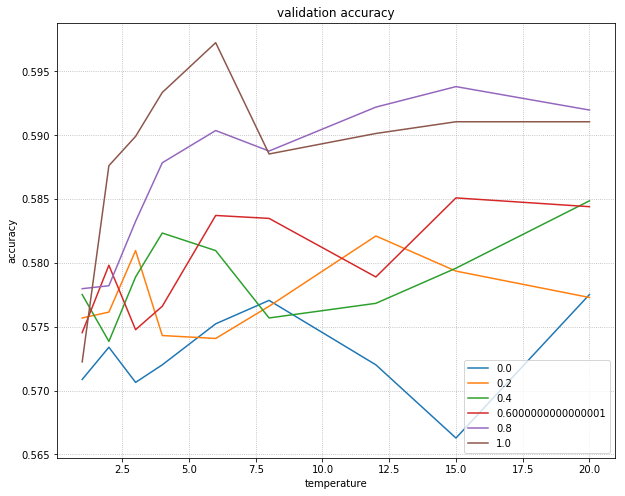

In [98]:
from collections import defaultdict
import matplotlib.pyplot as plt


Ts = [1, 2, 3, 4, 6, 8, 12, 15, 20]
alphas = np.linspace(0, 1, 6)

T_scores = defaultdict(lambda : [])
alpha_scores = defaultdict(lambda : [])

for res in all_result_parameters:
    T_scores[res[0][0]].append([res[1], res[2], res[3]])
    alpha_scores[res[0][1]].append([res[1], res[2], res[3]])
    
    
plt.figure(figsize=(10, 8))
for T in T_scores.keys():
    plt.plot(alphas, np.array(T_scores[T])[:,2], label=str(T))
    
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.title('validation accuracy')
plt.legend()
plt.show();

plt.figure(figsize=(10, 8))
for alpha in alpha_scores.keys():
    plt.plot(Ts, np.array(alpha_scores[alpha])[:,2], label=str(alpha))
    
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.title('validation accuracy')
plt.grid(ls=':')
plt.legend()
plt.show();


Обучим еще несколько экспериментов, чтобы сгладить шум

In [61]:
params['num_train_epochs'] = 15
params['train_batch_size'] = 256

Ts = [6, 8, 12, 15, 20]
alphas = [0.8, 1]

different_params = product(Ts, alphas)
all_result_parameters_addition = []
count_experiments = 5
for param in list(different_params):
    cur_result = []
    mean_acc_val = 0
    mean_loss_val = 0
    mean_loss_train = 0
    for i in range(count_experiments):
        model = BlendCNN(params['max_seq_length'], len(tokenizer.vocab), len(params['label_list']), n_layers=8).to(params['device'])

        model, result = train_student(model, teacher_model, tokenizer, params, train_examples, 
                                      valid_examples=dev_examples, name='BlendCNN', 
                                      checkpoint_files=checkpoint_files, 
                                      all_logits_teacher=all_logits_teacher,
                                      temperature=param[0], alpha=param[1])
        
        mean_loss_val += result['eval_loss']
        mean_loss_train += result['train_loss']
        mean_acc_val += result['eval_accuracy']
    
    
    all_result_parameters_addition.append((param, mean_loss_train / count_experiments, mean_loss_val / count_experiments, 
                                   mean_acc_val / count_experiments))
    

    print('---------------------------------------------------------------------------------------')
    print('T = {}, alpha = {}, \n train_loss={}, eval_loss={}, eval_accuracy={}'.format(all_result_parameters_addition[-1][0][0], 
                                                                                        all_result_parameters_addition[-1][0][1],
                                                                                        all_result_parameters_addition[-1][1],
                                                                                        all_result_parameters_addition[-1][2],
                                                                                        all_result_parameters_addition[-1][3]))
    
    with open('all_result_parameters_addition.pickle', 'wb') as file:
        pickle.dump(all_result_parameters_addition, file)
    

***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6362561863480192, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.80it/s]

{'eval_loss': 0.7370721983526825, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6172504059293054, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.43it/s]

{'eval_loss': 0.7391991411087984, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6099594289606267, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.85it/s]

{'eval_loss': 0.7355509032965253, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5996592460256633, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.81it/s]

{'eval_loss': 0.7285313189644879, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5786981736168717, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.85it/s]

{'eval_loss': 0.7377272263391439, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6764934057408845, 'eval_matthews_corrcoef': 0.0761180153401604}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5393710353157737, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.42it/s]

{'eval_loss': 0.7842149233911186, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6629032258064517, 'eval_matthews_corrcoef': 0.04633454339327085}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.499746971058123, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.05it/s]

{'eval_loss': 0.8013696380877021, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.661590524534687, 'eval_matthews_corrcoef': 0.09687330693587855}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4709715549692963, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.46it/s]

{'eval_loss': 0.798686558099297, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6519434628975266, 'eval_matthews_corrcoef': 0.1050665606329137}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.449341581626372, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.01it/s]

{'eval_loss': 0.7756021543237201, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6488038277511962, 'eval_matthews_corrcoef': 0.16349859654699792}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.432250997785366, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.75it/s]

{'eval_loss': 0.7737904008576185, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6377097729516289, 'eval_matthews_corrcoef': 0.16032697225982262}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4189496085499271, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.45it/s]

{'eval_loss': 0.8067101103522272, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6571699905033238, 'eval_matthews_corrcoef': 0.17950080239026603}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4086496965451674, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.86it/s]

{'eval_loss': 0.8186158276069055, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6547169811320755, 'eval_matthews_corrcoef': 0.1679850735628775}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4010450180732843, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.39it/s]

{'eval_loss': 0.808794659812328, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6517509727626459, 'eval_matthews_corrcoef': 0.18360117952889302}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3960281569849362, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.17it/s]

{'eval_loss': 0.8029410388788482, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6469428007889546, 'eval_matthews_corrcoef': 0.1821027838913405}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3930214553168325, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.71it/s]


{'eval_loss': 0.7922748386239902, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6458123107971746, 'eval_matthews_corrcoef': 0.19679941763846584}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.636253246755311, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.30it/s]

{'eval_loss': 0.737127506097249, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6172116773598122, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.43it/s]

{'eval_loss': 0.7394117098985189, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6098563684658571, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.39it/s]

{'eval_loss': 0.7357159812140082, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5994976506088718, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.25it/s]

{'eval_loss': 0.7291312354932958, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5784653849673993, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.75it/s]

{'eval_loss': 0.7368294104779942, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6765163297045103, 'eval_matthews_corrcoef': 0.07897980298201109}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5390468515229947, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.14it/s]

{'eval_loss': 0.7836992914933677, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6655896607431341, 'eval_matthews_corrcoef': 0.06201761500394787}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4990905247854465, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.35it/s]

{'eval_loss': 0.8031898524207405, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.654268808114962, 'eval_matthews_corrcoef': 0.0684001878554128}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.469941760102908, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.19it/s]

{'eval_loss': 0.8020802970554833, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6530973451327432, 'eval_matthews_corrcoef': 0.11035508878193946}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4481175401897142, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.77it/s]

{'eval_loss': 0.7792654546653774, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.650943396226415, 'eval_matthews_corrcoef': 0.15791059047162379}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4310668715924928, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.75it/s]

{'eval_loss': 0.7765262952558226, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6444007858546169, 'eval_matthews_corrcoef': 0.1728303467206467}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4178126020865007, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.19it/s]

{'eval_loss': 0.8093009617800692, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6559546313799622, 'eval_matthews_corrcoef': 0.17272307132019496}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4076122804121538, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.91it/s]

{'eval_loss': 0.8235584333629258, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6572769953051644, 'eval_matthews_corrcoef': 0.17126653741548054}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4001302244988354, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.95it/s]

{'eval_loss': 0.8128701512418247, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6518804243008679, 'eval_matthews_corrcoef': 0.17733520843145636}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3951652180967908, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 581.53it/s]

{'eval_loss': 0.8065855342586665, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6496565260058881, 'eval_matthews_corrcoef': 0.18502731922772878}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3921918173631032, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.00it/s]


{'eval_loss': 0.7957424388177385, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6444444444444445, 'eval_matthews_corrcoef': 0.19435005169516628}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6362382114836664, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.24it/s]

{'eval_loss': 0.7366803140815245, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6172188208861784, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.75it/s]

{'eval_loss': 0.7390864827080604, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6099265524835298, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.24it/s]

{'eval_loss': 0.7353673742383445, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.599587065703941, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.51it/s]

{'eval_loss': 0.728653514005859, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.57859601577123, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.45it/s]

{'eval_loss': 0.7370912104998844, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6754658385093167, 'eval_matthews_corrcoef': 0.06840392157713776}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.540115255749587, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.08it/s]

{'eval_loss': 0.7814781005972774, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.66934835076428, 'eval_matthews_corrcoef': 0.07594944352370278}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5013828245979366, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.64it/s]

{'eval_loss': 0.7982176866488095, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6632911392405063, 'eval_matthews_corrcoef': 0.10081119645150488}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4732003424203757, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.94it/s]

{'eval_loss': 0.7930975616039119, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6560565870910698, 'eval_matthews_corrcoef': 0.11893737728731792}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4517640466942932, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.21it/s]

{'eval_loss': 0.7704495628756352, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6450999048525213, 'eval_matthews_corrcoef': 0.14928282853408145}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4348413989399418, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.89it/s]

{'eval_loss': 0.7694808703685957, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.641025641025641, 'eval_matthews_corrcoef': 0.1676389484936071}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4216062209822915, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.36it/s]

{'eval_loss': 0.8036086553255942, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6483931947069944, 'eval_matthews_corrcoef': 0.15261969195671257}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4113121746164379, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.95it/s]

{'eval_loss': 0.8142996817293744, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6540642722117203, 'eval_matthews_corrcoef': 0.16769722647932436}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4037707091280909, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.68it/s]

{'eval_loss': 0.8038496078198152, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.65, 'eval_matthews_corrcoef': 0.17031329895678762}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3987510195284178, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.48it/s]

{'eval_loss': 0.7987106007330521, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6543330087633886, 'eval_matthews_corrcoef': 0.19079498204085138}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3957650968522737, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.11it/s]


{'eval_loss': 0.7885173223586966, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.641851106639839, 'eval_matthews_corrcoef': 0.18516006589283268}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6362557257666732, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.98it/s]

{'eval_loss': 0.7370130070784223, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6172604976278362, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.78it/s]

{'eval_loss': 0.7397071503342019, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.609965511343696, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.91it/s]

{'eval_loss': 0.7360261583512803, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5997519009944163, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.18it/s]

{'eval_loss': 0.7292697233481145, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5788780703689114, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.44it/s]

{'eval_loss': 0.7372651759817034, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6759689922480621, 'eval_matthews_corrcoef': 0.07065466965066387}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5400814883636706, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.33it/s]

{'eval_loss': 0.782674215667787, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.667741935483871, 'eval_matthews_corrcoef': 0.07073292614624922}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5007407656221678, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.75it/s]

{'eval_loss': 0.801383809142729, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6599664991624791, 'eval_matthews_corrcoef': 0.08014360761034414}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4720143495184002, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.97it/s]

{'eval_loss': 0.8002809400658482, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.654867256637168, 'eval_matthews_corrcoef': 0.11595504440448666}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4503574195233258, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.99it/s]

{'eval_loss': 0.7757818423790447, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6419753086419753, 'eval_matthews_corrcoef': 0.13951492943476418}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4332631438067465, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.80it/s]

{'eval_loss': 0.7717901643650251, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6425073457394711, 'eval_matthews_corrcoef': 0.16584861546042318}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.419881716822133, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.29it/s]

{'eval_loss': 0.8037110668475689, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6458333333333334, 'eval_matthews_corrcoef': 0.14735713564315625}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4096429912429866, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.45it/s]

{'eval_loss': 0.815364373594185, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.647780925401322, 'eval_matthews_corrcoef': 0.15023003684274067}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4021405559597593, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.33it/s]

{'eval_loss': 0.8055612073491387, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6481303930968361, 'eval_matthews_corrcoef': 0.16326108759979635}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3971726668603492, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.07it/s]

{'eval_loss': 0.7996870331132973, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6457925636007829, 'eval_matthews_corrcoef': 0.1732208892671816}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3942165126403172, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.04it/s]


{'eval_loss': 0.7897150655730453, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6492985971943888, 'eval_matthews_corrcoef': 0.19976956922919428}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6362639737851692, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.75it/s]

{'eval_loss': 0.737307732190014, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6172646907242862, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.02it/s]

{'eval_loss': 0.7395359412211617, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6099573613116236, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.89it/s]

{'eval_loss': 0.7356532985395795, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5996608558026226, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.43it/s]

{'eval_loss': 0.7288111016632767, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5788096099188833, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.41it/s]

{'eval_loss': 0.7362097714079219, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.675445391169636, 'eval_matthews_corrcoef': 0.06501200761361556}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5401068862640497, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.86it/s]

{'eval_loss': 0.7813338412659738, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6672051696284329, 'eval_matthews_corrcoef': 0.07005556986177226}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5005665782726172, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.84it/s]

{'eval_loss': 0.8004861005550943, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6638513513513514, 'eval_matthews_corrcoef': 0.10375531218491615}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4717940444296056, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.54it/s]

{'eval_loss': 0.7962267355376068, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6518650088809946, 'eval_matthews_corrcoef': 0.10971093002716044}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4501035091551868, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.62it/s]

{'eval_loss': 0.7724593062644799, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.648236415633937, 'eval_matthews_corrcoef': 0.15901365659928313}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4329394056941525, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.93it/s]

{'eval_loss': 0.7718985135439536, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6484375000000001, 'eval_matthews_corrcoef': 0.1782846631049874}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4195105112863309, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.12it/s]

{'eval_loss': 0.805361878345005, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6515151515151516, 'eval_matthews_corrcoef': 0.16240108923519875}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4091390136516455, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.15it/s]

{'eval_loss': 0.8173181334181492, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.650329877474081, 'eval_matthews_corrcoef': 0.15552387223493502}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4015211661656697, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.14it/s]

{'eval_loss': 0.8065853960605962, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6531791907514451, 'eval_matthews_corrcoef': 0.17992036635019343}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3964761518167728, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.11it/s]

{'eval_loss': 0.8005245478427008, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6523437500000001, 'eval_matthews_corrcoef': 0.18800603793162252}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3934635736725547, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.27it/s]


{'eval_loss': 0.7897735541214346, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6400797607178464, 'eval_matthews_corrcoef': 0.17393499414113392}
---------------------------------------------------------------------------------------
T = 6, alpha = 0.8, 
 train_loss=1.393731691169016, eval_loss=0.791204643898981, eval_accuracy=0.5940366972477065
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.863816244132591, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.30it/s]

{'eval_loss': 0.7858917352939965, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.837083354140773, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.12it/s]

{'eval_loss': 0.7731659505772618, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.828293854991595, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.39it/s]

{'eval_loss': 0.7688424923551191, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8166383283607888, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.23it/s]

{'eval_loss': 0.7630899186340083, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7911654196002267, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.26it/s]

{'eval_loss': 0.7670883958979826, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.676402767102229, 'eval_matthews_corrcoef': 0.06417764381562918}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7387696328488262, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.60it/s]

{'eval_loss': 0.8415763399626743, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6688102893890675, 'eval_matthews_corrcoef': 0.07218340591125333}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6876666780674097, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.84it/s]

{'eval_loss': 0.8643524930620173, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6582491582491582, 'eval_matthews_corrcoef': 0.0789143689003238}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6525162598400405, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.24it/s]

{'eval_loss': 0.8563356720281705, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6524064171122994, 'eval_matthews_corrcoef': 0.11461174157655014}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6263224116780541, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.58it/s]

{'eval_loss': 0.8248408992447434, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6522556390977443, 'eval_matthews_corrcoef': 0.15845895610846145}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.605751604293332, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.97it/s]

{'eval_loss': 0.8260106997382336, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6525505293551491, 'eval_matthews_corrcoef': 0.17758447983168052}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.589907463752862, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.58it/s]

{'eval_loss': 0.8737089353384729, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6505125815470643, 'eval_matthews_corrcoef': 0.1469943269121882}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5776683643008724, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.64it/s]

{'eval_loss': 0.8830845539385737, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6499068901303539, 'eval_matthews_corrcoef': 0.14457226690269837}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5687903594790082, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.84it/s]

{'eval_loss': 0.8680913635750394, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6577946768060836, 'eval_matthews_corrcoef': 0.18185002752244653}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5628838268193332, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.83it/s]

{'eval_loss': 0.8606665512118884, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6576923076923076, 'eval_matthews_corrcoef': 0.19004140691246227}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5593874743490508, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.51it/s]


{'eval_loss': 0.8455734809641908, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6594700686947988, 'eval_matthews_corrcoef': 0.20922986068437396}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8638481989954456, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.88it/s]

{'eval_loss': 0.7861669148839668, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8370695466345006, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.00it/s]

{'eval_loss': 0.773991863354357, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8281998128602, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.92it/s]

{'eval_loss': 0.7687420061439139, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8164835536118709, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.01it/s]

{'eval_loss': 0.7629665914888776, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7906758189201355, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.15it/s]

{'eval_loss': 0.7677368136814906, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6779400461183704, 'eval_matthews_corrcoef': 0.0818204261003797}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7383977766289855, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.16it/s]

{'eval_loss': 0.8385218001732286, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6693354683746999, 'eval_matthews_corrcoef': 0.06989387406540777}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6874926207643566, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.09it/s]

{'eval_loss': 0.8606939557576637, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6598812553011026, 'eval_matthews_corrcoef': 0.0930237257132889}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.651969602613738, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.15it/s]

{'eval_loss': 0.8532497050011544, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6583629893238434, 'eval_matthews_corrcoef': 0.1315440808782292}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.625656619668007, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.41it/s]

{'eval_loss': 0.8206693082762169, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6509877704609595, 'eval_matthews_corrcoef': 0.15579218836396924}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6052032379489956, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.56it/s]

{'eval_loss': 0.8208306803470296, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6498545101842871, 'eval_matthews_corrcoef': 0.17662224170890412}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.589456025849689, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.47it/s]

{'eval_loss': 0.8668564092034128, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6561043802423112, 'eval_matthews_corrcoef': 0.16234388619696724}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5772743130272084, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.87it/s]

{'eval_loss': 0.8779753502088529, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6591970121381886, 'eval_matthews_corrcoef': 0.17223863110777568}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.56840974724654, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.70it/s]

{'eval_loss': 0.8652445543924541, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6494746895893028, 'eval_matthews_corrcoef': 0.16374176618295402}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5626020314115467, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.32it/s]

{'eval_loss': 0.8558997946967308, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6491739552964043, 'eval_matthews_corrcoef': 0.17639594032947173}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.559083314556064, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.88it/s]


{'eval_loss': 0.8408077864088236, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6507936507936508, 'eval_matthews_corrcoef': 0.1959393748863527}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8638122808752637, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.83it/s]

{'eval_loss': 0.7843846216661121, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8370147130706094, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.45it/s]

{'eval_loss': 0.7738315649586943, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8280736736275933, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.64it/s]

{'eval_loss': 0.7692788682724221, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8160192835511584, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.05it/s]

{'eval_loss': 0.7629659827200508, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7900218819126938, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.68it/s]

{'eval_loss': 0.7678346459822165, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.676402767102229, 'eval_matthews_corrcoef': 0.06417764381562918}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7381124659018083, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.87it/s]

{'eval_loss': 0.8399393854245176, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6677367576243981, 'eval_matthews_corrcoef': 0.06451867126343691}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6878157072898112, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.93it/s]

{'eval_loss': 0.8583409632727025, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6644238856181665, 'eval_matthews_corrcoef': 0.101872586520169}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6529647423462435, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.19it/s]

{'eval_loss': 0.8458846632400293, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6595744680851063, 'eval_matthews_corrcoef': 0.13234214289000043}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6268924483747194, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.61it/s]

{'eval_loss': 0.8148787888204849, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6501901140684411, 'eval_matthews_corrcoef': 0.16187858873156827}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.606563187006748, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.90it/s]

{'eval_loss': 0.8191033742571338, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6498545101842871, 'eval_matthews_corrcoef': 0.17662224170890412}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5908120717063094, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.75it/s]

{'eval_loss': 0.8625595986023663, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6573033707865168, 'eval_matthews_corrcoef': 0.16920221255801865}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5786089702989117, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.70it/s]

{'eval_loss': 0.8721629718980494, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6572769953051644, 'eval_matthews_corrcoef': 0.17126653741548054}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5696928370179553, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.47it/s]

{'eval_loss': 0.858049532063754, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6487523992322457, 'eval_matthews_corrcoef': 0.16561528497756683}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5637536897803799, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.25it/s]

{'eval_loss': 0.851787839799643, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6505324298160697, 'eval_matthews_corrcoef': 0.17685416899274312}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.560250313444571, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.08it/s]


{'eval_loss': 0.8370756961998301, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6475814412635735, 'eval_matthews_corrcoef': 0.18441469104179462}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8638185520063748, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.82it/s]

{'eval_loss': 0.7856682243697141, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8370103678016951, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.45it/s]

{'eval_loss': 0.7735484429643652, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8281107278484288, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.89it/s]

{'eval_loss': 0.7691731529327435, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8162252844283076, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.84it/s]

{'eval_loss': 0.7628257562226932, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7902423843289867, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.06it/s]

{'eval_loss': 0.7689657123383442, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.676402767102229, 'eval_matthews_corrcoef': 0.06417764381562918}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7382309865770917, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.32it/s]

{'eval_loss': 0.8418477277630307, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6666666666666666, 'eval_matthews_corrcoef': 0.05998564107098251}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6880053051493384, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.16it/s]

{'eval_loss': 0.8627021590244012, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6610455311973019, 'eval_matthews_corrcoef': 0.09140991441750247}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6532497464707403, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.84it/s]

{'eval_loss': 0.8503777899094772, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6589492430988424, 'eval_matthews_corrcoef': 0.13411298894884638}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6271536941781188, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.19it/s]

{'eval_loss': 0.8178784899213863, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6483931947069944, 'eval_matthews_corrcoef': 0.15261969195671257}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.606867280421835, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.74it/s]

{'eval_loss': 0.8163460750284193, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6531400966183575, 'eval_matthews_corrcoef': 0.18200038226995163}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5910082373655203, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.67it/s]

{'eval_loss': 0.8616938605307016, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6504672897196262, 'eval_matthews_corrcoef': 0.14913391417313546}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5786775233167591, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.41it/s]

{'eval_loss': 0.8721791563380441, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6510757717492984, 'eval_matthews_corrcoef': 0.1515430105282062}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5697360567071221, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.38it/s]

{'eval_loss': 0.8592994979513572, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.650763358778626, 'eval_matthews_corrcoef': 0.1663514207642082}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5637951574542306, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.10it/s]

{'eval_loss': 0.8509529806465795, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6537717601547388, 'eval_matthews_corrcoef': 0.18432830154969598}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.560294832244064, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.40it/s]


{'eval_loss': 0.8369250527229011, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6534653465346535, 'eval_matthews_corrcoef': 0.2009494015609102}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.863817996147907, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.06it/s]

{'eval_loss': 0.7860267847058696, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8370525150588064, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.68it/s]

{'eval_loss': 0.7740899526744808, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8281300934878262, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.42it/s]

{'eval_loss': 0.7692048564689968, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8162297796119342, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.60it/s]

{'eval_loss': 0.7634359173938086, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7901579882159377, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.94it/s]

{'eval_loss': 0.76932865450022, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6774193548387096, 'eval_matthews_corrcoef': 0.0753496899199573}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7377774846373182, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.77it/s]

{'eval_loss': 0.8424597778245422, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6688051323175621, 'eval_matthews_corrcoef': 0.0691151156972863}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6876356488827504, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.66it/s]

{'eval_loss': 0.861999961525926, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6621392190152802, 'eval_matthews_corrcoef': 0.10223457122202283}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.653164295536099, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.07it/s]

{'eval_loss': 0.8509358192771063, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6548358473824313, 'eval_matthews_corrcoef': 0.11822043379901918}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6273008011507266, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.18it/s]

{'eval_loss': 0.820439302379323, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6546830652790918, 'eval_matthews_corrcoef': 0.17006580616603745}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6070140726638562, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.53it/s]

{'eval_loss': 0.8231727136449873, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6485963213939981, 'eval_matthews_corrcoef': 0.17195466348500157}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5912820823264844, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.76it/s]

{'eval_loss': 0.8683551483804418, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6548507462686568, 'eval_matthews_corrcoef': 0.15963164852052997}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5790462814497226, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.50it/s]

{'eval_loss': 0.8762299532907558, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6541705716963448, 'eval_matthews_corrcoef': 0.161426000286637}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5701518948331024, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 620.40it/s]

{'eval_loss': 0.8625043160021743, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.644359464627151, 'eval_matthews_corrcoef': 0.15121543315607708}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5642736369010173, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.36it/s]

{'eval_loss': 0.8552204606561428, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6492753623188405, 'eval_matthews_corrcoef': 0.17218321455132007}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5607968004363957, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.34it/s]


{'eval_loss': 0.8408624823867352, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6429980276134123, 'eval_matthews_corrcoef': 0.17246022695951824}
---------------------------------------------------------------------------------------
T = 6, alpha = 1, 
 train_loss=1.559962547006029, eval_loss=0.8402488997364962, eval_accuracy=0.5944954128440367
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7261333533308723, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.00it/s]

{'eval_loss': 0.7444641960938589, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7052926624363118, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.87it/s]

{'eval_loss': 0.7456956340358891, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6975461113633532, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.46it/s]

{'eval_loss': 0.7417996820199106, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.686665334484794, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.02it/s]

{'eval_loss': 0.7352625375288889, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6643684709613973, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.32it/s]

{'eval_loss': 0.7419835476913925, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.674922600619195, 'eval_matthews_corrcoef': 0.05917399655839452}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.622257215958653, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.04it/s]

{'eval_loss': 0.7941924574893874, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6698872785829307, 'eval_matthews_corrcoef': 0.07967311028556066}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5798653449976083, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.68it/s]

{'eval_loss': 0.8158164328731032, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6616288832913518, 'eval_matthews_corrcoef': 0.08933430939595562}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5494089379455105, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.18it/s]

{'eval_loss': 0.8100539316939096, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6530973451327432, 'eval_matthews_corrcoef': 0.11035508878193946}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5264539836031017, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.35it/s]

{'eval_loss': 0.785123455162222, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6395458845789972, 'eval_matthews_corrcoef': 0.12990402336934562}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5083121097449101, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.34it/s]

{'eval_loss': 0.7839139483152427, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6413255360623782, 'eval_matthews_corrcoef': 0.15902526359690844}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4941209572734255, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.77it/s]

{'eval_loss': 0.8190829714171699, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6483931947069944, 'eval_matthews_corrcoef': 0.15261969195671257}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.483183577656746, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.97it/s]

{'eval_loss': 0.8319527640663207, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.649155722326454, 'eval_matthews_corrcoef': 0.14859710185056807}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4751542784047849, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.58it/s]

{'eval_loss': 0.8217467195738893, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6473988439306358, 'eval_matthews_corrcoef': 0.16515280616030556}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.469874624501575, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.28it/s]

{'eval_loss': 0.8169344571064474, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6485436893203884, 'eval_matthews_corrcoef': 0.1740652921705486}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.466719929467548, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.91it/s]


{'eval_loss': 0.8045014347889089, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6373626373626374, 'eval_matthews_corrcoef': 0.16900504837457522}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7260911640795795, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.77it/s]

{'eval_loss': 0.742538554918602, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7050808026935116, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.46it/s]

{'eval_loss': 0.7457538248475538, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.697131780512405, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.23it/s]

{'eval_loss': 0.742137161382568, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6859051860643155, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.15it/s]

{'eval_loss': 0.7356921592983631, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6627836042281352, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.19it/s]

{'eval_loss': 0.7461648062811396, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.673913043478261, 'eval_matthews_corrcoef': 0.05539165726316216}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6201516182133646, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.56it/s]

{'eval_loss': 0.7973577155028855, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6677445432497978, 'eval_matthews_corrcoef': 0.07372394272586359}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5784246664155612, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.31it/s]

{'eval_loss': 0.818495144519139, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6627318718381112, 'eval_matthews_corrcoef': 0.09785056126398455}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5482589927586643, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.48it/s]

{'eval_loss': 0.8117886085483489, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.652482269503546, 'eval_matthews_corrcoef': 0.11002923712819063}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5254715346928798, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.35it/s]

{'eval_loss': 0.7877990191318031, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6400759734093068, 'eval_matthews_corrcoef': 0.13451669531532645}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5075125369158657, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.50it/s]

{'eval_loss': 0.7896684664760827, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6368062317429406, 'eval_matthews_corrcoef': 0.14693560831335867}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4934235671252916, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.28it/s]

{'eval_loss': 0.826095112687812, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6410496719775071, 'eval_matthews_corrcoef': 0.12587453882936928}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4825521490790627, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.74it/s]

{'eval_loss': 0.8374264840249702, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6428571428571429, 'eval_matthews_corrcoef': 0.13315566543189786}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4745566379843336, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.26it/s]

{'eval_loss': 0.8275075470849791, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6444232602478551, 'eval_matthews_corrcoef': 0.1490596071696654}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4692570774844198, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.81it/s]

{'eval_loss': 0.8227214584262709, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6453488372093024, 'eval_matthews_corrcoef': 0.1644999245271596}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4660747936277678, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.39it/s]


{'eval_loss': 0.8113342669131363, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6396039603960395, 'eval_matthews_corrcoef': 0.1673034956159959}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7261080371611046, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 578.13it/s]

{'eval_loss': 0.7441654133892387, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7051668013587142, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.36it/s]

{'eval_loss': 0.7461427250928289, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6972563045494484, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.12it/s]

{'eval_loss': 0.7418698733074403, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6857885018442615, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.54it/s]

{'eval_loss': 0.7348788435306024, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 5


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6616496985608882, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.18it/s]

{'eval_loss': 0.7477267620820176, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6738962044926414, 'eval_matthews_corrcoef': 0.051265530737021774}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6177116027384093, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.82it/s]

{'eval_loss': 0.7982868934893946, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6677471636952999, 'eval_matthews_corrcoef': 0.07664598504910998}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5758919593962757, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.39it/s]

{'eval_loss': 0.8187371712234598, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6621621621621622, 'eval_matthews_corrcoef': 0.09735501279150593}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5458206511808164, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.61it/s]

{'eval_loss': 0.816698480684763, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6584507042253521, 'eval_matthews_corrcoef': 0.12271547156850134}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5233556799816363, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.36it/s]

{'eval_loss': 0.7896748177668212, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6491063029162747, 'eval_matthews_corrcoef': 0.15073746339547017}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5056484824780263, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.93it/s]

{'eval_loss': 0.7867702875156041, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6426484907497565, 'eval_matthews_corrcoef': 0.16155539955585624}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4917274939291405, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.77it/s]

{'eval_loss': 0.8227244872504251, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.64733395696913, 'eval_matthews_corrcoef': 0.1413607401336465}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4809660943168583, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.55it/s]

{'eval_loss': 0.8367991075101265, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6505576208178439, 'eval_matthews_corrcoef': 0.1448492732594934}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4730226551041459, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.72it/s]

{'eval_loss': 0.8244129330944591, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6507177033492823, 'eval_matthews_corrcoef': 0.16845516643258343}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4677573921102467, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.98it/s]

{'eval_loss': 0.8168253679155029, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6537342386032978, 'eval_matthews_corrcoef': 0.1864034302501314}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4646017826867825, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.58it/s]


{'eval_loss': 0.803874587874866, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6481113320079523, 'eval_matthews_corrcoef': 0.19094902364303168}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7260987063248951, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.49it/s]

{'eval_loss': 0.7437411494074612, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7051811755606623, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.89it/s]

{'eval_loss': 0.7460179606948151, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6973413278659184, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.09it/s]

{'eval_loss': 0.7424721112560242, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6862581304528497, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.23it/s]

{'eval_loss': 0.736146175857941, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6634718640284105, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.33it/s]

{'eval_loss': 0.7430597557301778, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6744186046511629, 'eval_matthews_corrcoef': 0.05716717579440755}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6207064719814244, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.73it/s]

{'eval_loss': 0.7965347532240605, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6628940986257074, 'eval_matthews_corrcoef': 0.04974808069567225}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5781207472989054, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.33it/s]

{'eval_loss': 0.8192093301748157, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6553191489361703, 'eval_matthews_corrcoef': 0.07971258465608642}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5477286938465002, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.44it/s]

{'eval_loss': 0.8133361169987213, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6541889483065955, 'eval_matthews_corrcoef': 0.1201272735111391}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.525003241318645, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.85it/s]

{'eval_loss': 0.7888493397283269, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6440037771482531, 'eval_matthews_corrcoef': 0.14016700165093934}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5071408012599656, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.85it/s]

{'eval_loss': 0.788559718367776, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.64, 'eval_matthews_corrcoef': 0.15650056146666994}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4932055337862535, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.32it/s]

{'eval_loss': 0.8254573929012505, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6497175141242937, 'eval_matthews_corrcoef': 0.15313285191519047}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4824469383015777, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.79it/s]

{'eval_loss': 0.8373407140777899, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.650375939849624, 'eval_matthews_corrcoef': 0.15339829797314872}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4745831457954464, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.99it/s]

{'eval_loss': 0.8267147011516632, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6488038277511962, 'eval_matthews_corrcoef': 0.16349859654699792}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4694298022624217, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.40it/s]

{'eval_loss': 0.8214048482934247, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6419512195121951, 'eval_matthews_corrcoef': 0.161365401392484}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.466309119806145, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.52it/s]


{'eval_loss': 0.8095479574045935, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6399999999999999, 'eval_matthews_corrcoef': 0.17609123793397816}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.726112413135442, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.01it/s]

{'eval_loss': 0.7442514198840758, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7051950828595595, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.96it/s]

{'eval_loss': 0.7459012340720094, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6972530330672408, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.15it/s]

{'eval_loss': 0.7419751715769461, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6859030172680363, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.75it/s]

{'eval_loss': 0.7357736879857172, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.662241696859851, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.74it/s]

{'eval_loss': 0.7465024147088717, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6733902249806051, 'eval_matthews_corrcoef': 0.049631618940870745}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6192492630445596, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.88it/s]

{'eval_loss': 0.798421141028259, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6672051696284329, 'eval_matthews_corrcoef': 0.07005556986177226}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5774747368061182, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.24it/s]

{'eval_loss': 0.819829833753078, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6632996632996633, 'eval_matthews_corrcoef': 0.09836048693378717}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5474616876154235, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.85it/s]

{'eval_loss': 0.8170480832971265, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6532045654082529, 'eval_matthews_corrcoef': 0.10336526347356717}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.52475319712451, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.33it/s]

{'eval_loss': 0.7914304795619976, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6449207828518174, 'eval_matthews_corrcoef': 0.13164476762740918}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.506834216190107, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.35it/s]

{'eval_loss': 0.7864719952665987, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6453488372093024, 'eval_matthews_corrcoef': 0.1644999245271596}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4928612388444669, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.02it/s]

{'eval_loss': 0.822534938125258, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.649155722326454, 'eval_matthews_corrcoef': 0.14859710185056807}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.482154680923982, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.29it/s]

{'eval_loss': 0.8373699636311257, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6492048643592142, 'eval_matthews_corrcoef': 0.14645187533092635}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4742740379138426, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.17it/s]

{'eval_loss': 0.8246904864884302, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.648236415633937, 'eval_matthews_corrcoef': 0.15901365659928313}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4690353342077949, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.78it/s]

{'eval_loss': 0.8168547503818937, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6511627906976745, 'eval_matthews_corrcoef': 0.17918501197471112}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.465859417662476, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.42it/s]


{'eval_loss': 0.8044356187210641, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6533864541832669, 'eval_matthews_corrcoef': 0.20512006290239218}
---------------------------------------------------------------------------------------
T = 8, alpha = 0.8, 
 train_loss=1.4659130086501437, eval_loss=0.8067387731405138, eval_accuracy=0.5896788990825688
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9744711735031821, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.71it/s]

{'eval_loss': 0.8021229454273477, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9447531320831992, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.81it/s]

{'eval_loss': 0.7853419728953084, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9349606560938286, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.33it/s]

{'eval_loss': 0.780449764452738, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9217979664152318, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.79it/s]

{'eval_loss': 0.7739505469200945, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.892160675290859, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.80it/s]

{'eval_loss': 0.7844078827653627, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.833496222893397, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.53it/s]

{'eval_loss': 0.866051460841645, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6677393403057119, 'eval_matthews_corrcoef': 0.06766681286428947}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7807226898995312, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.70it/s]

{'eval_loss': 0.8864139151663857, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6598639455782314, 'eval_matthews_corrcoef': 0.09550630785054194}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.744583005254919, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.84it/s]

{'eval_loss': 0.8751852822906835, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6517857142857143, 'eval_matthews_corrcoef': 0.11429487418570355}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7170032420844743, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.09it/s]

{'eval_loss': 0.8446693828821005, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6496694995278565, 'eval_matthews_corrcoef': 0.15526155443864134}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6955224781325369, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.82it/s]

{'eval_loss': 0.843042474658599, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6416184971098265, 'eval_matthews_corrcoef': 0.1503852459704177}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6788166680119254, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.56it/s]

{'eval_loss': 0.8939618149548267, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6517690875232776, 'eval_matthews_corrcoef': 0.14969527636056382}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6657575806885054, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.51it/s]

{'eval_loss': 0.9033780587371039, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6504672897196262, 'eval_matthews_corrcoef': 0.14913391417313546}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6562049203749858, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.05it/s]

{'eval_loss': 0.8871071361719685, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6470588235294119, 'eval_matthews_corrcoef': 0.15212954219621544}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6498523340983824, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.16it/s]

{'eval_loss': 0.8770618303234362, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.649325626204239, 'eval_matthews_corrcoef': 0.1700753262236015}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6460227573459798, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.65it/s]


{'eval_loss': 0.8600457171685091, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6416584402764067, 'eval_matthews_corrcoef': 0.16996205977261142}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9744661296858932, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.35it/s]

{'eval_loss': 0.8009522356127107, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9447645833998015, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.91it/s]

{'eval_loss': 0.7854230392023648, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9349088303067468, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.31it/s]

{'eval_loss': 0.7805875329847592, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9214679165319963, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.71it/s]

{'eval_loss': 0.7731070910759885, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8907725223989198, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 584.49it/s]

{'eval_loss': 0.7878062923357677, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8309147068948457, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.64it/s]

{'eval_loss': 0.8659714595030207, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.0694074328388508}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7782368303248377, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.65it/s]

{'eval_loss': 0.8810787443071604, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6604572396274344, 'eval_matthews_corrcoef': 0.09346665904022318}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7421475703066045, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.47it/s]

{'eval_loss': 0.865076823045506, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6553267681289167, 'eval_matthews_corrcoef': 0.1274980400588741}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7146916416558353, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.74it/s]

{'eval_loss': 0.8334815443207461, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6462715105162524, 'eval_matthews_corrcoef': 0.1561770473083987}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6934159289706836, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.62it/s]

{'eval_loss': 0.8351862353401968, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.644100580270793, 'eval_matthews_corrcoef': 0.15980818333036861}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6767937193314235, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.96it/s]

{'eval_loss': 0.8817630771330879, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6491063029162747, 'eval_matthews_corrcoef': 0.15073746339547017}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6637713990428231, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.57it/s]

{'eval_loss': 0.8922538317394456, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6497175141242937, 'eval_matthews_corrcoef': 0.15313285191519047}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.654220103765979, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.63it/s]

{'eval_loss': 0.877641874835976, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6493756003842459, 'eval_matthews_corrcoef': 0.16796600324726968}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.647894718430259, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.27it/s]

{'eval_loss': 0.8676511259158644, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6536585365853659, 'eval_matthews_corrcoef': 0.1905544409473684}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.644036843921199, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.05it/s]


{'eval_loss': 0.8516299957942182, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6533864541832669, 'eval_matthews_corrcoef': 0.20512006290239218}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9744486858447392, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.05it/s]

{'eval_loss': 0.7999955981696417, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.944797604373007, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.75it/s]

{'eval_loss': 0.7849023397072056, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9351769071636777, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.48it/s]

{'eval_loss': 0.7803173242564049, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.922358365221457, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.55it/s]

{'eval_loss': 0.7733261357616941, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8936835545482058, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.70it/s]

{'eval_loss': 0.7823501168002606, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.676402767102229, 'eval_matthews_corrcoef': 0.06417764381562918}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8353182470256633, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.18it/s]

{'eval_loss': 0.8624703404312065, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6639935846030474, 'eval_matthews_corrcoef': 0.043620876742957344}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7816517678174106, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.42it/s]

{'eval_loss': 0.8815699410288372, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6638441998306519, 'eval_matthews_corrcoef': 0.10614996540235741}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7447737663081198, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.61it/s]

{'eval_loss': 0.8699760711428799, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6595555555555556, 'eval_matthews_corrcoef': 0.1345134441069886}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.716947155919942, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.16it/s]

{'eval_loss': 0.8400088895698091, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.639019792648445, 'eval_matthews_corrcoef': 0.12526576947079773}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6953031917413075, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.29it/s]

{'eval_loss': 0.831479904211421, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.64453125, 'eval_matthews_corrcoef': 0.16856328827835226}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6783559521039326, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.95it/s]

{'eval_loss': 0.8830488336609235, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6490066225165563, 'eval_matthews_corrcoef': 0.15500513761727802}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6651142054434978, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.83it/s]

{'eval_loss': 0.8957262680991451, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6516007532956685, 'eval_matthews_corrcoef': 0.15818169670005308}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6554222535906415, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.87it/s]

{'eval_loss': 0.8800010825420566, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6481303930968361, 'eval_matthews_corrcoef': 0.16326108759979635}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6490007629900267, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.02it/s]

{'eval_loss': 0.8690086530996518, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6439024390243903, 'eval_matthews_corrcoef': 0.16623024131829806}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6451746862043033, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.01it/s]


{'eval_loss': 0.8528662635512231, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6434955312810328, 'eval_matthews_corrcoef': 0.1790540847964098}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9744807716571924, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.29it/s]

{'eval_loss': 0.8021162632647731, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.944813428051544, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.18it/s]

{'eval_loss': 0.7850871614667527, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9350401736570126, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.41it/s]

{'eval_loss': 0.7798532091525443, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9216540184887974, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.59it/s]

{'eval_loss': 0.7733054205074633, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8906185798572772, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.33it/s]

{'eval_loss': 0.7898903929248213, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6774441878367974, 'eval_matthews_corrcoef': 0.077251184274487}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8301459907582311, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.74it/s]

{'eval_loss': 0.8680084935339262, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6645056726094003, 'eval_matthews_corrcoef': 0.060927429319377176}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.777743730581168, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.44it/s]

{'eval_loss': 0.8811792742026812, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.6626916524701874, 'eval_matthews_corrcoef': 0.10750104935656746}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7419438556288227, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.75it/s]

{'eval_loss': 0.866078316245667, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6571428571428571, 'eval_matthews_corrcoef': 0.13078116613926555}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7146255220427657, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.97it/s]

{'eval_loss': 0.8376786755169624, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6490566037735849, 'eval_matthews_corrcoef': 0.1528733489259969}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.693353032072385, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.02it/s]

{'eval_loss': 0.8357345094308075, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6453488372093024, 'eval_matthews_corrcoef': 0.1644999245271596}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6767332621596076, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 581.06it/s]

{'eval_loss': 0.8866460806014094, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6504672897196262, 'eval_matthews_corrcoef': 0.14913391417313546}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6637200984087857, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.88it/s]

{'eval_loss': 0.8991111314255683, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6517273576097107, 'eval_matthews_corrcoef': 0.1518237763672591}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6542122115691502, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.92it/s]

{'eval_loss': 0.8833804002303097, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6456542502387775, 'eval_matthews_corrcoef': 0.15380835724239914}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6478954792925806, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.46it/s]

{'eval_loss': 0.8718920281178792, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6427184466019417, 'eval_matthews_corrcoef': 0.15940669043483668}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6441515602848746, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.84it/s]


{'eval_loss': 0.854154826381867, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6428571428571429, 'eval_matthews_corrcoef': 0.17674171927951005}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9744610091050465, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.04it/s]

{'eval_loss': 0.8000278080377831, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9447631199251523, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.09it/s]

{'eval_loss': 0.7853018605500597, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9350801999821807, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.76it/s]

{'eval_loss': 0.7799290730746105, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.921798926411253, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.12it/s]

{'eval_loss': 0.7732286510066292, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.891510298757842, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.96it/s]

{'eval_loss': 0.7858501135696306, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6769230769230767, 'eval_matthews_corrcoef': 0.07087909741979882}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8320748151251764, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.20it/s]

{'eval_loss': 0.8663017551704105, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6645213193885761, 'eval_matthews_corrcoef': 0.05110155154546285}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7791864727482651, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.15it/s]

{'eval_loss': 0.8822359490737537, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6649659863945577, 'eval_matthews_corrcoef': 0.11425214378519213}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7427007059256236, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.15it/s]

{'eval_loss': 0.8649151765903215, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6589492430988424, 'eval_matthews_corrcoef': 0.13411298894884638}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7149380648677999, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.57it/s]

{'eval_loss': 0.8340015844311116, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6469465648854961, 'eval_matthews_corrcoef': 0.15640773836042499}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.693316464171265, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.54it/s]

{'eval_loss': 0.8348912966868588, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6413255360623782, 'eval_matthews_corrcoef': 0.15902526359690844}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6764631244269284, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.45it/s]

{'eval_loss': 0.8860972210967277, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6591970121381886, 'eval_matthews_corrcoef': 0.17223863110777568}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6633565868392135, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.30it/s]

{'eval_loss': 0.8979238173832269, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6585594013096352, 'eval_matthews_corrcoef': 0.1719075513173256}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6538193948341138, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.05it/s]

{'eval_loss': 0.8836759388332796, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6500479386385426, 'eval_matthews_corrcoef': 0.16820770568134683}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.647526943322384, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.52it/s]

{'eval_loss': 0.873891681913805, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6479690522243714, 'eval_matthews_corrcoef': 0.16961623061809955}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.643767028595462, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.95it/s]


{'eval_loss': 0.8574371062615115, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.642073778664008, 'eval_matthews_corrcoef': 0.1787171644933558}
---------------------------------------------------------------------------------------
T = 8, alpha = 1, 
 train_loss=1.6446305752703636, eval_loss=0.8552267818314657, eval_accuracy=0.5896788990825689
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.796814167138302, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.06it/s]

{'eval_loss': 0.7513932049479506, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7743740551399463, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.80it/s]

{'eval_loss': 0.7511942976350905, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7660229124806144, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.22it/s]

{'eval_loss': 0.7472621980336828, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7540960506056293, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.77it/s]

{'eval_loss': 0.7404869584400856, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.728690453099482, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.73it/s]

{'eval_loss': 0.7525086578007343, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6744186046511629, 'eval_matthews_corrcoef': 0.05716717579440755}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6819407854116324, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.62it/s]

{'eval_loss': 0.8073706106024308, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6677497969130789, 'eval_matthews_corrcoef': 0.07950448875887114}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6380244701197653, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.79it/s]

{'eval_loss': 0.8288213934593432, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6593591905564924, 'eval_matthews_corrcoef': 0.0849692675710204}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6066103482788259, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.15it/s]

{'eval_loss': 0.820673461286287, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6589902568644819, 'eval_matthews_corrcoef': 0.12975283931199946}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.582858231934634, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.59it/s]

{'eval_loss': 0.7928181413647616, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6440037771482531, 'eval_matthews_corrcoef': 0.14016700165093934}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.564225376555414, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.52it/s]

{'eval_loss': 0.7903984566309934, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6471734892787524, 'eval_matthews_corrcoef': 0.17363235943853458}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5496237354748177, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.53it/s]

{'eval_loss': 0.8290279048653597, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6491063029162747, 'eval_matthews_corrcoef': 0.15073746339547017}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5383248740073405, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.06it/s]

{'eval_loss': 0.841863905368031, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6522556390977443, 'eval_matthews_corrcoef': 0.15845895610846145}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5300466892394153, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.31it/s]

{'eval_loss': 0.8307230491025605, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6512968299711815, 'eval_matthews_corrcoef': 0.17290284950693058}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.524590067339666, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.81it/s]

{'eval_loss': 0.8244037208660803, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6484375000000001, 'eval_matthews_corrcoef': 0.1782846631049874}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.521283936319929, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.64it/s]


{'eval_loss': 0.8114733430556953, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6454183266932271, 'eval_matthews_corrcoef': 0.1859778652513984}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7968190601377776, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.05it/s]

{'eval_loss': 0.7505966298145439, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.774388792388367, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.79it/s]

{'eval_loss': 0.7509043401260989, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7661221393130042, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.19it/s]

{'eval_loss': 0.7470647445751712, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.754463976982868, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.48it/s]

{'eval_loss': 0.7404522373503365, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7295646970019196, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.71it/s]

{'eval_loss': 0.7509832634300062, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6754250386398765, 'eval_matthews_corrcoef': 0.0614640667980343}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6825817588603857, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.38it/s]

{'eval_loss': 0.8061511511647425, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6628849270664505, 'eval_matthews_corrcoef': 0.05306815145451077}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6380399948719777, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 619.60it/s]

{'eval_loss': 0.827964877590661, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6559322033898305, 'eval_matthews_corrcoef': 0.07743717870221756}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.606203284679037, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.81it/s]

{'eval_loss': 0.8212030221961242, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6583629893238434, 'eval_matthews_corrcoef': 0.1315440808782292}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5823151004133802, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.77it/s]

{'eval_loss': 0.7960302939709519, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.644486692015209, 'eval_matthews_corrcoef': 0.14690000963840957}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.563691699143612, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.90it/s]

{'eval_loss': 0.7958428315103263, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6432062561094818, 'eval_matthews_corrcoef': 0.16603691326154765}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5491930639201945, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.36it/s]

{'eval_loss': 0.8388164700402765, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6536312849162011, 'eval_matthews_corrcoef': 0.15481828581842924}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5379115311485347, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.64it/s]

{'eval_loss': 0.8484574371508009, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6542056074766357, 'eval_matthews_corrcoef': 0.15932870667540688}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5296595200444714, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.06it/s]

{'eval_loss': 0.8357962635939848, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6557692307692308, 'eval_matthews_corrcoef': 0.1851093799235436}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5242181664163417, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.49it/s]

{'eval_loss': 0.8291209000045296, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6517073170731708, 'eval_matthews_corrcoef': 0.18568960102155432}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5208345299417323, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.25it/s]


{'eval_loss': 0.8159067399002539, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.65, 'eval_matthews_corrcoef': 0.1999524325321925}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7968455995574142, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.54it/s]

{'eval_loss': 0.7518688979293775, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7744296324072462, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.54it/s]

{'eval_loss': 0.7509412236614238, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7660186959035469, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.71it/s]

{'eval_loss': 0.7472354608733173, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7542935388557839, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.07it/s]

{'eval_loss': 0.7401997749907298, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7289072988611278, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.69it/s]

{'eval_loss': 0.7540490009027336, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.675445391169636, 'eval_matthews_corrcoef': 0.06501200761361556}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6805250640168334, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.85it/s]

{'eval_loss': 0.8088845610287502, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6601784266017843, 'eval_matthews_corrcoef': 0.041127517125153744}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6356373126759673, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.43it/s]

{'eval_loss': 0.8298037241874134, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6581849024597116, 'eval_matthews_corrcoef': 0.08671997308490936}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.603941405361349, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.18it/s]

{'eval_loss': 0.8267156725996089, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6601597160603372, 'eval_matthews_corrcoef': 0.13492299670775942}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5800300804954586, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.09it/s]

{'eval_loss': 0.7968974213247773, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.647887323943662, 'eval_matthews_corrcoef': 0.14593331366967055}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5612257606152333, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.49it/s]

{'eval_loss': 0.7891931059893643, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6483839373163566, 'eval_matthews_corrcoef': 0.18039400831426744}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5465157637090394, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.70it/s]

{'eval_loss': 0.8280597873610965, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6572237960339942, 'eval_matthews_corrcoef': 0.17538762482224404}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5350294198953744, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.56it/s]

{'eval_loss': 0.8431178905089053, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6528692380056444, 'eval_matthews_corrcoef': 0.16084691333246834}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5265834850795341, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.46it/s]

{'eval_loss': 0.8307657822084916, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6563706563706564, 'eval_matthews_corrcoef': 0.18949574200229932}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5210076358282205, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.71it/s]

{'eval_loss': 0.8249082135951356, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6581782566111656, 'eval_matthews_corrcoef': 0.20463632973734125}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5176944109526547, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.72it/s]


{'eval_loss': 0.8124071396063584, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6493506493506493, 'eval_matthews_corrcoef': 0.19765814017936387}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7968124634388722, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.89it/s]

{'eval_loss': 0.7507090207120968, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7743895609270444, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.62it/s]

{'eval_loss': 0.7507903400227565, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7661072038339847, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.61it/s]

{'eval_loss': 0.7468758669399888, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7546463671958807, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.61it/s]

{'eval_loss': 0.7406179608879696, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7307886485800599, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.54it/s]

{'eval_loss': 0.7464460976968664, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6759689922480621, 'eval_matthews_corrcoef': 0.07065466965066387}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6850982001333525, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.06it/s]

{'eval_loss': 0.8033636929926573, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6634382566585957, 'eval_matthews_corrcoef': 0.050178247748683694}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.639912112192674, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.11it/s]

{'eval_loss': 0.826236118646894, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6593406593406593, 'eval_matthews_corrcoef': 0.0875417038406246}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6077513459957007, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.04it/s]

{'eval_loss': 0.8225393040106235, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.650709219858156, 'eval_matthews_corrcoef': 0.10445101068773817}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5835811161633693, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.55it/s]

{'eval_loss': 0.7972882671760707, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6471698113207548, 'eval_matthews_corrcoef': 0.14783610738037004}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5646282547351085, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.61it/s]

{'eval_loss': 0.7931211703617677, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6491228070175439, 'eval_matthews_corrcoef': 0.1785013913857433}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.549868603547414, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.38it/s]

{'eval_loss': 0.8346225130509258, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6472795497185742, 'eval_matthews_corrcoef': 0.14352441656973125}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5384409847584637, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.55it/s]

{'eval_loss': 0.8455432939063865, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6492048643592142, 'eval_matthews_corrcoef': 0.14645187533092635}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5300279408693314, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.93it/s]

{'eval_loss': 0.8330251685045436, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6488038277511962, 'eval_matthews_corrcoef': 0.16349859654699792}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5244404804525953, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.25it/s]

{'eval_loss': 0.8263582775491843, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6491739552964043, 'eval_matthews_corrcoef': 0.17639594032947173}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.521071721658562, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.59it/s]


{'eval_loss': 0.8121971294473175, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6392785571142284, 'eval_matthews_corrcoef': 0.17594063177462854}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7968383494651679, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.30it/s]

{'eval_loss': 0.7512762007910178, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7744246197469307, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.24it/s]

{'eval_loss': 0.7507827183863985, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7661733735691418, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.79it/s]

{'eval_loss': 0.7471433493795745, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7544977908784694, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.19it/s]

{'eval_loss': 0.7399095484235008, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7294770601120861, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.78it/s]

{'eval_loss': 0.7517959312493101, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.674922600619195, 'eval_matthews_corrcoef': 0.05917399655839452}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6818851241559694, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.27it/s]

{'eval_loss': 0.8094273717954344, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6623481781376518, 'eval_matthews_corrcoef': 0.04933714287364751}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6369481366692167, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.07it/s]

{'eval_loss': 0.8332217926177657, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6616033755274261, 'eval_matthews_corrcoef': 0.09439085148322324}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.605018466259494, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.83it/s]

{'eval_loss': 0.8305500300562142, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6543859649122806, 'eval_matthews_corrcoef': 0.10638924104476988}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.581079893491485, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.29it/s]

{'eval_loss': 0.7996857120081945, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6413662239089184, 'eval_matthews_corrcoef': 0.13711857047075907}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.56225576635563, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.74it/s]

{'eval_loss': 0.7937273253924897, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6367265469061877, 'eval_matthews_corrcoef': 0.1666889482900249}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.547544105034886, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.08it/s]

{'eval_loss': 0.8353718256291083, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6535211267605634, 'eval_matthews_corrcoef': 0.16113324791715652}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5362485159527173, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.15it/s]

{'eval_loss': 0.8502233861691912, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6566884939195509, 'eval_matthews_corrcoef': 0.16681641612004575}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5278806907661033, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.89it/s]

{'eval_loss': 0.8379646864115717, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6519230769230769, 'eval_matthews_corrcoef': 0.17524532594570627}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5223794001521487, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.44it/s]

{'eval_loss': 0.8316093576318262, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6496565260058881, 'eval_matthews_corrcoef': 0.18502731922772878}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5190352047934677, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.38it/s]


{'eval_loss': 0.8190328892554827, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6459378134403211, 'eval_matthews_corrcoef': 0.1925362392860044}
---------------------------------------------------------------------------------------
T = 12, alpha = 0.8, 
 train_loss=1.5199839607332692, eval_loss=0.8142034482530216, eval_accuracy=0.5940366972477065
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.061392321731105, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.14it/s]

{'eval_loss': 0.8146070535850087, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0292970700697466, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.02it/s]

{'eval_loss': 0.7945389649275383, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0189906643195585, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.97it/s]

{'eval_loss': 0.788988732544859, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0050472743583447, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.82it/s]

{'eval_loss': 0.7823333335493546, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.972827856739362, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.38it/s]

{'eval_loss': 0.7937533159744541, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.676946800308404, 'eval_matthews_corrcoef': 0.07344622685060528}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.908455312703595, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.18it/s]

{'eval_loss': 0.8804884064753556, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6650524616626311, 'eval_matthews_corrcoef': 0.058263139108042934}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8528387704581926, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.54it/s]

{'eval_loss': 0.8970656358023332, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6598114824335903, 'eval_matthews_corrcoef': 0.10279641494573011}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8156452332482194, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.52it/s]

{'eval_loss': 0.8745256643210978, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6516651665166516, 'eval_matthews_corrcoef': 0.12107029270695722}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7871476046063683, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.12it/s]

{'eval_loss': 0.8422515342618689, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6476190476190475, 'eval_matthews_corrcoef': 0.15664393755958642}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.764695862477476, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.02it/s]

{'eval_loss': 0.8419376538546837, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6438356164383562, 'eval_matthews_corrcoef': 0.16836838941364193}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7471189575664925, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.46it/s]

{'eval_loss': 0.8960059086506206, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6547507055503292, 'eval_matthews_corrcoef': 0.1659016383009674}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7332872269731578, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.47it/s]

{'eval_loss': 0.9055337872172075, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6566321730950141, 'eval_matthews_corrcoef': 0.17095636326946648}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.723239835464593, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.72it/s]

{'eval_loss': 0.8903128291871276, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6480231436837031, 'eval_matthews_corrcoef': 0.16749954491840266}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.71655986977346, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.46it/s]

{'eval_loss': 0.8847691755183922, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6478048780487804, 'eval_matthews_corrcoef': 0.1759599211699262}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7125783932931495, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.07it/s]


{'eval_loss': 0.8677228870011953, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.647410358565737, 'eval_matthews_corrcoef': 0.19076341466414684}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0613614415580575, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 584.39it/s]

{'eval_loss': 0.812728393737466, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.02915711339676, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.78it/s]

{'eval_loss': 0.7947884879732897, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.018850008646647, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.66it/s]

{'eval_loss': 0.7891927033645707, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.00471232650858, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.96it/s]

{'eval_loss': 0.7815529597888983, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9711117392236537, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.77it/s]

{'eval_loss': 0.8003494873527575, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6774441878367974, 'eval_matthews_corrcoef': 0.077251184274487}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9060973543109316, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.52it/s]

{'eval_loss': 0.8828822020873847, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6661251015434606, 'eval_matthews_corrcoef': 0.07177045103043121}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.851464851787596, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.85it/s]

{'eval_loss': 0.8980906466652272, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6643776824034333, 'eval_matthews_corrcoef': 0.12055344279231346}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8147735753745744, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.04it/s]

{'eval_loss': 0.886152840724216, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6547406082289803, 'eval_matthews_corrcoef': 0.12493665072702774}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7865388465650154, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.27it/s]

{'eval_loss': 0.8550720763350826, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6516431924882629, 'eval_matthews_corrcoef': 0.15606660316799453}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7644209784991813, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.50it/s]

{'eval_loss': 0.8458517652617472, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6445959104186952, 'eval_matthews_corrcoef': 0.16642866330335543}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7471376192389112, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.89it/s]

{'eval_loss': 0.9011395881164082, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6542056074766357, 'eval_matthews_corrcoef': 0.15932870667540688}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.733617028503707, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.84it/s]

{'eval_loss': 0.9136941881586425, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6523364485981308, 'eval_matthews_corrcoef': 0.15423131042427116}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7237255920966466, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.72it/s]

{'eval_loss': 0.8963290700289648, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.650763358778626, 'eval_matthews_corrcoef': 0.1663514207642082}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.717173254851139, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.05it/s]

{'eval_loss': 0.8874310503162148, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6550387596899225, 'eval_matthews_corrcoef': 0.1889750702730788}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7132980051365765, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.06it/s]


{'eval_loss': 0.8690324354685983, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6500498504486542, 'eval_matthews_corrcoef': 0.19784584590224327}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0613944164731284, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.58it/s]

{'eval_loss': 0.813691427418535, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0291769414237053, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.91it/s]

{'eval_loss': 0.7946857518319963, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.01872554602045, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.04it/s]

{'eval_loss': 0.7898472829832943, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0042696938370215, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.30it/s]

{'eval_loss': 0.7822479858328033, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9704634736884723, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.77it/s]

{'eval_loss': 0.7982286998100682, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6759474091260634, 'eval_matthews_corrcoef': 0.06743716462638931}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9058138023723254, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.38it/s]

{'eval_loss': 0.8808238803974562, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6650446066504461, 'eval_matthews_corrcoef': 0.06457773177192842}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8507436188784512, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.23it/s]

{'eval_loss': 0.8978949656243833, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6580976863753214, 'eval_matthews_corrcoef': 0.09670187633866752}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8133423621907379, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.35it/s]

{'eval_loss': 0.8779953577583218, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6576332429990968, 'eval_matthews_corrcoef': 0.14195928164845167}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7848732408249017, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.09it/s]

{'eval_loss': 0.8429220466270568, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6458333333333334, 'eval_matthews_corrcoef': 0.14735713564315625}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7624462964859875, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.22it/s]

{'eval_loss': 0.8468135651964651, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6467181467181468, 'eval_matthews_corrcoef': 0.16492980970181095}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.744965546058886, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.95it/s]

{'eval_loss': 0.8970826443282347, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6529850746268657, 'eval_matthews_corrcoef': 0.15452156050621638}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7312780772194718, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.19it/s]

{'eval_loss': 0.9044717913515542, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6529080675422139, 'eval_matthews_corrcoef': 0.15874247241224168}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7213614294023225, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.59it/s]

{'eval_loss': 0.888240391905529, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6487523992322457, 'eval_matthews_corrcoef': 0.16561528497756683}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.714770243023381, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.01it/s]

{'eval_loss': 0.8805477097160568, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6504854368932038, 'eval_matthews_corrcoef': 0.17895149274911926}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7108691763697248, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.25it/s]


{'eval_loss': 0.8632037526614288, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6447105788423153, 'eval_matthews_corrcoef': 0.18580425114495674}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0614036579023707, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.97it/s]

{'eval_loss': 0.8146708723362706, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.029296109622175, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.49it/s]

{'eval_loss': 0.7946432337011082, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0188701125708493, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.07it/s]

{'eval_loss': 0.7888620552359098, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0044876675714147, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.16it/s]

{'eval_loss': 0.7809880933544915, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.97009753909978, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.60it/s]

{'eval_loss': 0.808691928833894, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6759045419553502, 'eval_matthews_corrcoef': 0.060659304302232646}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9042945811242769, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.50it/s]

{'eval_loss': 0.8879850213981977, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6655844155844155, 'eval_matthews_corrcoef': 0.06819173776404673}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8502556839675615, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.39it/s]

{'eval_loss': 0.9019051848617308, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6615252784918594, 'eval_matthews_corrcoef': 0.1088909535527927}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8138266725070549, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.08it/s]

{'eval_loss': 0.8880856750880629, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6523297491039426, 'eval_matthews_corrcoef': 0.11913899715331992}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7858803588332552, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.75it/s]

{'eval_loss': 0.8523457882048214, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6483931947069944, 'eval_matthews_corrcoef': 0.15261969195671257}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.763846230777827, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.99it/s]

{'eval_loss': 0.8488471694980853, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6478599221789884, 'eval_matthews_corrcoef': 0.17384610832799158}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.746608191818902, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.21it/s]

{'eval_loss': 0.9033965487117903, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6454630495790459, 'eval_matthews_corrcoef': 0.13626960493636664}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.733032728234927, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.45it/s]

{'eval_loss': 0.9124656712688819, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6472248353715898, 'eval_matthews_corrcoef': 0.1456827384269711}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7231047234751962, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.46it/s]

{'eval_loss': 0.895283128693019, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.651252408477842, 'eval_matthews_corrcoef': 0.17499784628689746}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.716557549256267, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.76it/s]

{'eval_loss': 0.8880490949745888, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6523437500000001, 'eval_matthews_corrcoef': 0.18800603793162252}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7126344668142723, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.16it/s]


{'eval_loss': 0.8708768480422922, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6447105788423153, 'eval_matthews_corrcoef': 0.18580425114495674}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0613963635581913, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.05it/s]

{'eval_loss': 0.814070394809503, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0293276752486373, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.79it/s]

{'eval_loss': 0.794805257042887, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.018996788245259, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.90it/s]

{'eval_loss': 0.7886298541150508, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.004827274066029, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.94it/s]

{'eval_loss': 0.78180394249054, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9711562724727574, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.97it/s]

{'eval_loss': 0.80139735219103, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9062021171504802, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.49it/s]

{'eval_loss': 0.8832004606668248, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.666127728375101, 'eval_matthews_corrcoef': 0.06573198871579981}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8517225357619198, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.59it/s]

{'eval_loss': 0.9015933856055132, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6626814688300598, 'eval_matthews_corrcoef': 0.10985250275639241}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8147824347922297, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.84it/s]

{'eval_loss': 0.8858905518299327, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6552962298025135, 'eval_matthews_corrcoef': 0.12969907517083634}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7865332595326684, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.73it/s]

{'eval_loss': 0.8504863593303075, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6501901140684411, 'eval_matthews_corrcoef': 0.16187858873156827}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7644988822214531, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.31it/s]

{'eval_loss': 0.8456524929374567, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6457311089303238, 'eval_matthews_corrcoef': 0.1753463026450707}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7473667846484617, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.15it/s]

{'eval_loss': 0.9027904612610305, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6554307116104869, 'eval_matthews_corrcoef': 0.16411728254180027}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7338267244172818, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.28it/s]

{'eval_loss': 0.9125516050037423, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6553990610328639, 'eval_matthews_corrcoef': 0.16619989266631852}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7238884464357838, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.66it/s]

{'eval_loss': 0.895449879295951, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6563106796116506, 'eval_matthews_corrcoef': 0.19361009448483119}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7173399956840458, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.38it/s]

{'eval_loss': 0.8871963367273565, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6470588235294117, 'eval_matthews_corrcoef': 0.1778675014600992}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7134654341322002, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.02it/s]


{'eval_loss': 0.870056869990407, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6451612903225806, 'eval_matthews_corrcoef': 0.1945057980587518}
---------------------------------------------------------------------------------------
T = 12, alpha = 1, 
 train_loss=1.7125690951491848, eval_loss=0.8681785586327843, eval_accuracy=0.5942660550458715
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8183366407950718, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.60it/s]

{'eval_loss': 0.7533928121892958, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7955161500157732, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.75it/s]

{'eval_loss': 0.7524204141537257, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7872448391986615, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.91it/s]

{'eval_loss': 0.7484433724792725, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7754566010200616, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.79it/s]

{'eval_loss': 0.7417396543496245, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7500123611905358, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.44it/s]

{'eval_loss': 0.7530540936805923, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.6738794435857806, 'eval_matthews_corrcoef': 0.046836155704178976}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7015191858465022, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.97it/s]

{'eval_loss': 0.8113777102953798, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6628849270664505, 'eval_matthews_corrcoef': 0.05306815145451077}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6558908002846169, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.24it/s]

{'eval_loss': 0.8339714072863657, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6621735467565291, 'eval_matthews_corrcoef': 0.09487308741606715}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6239968718904438, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.56it/s]

{'eval_loss': 0.8268381594859144, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6530973451327432, 'eval_matthews_corrcoef': 0.11035508878193946}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5998736082604437, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.20it/s]

{'eval_loss': 0.7984802829095807, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6446124763705104, 'eval_matthews_corrcoef': 0.14256800227497138}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.580841935042179, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.33it/s]

{'eval_loss': 0.7950643562859163, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6450980392156863, 'eval_matthews_corrcoef': 0.1730230342789021}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.565916769432299, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.07it/s]

{'eval_loss': 0.8347570774469305, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6440677966101694, 'eval_matthews_corrcoef': 0.13798631756060267}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5543667538599535, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.55it/s]

{'eval_loss': 0.8456705166972157, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.646559849198869, 'eval_matthews_corrcoef': 0.14543783798022258}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5459125394170934, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.77it/s]

{'eval_loss': 0.8359411683184823, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6460945033751206, 'eval_matthews_corrcoef': 0.16258171316187583}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5403016408284504, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.69it/s]

{'eval_loss': 0.8318021539884402, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6498054474708171, 'eval_matthews_corrcoef': 0.17872364392844228}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5369088703935796, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.99it/s]


{'eval_loss': 0.8185426820924777, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6520438683948157, 'eval_matthews_corrcoef': 0.20262801625446514}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8183261612147996, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.64it/s]

{'eval_loss': 0.7536948153561135, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.795536556930253, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.23it/s]

{'eval_loss': 0.7524710587234399, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7873103546373772, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.30it/s]

{'eval_loss': 0.748461204521153, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7756552443359837, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.28it/s]

{'eval_loss': 0.7417592620989735, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.75055508044633, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.89it/s]

{'eval_loss': 0.7529239521977072, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6749034749034749, 'eval_matthews_corrcoef': 0.05525455361458482}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7025698315013538, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.20it/s]

{'eval_loss': 0.8121351877167616, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6639676113360324, 'eval_matthews_corrcoef': 0.05723978589088128}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6567874532757383, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.50it/s]

{'eval_loss': 0.8321507747392939, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6593776282590412, 'eval_matthews_corrcoef': 0.08236316585129916}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6245872468659373, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.65it/s]

{'eval_loss': 0.8219025842551732, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6559714795008912, 'eval_matthews_corrcoef': 0.12564280544572803}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6001878927151363, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.69it/s]

{'eval_loss': 0.7954292195513225, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6450999048525213, 'eval_matthews_corrcoef': 0.14928282853408145}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5810218552748363, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.53it/s]

{'eval_loss': 0.7945379488265736, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6503428011753184, 'eval_matthews_corrcoef': 0.1852424725988822}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5660907698400093, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.54it/s]

{'eval_loss': 0.836190260364941, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6522148916116871, 'eval_matthews_corrcoef': 0.16056688936229122}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5545524688381138, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.30it/s]

{'eval_loss': 0.8485334686217498, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6553990610328639, 'eval_matthews_corrcoef': 0.16619989266631852}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5461237855029828, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.53it/s]

{'eval_loss': 0.8362228142411593, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6500479386385426, 'eval_matthews_corrcoef': 0.16820770568134683}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5405195897275752, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.45it/s]

{'eval_loss': 0.8305099876704327, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.654404646660213, 'eval_matthews_corrcoef': 0.18665318000822614}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5371335112687312, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.82it/s]


{'eval_loss': 0.8169541494420745, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6521739130434783, 'eval_matthews_corrcoef': 0.19635190364042415}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8183080283078281, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.26it/s]

{'eval_loss': 0.7531553549059761, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7955191781123478, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.75it/s]

{'eval_loss': 0.7523949486331656, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.787299852479588, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.68it/s]

{'eval_loss': 0.7490731925455802, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7758434441956608, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.77it/s]

{'eval_loss': 0.7423697251467667, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7511227370211573, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.55it/s]

{'eval_loss': 0.7508920101115668, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6754047802621433, 'eval_matthews_corrcoef': 0.057733491371280504}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7036995205915335, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.70it/s]

{'eval_loss': 0.8089047453426029, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6628940986257074, 'eval_matthews_corrcoef': 0.04974808069567225}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6582865141557925, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.95it/s]

{'eval_loss': 0.8315423125146948, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6616288832913518, 'eval_matthews_corrcoef': 0.08933430939595562}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6259791918776252, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.58it/s]

{'eval_loss': 0.8261865963943094, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6577777777777778, 'eval_matthews_corrcoef': 0.12896702254176756}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6017043441534042, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.53it/s]

{'eval_loss': 0.7965446241123072, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6464454976303318, 'eval_matthews_corrcoef': 0.14974539783162713}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.582483715631745, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.72it/s]

{'eval_loss': 0.7952431156334719, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.646543330087634, 'eval_matthews_corrcoef': 0.17130192705085462}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5674421060265917, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.56it/s]

{'eval_loss': 0.8370426565857546, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6597744360902256, 'eval_matthews_corrcoef': 0.1787015886497123}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5557463295531995, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.91it/s]

{'eval_loss': 0.8484922575724574, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6579194001874415, 'eval_matthews_corrcoef': 0.1715835607029992}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5472231019626965, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.15it/s]

{'eval_loss': 0.8378779516016548, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6545801526717557, 'eval_matthews_corrcoef': 0.1762951031679914}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5415995373870388, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.46it/s]

{'eval_loss': 0.832391264948272, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.656400384985563, 'eval_matthews_corrcoef': 0.18743898323076574}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.538263455936403, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.18it/s]


{'eval_loss': 0.8186079721722683, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6529006882989183, 'eval_matthews_corrcoef': 0.19448308995445202}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8183378243085109, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.79it/s]

{'eval_loss': 0.7543243098867323, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7955595020091895, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.83it/s]

{'eval_loss': 0.7524512362828769, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.787269006172816, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.06it/s]

{'eval_loss': 0.7484725672888373, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7757491040410418, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.84it/s]

{'eval_loss': 0.7419762313451379, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7515322227369656, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.08it/s]

{'eval_loss': 0.74739879456887, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6764478764478764, 'eval_matthews_corrcoef': 0.07021789856859662}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7050030114072743, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.66it/s]

{'eval_loss': 0.8060830226947698, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6672038678485093, 'eval_matthews_corrcoef': 0.06699232490319224}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6591493112571312, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.15it/s]

{'eval_loss': 0.8257299278037187, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6644295302013422, 'eval_matthews_corrcoef': 0.09942576017325573}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.626687488321102, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.07it/s]

{'eval_loss': 0.8171345345193195, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6577301161751564, 'eval_matthews_corrcoef': 0.13333849281217627}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6021852005611767, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.11it/s]

{'eval_loss': 0.7941182238899424, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6466729147141518, 'eval_matthews_corrcoef': 0.1411108794539126}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5829794957782284, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.91it/s]

{'eval_loss': 0.7937553075463681, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.641399416909621, 'eval_matthews_corrcoef': 0.15686854919486473}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5680236121018727, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.02it/s]

{'eval_loss': 0.8332527823359844, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6535580524344569, 'eval_matthews_corrcoef': 0.1590323525255819}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5564949309284037, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.64it/s]

{'eval_loss': 0.844005578640371, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6498127340823971, 'eval_matthews_corrcoef': 0.14886249249314515}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5480404464584407, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.50it/s]

{'eval_loss': 0.8314315396291097, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6475095785440612, 'eval_matthews_corrcoef': 0.16090335403460976}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5424481612263303, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.65it/s]

{'eval_loss': 0.8269183655451543, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6492248062015504, 'eval_matthews_corrcoef': 0.1742899828255273}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5391531907247775, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.76it/s]


{'eval_loss': 0.8132180985878489, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6461232604373758, 'eval_matthews_corrcoef': 0.18615661204342532}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8183329010551625, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.20it/s]

{'eval_loss': 0.7541917293682832, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7955736310193033, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.00it/s]

{'eval_loss': 0.7522454677030034, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.787305444930539, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.01it/s]

{'eval_loss': 0.7490018330890378, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.775727155533704, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.91it/s]

{'eval_loss': 0.7422977973100379, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7511267779451427, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.62it/s]

{'eval_loss': 0.7513335433557903, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.674922600619195, 'eval_matthews_corrcoef': 0.05917399655839452}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.70369284667752, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.93it/s]

{'eval_loss': 0.812460127671104, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6661290322580645, 'eval_matthews_corrcoef': 0.06260013189525643}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6579200932473848, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.80it/s]

{'eval_loss': 0.8348288567781602, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.661641541038526, 'eval_matthews_corrcoef': 0.08675651694382447}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6256403037996003, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.27it/s]

{'eval_loss': 0.8280753409263033, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.652557319223986, 'eval_matthews_corrcoef': 0.10538548331870129}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.601481121597868, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.06it/s]

{'eval_loss': 0.8007448599916784, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6452830188679246, 'eval_matthews_corrcoef': 0.1427988658347432}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5823326720432802, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.76it/s]

{'eval_loss': 0.7982221945221515, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6393762183235867, 'eval_matthews_corrcoef': 0.15415623164969974}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5673463809670825, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.98it/s]

{'eval_loss': 0.8388801225974521, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6535211267605634, 'eval_matthews_corrcoef': 0.16113324791715652}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.555763617157936, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.07it/s]

{'eval_loss': 0.8528822233060421, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6560150375939849, 'eval_matthews_corrcoef': 0.16858027237908688}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5472338682774343, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.18it/s]

{'eval_loss': 0.8410391883031196, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6546146527117032, 'eval_matthews_corrcoef': 0.17422049644245674}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5415742564381976, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.58it/s]

{'eval_loss': 0.8349097705668601, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6466019417475727, 'eval_matthews_corrcoef': 0.16917909159197797}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5381833910942078, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.45it/s]


{'eval_loss': 0.8209399037803267, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6434262948207171, 'eval_matthews_corrcoef': 0.18119231583864995}
---------------------------------------------------------------------------------------
T = 15, alpha = 0.8, 
 train_loss=1.5379284838835399, eval_loss=0.8176525612149991, eval_accuracy=0.5944954128440367
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.087748605193514, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.26it/s]

{'eval_loss': 0.8171337666929862, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0547188330780375, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.99it/s]

{'eval_loss': 0.797911253903027, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0441416425235346, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.29it/s]

{'eval_loss': 0.7928880491815166, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0294886403011554, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.29it/s]

{'eval_loss': 0.7855776549923584, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9943248828252156, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.52it/s]

{'eval_loss': 0.8083072353470558, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6738627602158829, 'eval_matthews_corrcoef': 0.042020755891955724}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9269511618397452, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.33it/s]

{'eval_loss': 0.8880003632204885, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6628757108042241, 'eval_matthews_corrcoef': 0.05630237557355132}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8717049875042655, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.18it/s]

{'eval_loss': 0.9061117409428084, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6569217540842649, 'eval_matthews_corrcoef': 0.09591583299038295}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8342844261364504, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.70it/s]

{'eval_loss': 0.8920002178300478, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6583184257602862, 'eval_matthews_corrcoef': 0.13588807407181747}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.805890552925341, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.42it/s]

{'eval_loss': 0.8567846958799695, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6471698113207548, 'eval_matthews_corrcoef': 0.14783610738037004}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7835478683312733, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.21it/s]

{'eval_loss': 0.8511443692486447, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6425073457394711, 'eval_matthews_corrcoef': 0.16584861546042318}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7660407758120336, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 580.59it/s]

{'eval_loss': 0.9058911916903977, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6547507055503292, 'eval_matthews_corrcoef': 0.1659016383009674}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7521399065400616, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.68it/s]

{'eval_loss': 0.914074650407051, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.649621212121212, 'eval_matthews_corrcoef': 0.15738643803785124}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.741966297229131, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.76it/s]

{'eval_loss': 0.8978720298988148, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6517509727626459, 'eval_matthews_corrcoef': 0.18360117952889302}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7352209515643842, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.89it/s]

{'eval_loss': 0.8910253813028082, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.650390625, 'eval_matthews_corrcoef': 0.18314535051830497}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7312274728760575, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.81it/s]


{'eval_loss': 0.8741685072196527, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.641925777331996, 'eval_matthews_corrcoef': 0.18301101514794724}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0877531175360535, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.45it/s]

{'eval_loss': 0.8184525927682536, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.054856381181515, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.39it/s]

{'eval_loss': 0.797809617089774, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.044458518877174, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.33it/s]

{'eval_loss': 0.7921719185478233, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.030521977579955, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.18it/s]

{'eval_loss': 0.7865621581964126, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9980976423530867, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.53it/s]

{'eval_loss': 0.7992558010037851, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6774441878367974, 'eval_matthews_corrcoef': 0.077251184274487}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9327580255992485, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.80it/s]

{'eval_loss': 0.8864476236305413, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6590909090909091, 'eval_matthews_corrcoef': 0.03709174020638525}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.876633789051663, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.82it/s]

{'eval_loss': 0.900100772247309, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.655793991416309, 'eval_matthews_corrcoef': 0.090241273785711}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8394624012889285, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.26it/s]

{'eval_loss': 0.879019266465164, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6528776978417267, 'eval_matthews_corrcoef': 0.12393545941164967}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.810971061840202, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.53it/s]

{'eval_loss': 0.8499719675149985, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.650763358778626, 'eval_matthews_corrcoef': 0.1663514207642082}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.78870102808331, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.79it/s]

{'eval_loss': 0.8520055295573227, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6452866861030125, 'eval_matthews_corrcoef': 0.16663224476216823}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.771250727953333, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.62it/s]

{'eval_loss': 0.9047358389119452, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6541705716963448, 'eval_matthews_corrcoef': 0.161426000286637}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7573649341409856, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.75it/s]

{'eval_loss': 0.9122017768682664, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6541353383458647, 'eval_matthews_corrcoef': 0.16351961424377415}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7472848291649963, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.63it/s]

{'eval_loss': 0.8969056688586475, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6518804243008679, 'eval_matthews_corrcoef': 0.17733520843145636}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7406507834340588, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.54it/s]

{'eval_loss': 0.8890716666031983, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6484375000000001, 'eval_matthews_corrcoef': 0.1782846631049874}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7367162456115086, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.15it/s]


{'eval_loss': 0.871453120961741, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6445783132530121, 'eval_matthews_corrcoef': 0.1900731431772908}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0877478443311923, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.97it/s]

{'eval_loss': 0.8174333827860585, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0547542373339334, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.60it/s]

{'eval_loss': 0.7984147056885952, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0442394266525903, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.75it/s]

{'eval_loss': 0.7929202926541687, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0298729335719887, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.85it/s]

{'eval_loss': 0.785944828866135, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9964828446055904, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.43it/s]

{'eval_loss': 0.8012553448959706, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6759045419553502, 'eval_matthews_corrcoef': 0.060659304302232646}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9308622474923278, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.82it/s]

{'eval_loss': 0.8891753180789839, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6612772837510105, 'eval_matthews_corrcoef': 0.04175612668560846}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.874335406404553, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.82it/s]

{'eval_loss': 0.9065275519899116, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6575342465753424, 'eval_matthews_corrcoef': 0.09384949289199375}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.836155499924313, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.70it/s]

{'eval_loss': 0.8939953637206575, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6493273542600896, 'eval_matthews_corrcoef': 0.11081051087684071}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8069782722176928, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.94it/s]

{'eval_loss': 0.8577053071300866, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6495726495726496, 'eval_matthews_corrcoef': 0.15950786591251512}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7843401928742726, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.30it/s]

{'eval_loss': 0.853171178133872, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6419512195121951, 'eval_matthews_corrcoef': 0.161365401392484}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7666409029202028, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.10it/s]

{'eval_loss': 0.9073455943690625, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6560449859418932, 'eval_matthews_corrcoef': 0.16650478049481812}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7527476233063322, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.31it/s]

{'eval_loss': 0.916493380514287, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6521739130434783, 'eval_matthews_corrcoef': 0.16267138163845377}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7426124933091076, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.89it/s]

{'eval_loss': 0.8992933010101856, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6440349175557711, 'eval_matthews_corrcoef': 0.16195045889706325}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7358946312557568, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.77it/s]

{'eval_loss': 0.8913942286239401, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6457311089303238, 'eval_matthews_corrcoef': 0.1753463026450707}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7318862026387996, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.10it/s]


{'eval_loss': 0.873862283077177, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6447105788423153, 'eval_matthews_corrcoef': 0.18580425114495674}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0877792153394585, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.61it/s]

{'eval_loss': 0.8189300682669113, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.054856616890792, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.21it/s]

{'eval_loss': 0.7975223072283312, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0443411189498324, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.62it/s]

{'eval_loss': 0.7927563704225585, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.030148556738189, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.38it/s]

{'eval_loss': 0.7862908396220535, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9959484727093668, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.00it/s]

{'eval_loss': 0.8084848855788725, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.674884437596302, 'eval_matthews_corrcoef': 0.0510658452253714}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9285223750454006, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.75it/s]

{'eval_loss': 0.8919142974575837, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6655844155844155, 'eval_matthews_corrcoef': 0.06819173776404673}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8729443753307515, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.71it/s]

{'eval_loss': 0.9085686409127964, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6587030716723549, 'eval_matthews_corrcoef': 0.09465556515995656}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8356773248224547, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.84it/s]

{'eval_loss': 0.8916873130080911, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6565295169946332, 'eval_matthews_corrcoef': 0.1304123623994226}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8072615247784238, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.61it/s]

{'eval_loss': 0.8602648575679686, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6471144749290444, 'eval_matthews_corrcoef': 0.14998491476769152}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7851439583482165, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.17it/s]

{'eval_loss': 0.8503207185492827, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6411012782694199, 'eval_matthews_corrcoef': 0.16548686498461007}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7676941002860214, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.55it/s]

{'eval_loss': 0.9058172572701859, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6535580524344569, 'eval_matthews_corrcoef': 0.1590323525255819}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7538462786963491, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.91it/s]

{'eval_loss': 0.9165368626723781, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6573033707865168, 'eval_matthews_corrcoef': 0.16920221255801865}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.743727703889211, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.44it/s]

{'eval_loss': 0.9004291954191045, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6485963213939981, 'eval_matthews_corrcoef': 0.17195466348500157}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.73703907475327, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.03it/s]

{'eval_loss': 0.8932830309661542, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6522593320235757, 'eval_matthews_corrcoef': 0.19217669618668057}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7330294359814038, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.40it/s]


{'eval_loss': 0.877193533794884, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6431451612903225, 'eval_matthews_corrcoef': 0.1897585674299108}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0877693006486604, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.68it/s]

{'eval_loss': 0.8180901198007098, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0548918938094918, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.79it/s]

{'eval_loss': 0.7976052432722591, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.044489499745947, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.31it/s]

{'eval_loss': 0.7926406079322237, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0304223443522598, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.62it/s]

{'eval_loss': 0.7857191041197389, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9976757954467426, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.63it/s]

{'eval_loss': 0.8035843804598265, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6779400461183704, 'eval_matthews_corrcoef': 0.0818204261003797}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.932491393703403, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.28it/s]

{'eval_loss': 0.889684475246505, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6623481781376518, 'eval_matthews_corrcoef': 0.04933714287364751}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8763405906431603, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.06it/s]

{'eval_loss': 0.9071238110563664, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.657580919931857, 'eval_matthews_corrcoef': 0.08886221418180736}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8387535119598561, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.68it/s]

{'eval_loss': 0.898469745640754, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6566104702750666, 'eval_matthews_corrcoef': 0.12378795476859927}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8102430376139553, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.84it/s]

{'eval_loss': 0.8601528808778662, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6502835538752364, 'eval_matthews_corrcoef': 0.15764553679758317}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7878498222791788, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.51it/s]

{'eval_loss': 0.8473937377960308, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6374269005847953, 'eval_matthews_corrcoef': 0.14928719970249102}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7701851125016357, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.01it/s]

{'eval_loss': 0.9043057876542412, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6510318949343339, 'eval_matthews_corrcoef': 0.15366978713140486}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7562788950674462, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.57it/s]

{'eval_loss': 0.9123907171584555, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6510318949343339, 'eval_matthews_corrcoef': 0.15366978713140486}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7461282339963047, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.53it/s]

{'eval_loss': 0.8952919246591899, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6467757459095284, 'eval_matthews_corrcoef': 0.16280272473305266}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7394320445530342, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.29it/s]

{'eval_loss': 0.8859244444589889, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.64453125, 'eval_matthews_corrcoef': 0.16856328827835226}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7354930399945288, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.44it/s]


{'eval_loss': 0.8674177555353333, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6347305389221558, 'eval_matthews_corrcoef': 0.16191012257629195}
---------------------------------------------------------------------------------------
T = 15, alpha = 1, 
 train_loss=1.7336704794204596, eval_loss=0.8728190401177576, eval_accuracy=0.590137614678899
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8353921802658024, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.71it/s]

{'eval_loss': 0.7553039719307915, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8121774603020062, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.08it/s]

{'eval_loss': 0.753750536009806, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.803765823895281, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.72it/s]

{'eval_loss': 0.7499139307904135, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7919312399445158, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.75it/s]

{'eval_loss': 0.7426671836303051, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7669304550597162, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.34it/s]

{'eval_loss': 0.7495454621518356, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6764705882352942, 'eval_matthews_corrcoef': 0.07319566096027495}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.719321250463977, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.32it/s]

{'eval_loss': 0.8096815765762718, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6645109135004041, 'eval_matthews_corrcoef': 0.05774003470573603}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6733382150079266, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.92it/s]

{'eval_loss': 0.8308510834825388, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6605042016806723, 'eval_matthews_corrcoef': 0.0858363184798468}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6409393440593372, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.44it/s]

{'eval_loss': 0.8162888835463032, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6565295169946332, 'eval_matthews_corrcoef': 0.1304123623994226}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6163043890035513, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.14it/s]

{'eval_loss': 0.7916963408658935, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6470028544243577, 'eval_matthews_corrcoef': 0.1542703621157565}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5967199296662302, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.53it/s]

{'eval_loss': 0.7961655888909905, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6413255360623782, 'eval_matthews_corrcoef': 0.15902526359690844}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5815019589481931, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.52it/s]

{'eval_loss': 0.838107257287756, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6566884939195509, 'eval_matthews_corrcoef': 0.16681641612004575}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5697333135388114, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.63it/s]

{'eval_loss': 0.8466692147067579, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6573033707865168, 'eval_matthews_corrcoef': 0.16920221255801865}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5611210117737453, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.91it/s]

{'eval_loss': 0.8348415012936238, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6526315789473685, 'eval_matthews_corrcoef': 0.17341173631816897}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.55542227806467, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.21it/s]

{'eval_loss': 0.8294847137752628, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6524685382381413, 'eval_matthews_corrcoef': 0.18175367450048463}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5520175356756558, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.39it/s]


{'eval_loss': 0.8156028829584135, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6467661691542288, 'eval_matthews_corrcoef': 0.18846107517460509}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8354258799191676, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.69it/s]

{'eval_loss': 0.756657813376653, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8122512273716205, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.61it/s]

{'eval_loss': 0.7530619627838835, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.803788676406398, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.08it/s]

{'eval_loss': 0.749482536756801, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7918198402180816, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.47it/s]

{'eval_loss': 0.7430783364614215, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.766157693935163, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.32it/s]

{'eval_loss': 0.7539772078087297, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6733590733590733, 'eval_matthews_corrcoef': 0.04029120866057303}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7170807068998164, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.57it/s]

{'eval_loss': 0.8170291056574553, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6634304207119741, 'eval_matthews_corrcoef': 0.0535137139744921}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6709747490557758, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.17it/s]

{'eval_loss': 0.8381132385170156, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6627318718381112, 'eval_matthews_corrcoef': 0.09785056126398455}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6386065654682391, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.16it/s]

{'eval_loss': 0.8283503948592842, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6463742166517457, 'eval_matthews_corrcoef': 0.1001680767030879}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6139963382121287, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.88it/s]

{'eval_loss': 0.8042174871440084, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6407582938388625, 'eval_matthews_corrcoef': 0.13471800943483656}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5946348390795968, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.31it/s]

{'eval_loss': 0.8038971679036317, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.64, 'eval_matthews_corrcoef': 0.15650056146666994}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5794809460639954, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 584.61it/s]

{'eval_loss': 0.8484720366075368, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6466729147141518, 'eval_matthews_corrcoef': 0.1411108794539126}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5677545002915643, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.13it/s]

{'eval_loss': 0.8598816529260265, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.649155722326454, 'eval_matthews_corrcoef': 0.14859710185056807}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5591585279414149, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.24it/s]

{'eval_loss': 0.8461601606053791, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6462715105162524, 'eval_matthews_corrcoef': 0.1561770473083987}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5534746565602042, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.89it/s]

{'eval_loss': 0.8401416628200982, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6486486486486487, 'eval_matthews_corrcoef': 0.16984299616190862}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5500796243096844, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.19it/s]


{'eval_loss': 0.825214813991798, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6386386386386387, 'eval_matthews_corrcoef': 0.17363084523602063}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8354072304386082, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.49it/s]

{'eval_loss': 0.7553587727282846, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8121874038920258, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.04it/s]

{'eval_loss': 0.7535244590782244, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8037854333718617, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.06it/s]

{'eval_loss': 0.7499518820315326, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7917171269655228, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.98it/s]

{'eval_loss': 0.7431111220748873, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7651716023683548, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.48it/s]

{'eval_loss': 0.7571988683920183, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6754250386398765, 'eval_matthews_corrcoef': 0.0614640667980343}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.715390676801855, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.69it/s]

{'eval_loss': 0.8158862611231898, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6645109135004041, 'eval_matthews_corrcoef': 0.05774003470573603}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6696852147579193, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.76it/s]

{'eval_loss': 0.8377640221076761, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6632996632996633, 'eval_matthews_corrcoef': 0.09836048693378717}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6377182977669167, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.23it/s]

{'eval_loss': 0.8271094917983496, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.655357142857143, 'eval_matthews_corrcoef': 0.12528573548807823}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6134303419878988, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.35it/s]

{'eval_loss': 0.8023647142378207, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6388625592417062, 'eval_matthews_corrcoef': 0.1297088799692397}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5943771302700043, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.23it/s]

{'eval_loss': 0.8005034090238708, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6398429833169774, 'eval_matthews_corrcoef': 0.1608247777710836}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5794350879661965, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.31it/s]

{'eval_loss': 0.8454405562330033, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6504217432052483, 'eval_matthews_corrcoef': 0.1512684398702748}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5678720103971886, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.40it/s]

{'eval_loss': 0.8570735297436023, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6535580524344569, 'eval_matthews_corrcoef': 0.1590323525255819}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.559409493749792, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.00it/s]

{'eval_loss': 0.8442444966230467, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6500956022944551, 'eval_matthews_corrcoef': 0.16610027561304194}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.553818686893492, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 584.98it/s]

{'eval_loss': 0.8387468339529032, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6537342386032978, 'eval_matthews_corrcoef': 0.1864034302501314}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5504241992126813, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.63it/s]


{'eval_loss': 0.8247778038619783, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6413586413586414, 'eval_matthews_corrcoef': 0.17855607897617143}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8353796858679166, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.94it/s]

{'eval_loss': 0.7546536616229136, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8121239944840923, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.57it/s]

{'eval_loss': 0.7538527010880206, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8037117182305364, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.95it/s]

{'eval_loss': 0.7500529017025998, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.791662093364831, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.58it/s]

{'eval_loss': 0.7434235245519139, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7660707881053288, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.49it/s]

{'eval_loss': 0.753520407021866, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6764478764478764, 'eval_matthews_corrcoef': 0.07021789856859662}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7176858520869054, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.92it/s]

{'eval_loss': 0.8153820431432388, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6623481781376518, 'eval_matthews_corrcoef': 0.04933714287364751}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6716838086193258, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.20it/s]

{'eval_loss': 0.8353690321310508, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.659915611814346, 'eval_matthews_corrcoef': 0.0879705065149416}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6392236239079274, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.88it/s]

{'eval_loss': 0.824209213960668, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6511210762331839, 'eval_matthews_corrcoef': 0.11625734094925362}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6146987771446055, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.39it/s]

{'eval_loss': 0.8000552808388495, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.644359464627151, 'eval_matthews_corrcoef': 0.15121543315607708}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5953560737949428, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.43it/s]

{'eval_loss': 0.8030240570959729, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6477495107632094, 'eval_matthews_corrcoef': 0.17807338912072126}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.580237726822044, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.62it/s]

{'eval_loss': 0.8465915964232809, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.648444863336475, 'eval_matthews_corrcoef': 0.1504808551075788}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5684926275051, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.00it/s]

{'eval_loss': 0.8560563802932455, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6490566037735849, 'eval_matthews_corrcoef': 0.1528733489259969}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5598913191845922, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.45it/s]

{'eval_loss': 0.8446349796278075, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6480231436837031, 'eval_matthews_corrcoef': 0.16749954491840266}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.554213597015901, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.80it/s]

{'eval_loss': 0.8395790731043868, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6542605288932419, 'eval_matthews_corrcoef': 0.19493940116811173}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5507764292485786, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.62it/s]


{'eval_loss': 0.8259714650358138, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6534260178748759, 'eval_matthews_corrcoef': 0.20303356046026122}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.83540036416415, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.25it/s]

{'eval_loss': 0.755206205565995, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8122202388264916, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.66it/s]

{'eval_loss': 0.753747560323105, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8038260905128536, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.02it/s]

{'eval_loss': 0.7496076417454612, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.791972665624185, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.82it/s]

{'eval_loss': 0.7427145048224051, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7663079604054943, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.59it/s]

{'eval_loss': 0.7536924231002842, 'eval_accuracy': 0.5160550458715596, 'eval_f1_score': 0.6738794435857806, 'eval_matthews_corrcoef': 0.046836155704178976}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.716850719217098, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.32it/s]

{'eval_loss': 0.8153306748547139, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6634225466342255, 'eval_matthews_corrcoef': 0.05676099355633686}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6708922408746951, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.51it/s]

{'eval_loss': 0.8383646171076496, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6632996632996633, 'eval_matthews_corrcoef': 0.09836048693378717}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6390243113944025, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.67it/s]

{'eval_loss': 0.8314980654897159, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6554472984942427, 'eval_matthews_corrcoef': 0.11857476423987304}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.614927505904978, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.54it/s]

{'eval_loss': 0.8042229566460907, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6471144749290444, 'eval_matthews_corrcoef': 0.14998491476769152}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.595763085917993, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.20it/s]

{'eval_loss': 0.8008611247919654, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6431372549019607, 'eval_matthews_corrcoef': 0.16817856709770498}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5808217213912443, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.09it/s]

{'eval_loss': 0.8409612707755264, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6535580524344569, 'eval_matthews_corrcoef': 0.1590323525255819}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.56925450852423, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.60it/s]

{'eval_loss': 0.8521475575498781, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6560449859418932, 'eval_matthews_corrcoef': 0.16650478049481812}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.560745778860468, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.10it/s]

{'eval_loss': 0.8396678324354921, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.653256704980843, 'eval_matthews_corrcoef': 0.1757580679728699}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5551169162446803, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.09it/s]

{'eval_loss': 0.8326630757808142, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6523855890944499, 'eval_matthews_corrcoef': 0.1859217182933522}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.551723490158717, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.83it/s]


{'eval_loss': 0.8190739675832981, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6472945891783568, 'eval_matthews_corrcoef': 0.19500378173828115}
---------------------------------------------------------------------------------------
T = 20, alpha = 0.8, 
 train_loss=1.5510042557210635, eval_loss=0.8221281866862604, eval_accuracy=0.5926605504587157
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.1087160051772087, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.85it/s]

{'eval_loss': 0.8221534810481815, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0752241588903195, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.08it/s]

{'eval_loss': 0.799904278496605, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0645539819291145, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.01it/s]

{'eval_loss': 0.7946100521901058, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0500192398374733, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.40it/s]

{'eval_loss': 0.7882738025739379, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0155108453649464, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.35it/s]

{'eval_loss': 0.8074488708847672, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6764252696456086, 'eval_matthews_corrcoef': 0.06719969197773512}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9481939813404372, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.24it/s]

{'eval_loss': 0.8927947203965149, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.07239446998751997}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8917189357858715, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.65it/s]

{'eval_loss': 0.9089472326256469, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6604095563139932, 'eval_matthews_corrcoef': 0.1008336828859657}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8537355078892275, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.69it/s]

{'eval_loss': 0.8892735197298803, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6589077887197852, 'eval_matthews_corrcoef': 0.13843002540118857}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8247517062859102, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.09it/s]

{'eval_loss': 0.8542716668475763, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6514719848053182, 'eval_matthews_corrcoef': 0.16450610003195285}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8021607995033264, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.74it/s]

{'eval_loss': 0.8497652198192546, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6411012782694199, 'eval_matthews_corrcoef': 0.16548686498461007}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7844638047796306, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.17it/s]

{'eval_loss': 0.9087723249388905, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6566884939195509, 'eval_matthews_corrcoef': 0.16681641612004575}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.770399193872105, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.10it/s]

{'eval_loss': 0.9181707156517697, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6566604127579738, 'eval_matthews_corrcoef': 0.1688878429739153}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7601564219503691, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.70it/s]

{'eval_loss': 0.9014748049314655, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6524685382381413, 'eval_matthews_corrcoef': 0.18175367450048463}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7534375949339434, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.21it/s]

{'eval_loss': 0.8924783027858111, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6509803921568628, 'eval_matthews_corrcoef': 0.1875564358224934}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7494081209103267, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.78it/s]


{'eval_loss': 0.8742633253874507, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6473526473526473, 'eval_matthews_corrcoef': 0.19288262487856575}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.108739007151488, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.65it/s]

{'eval_loss': 0.8218698825755524, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.075309097315326, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.95it/s]

{'eval_loss': 0.8003173810643477, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0646456687739403, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.87it/s]

{'eval_loss': 0.7941868611090227, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0502110317800986, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.67it/s]

{'eval_loss': 0.7875974973954192, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.014993378610322, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.52it/s]

{'eval_loss': 0.816141468269853, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.676946800308404, 'eval_matthews_corrcoef': 0.07344622685060528}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.945809705690904, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.63it/s]

{'eval_loss': 0.8982581367169895, 'eval_accuracy': 0.5252293577981652, 'eval_f1_score': 0.6634146341463415, 'eval_matthews_corrcoef': 0.05992717551501137}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8900888616388494, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.99it/s]

{'eval_loss': 0.9110493798648892, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6586826347305388, 'eval_matthews_corrcoef': 0.0971106817023393}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8524203079216408, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.71it/s]

{'eval_loss': 0.8927259706277154, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.655884995507637, 'eval_matthews_corrcoef': 0.13223969696176033}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8233678724729654, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.42it/s]

{'eval_loss': 0.8571857568961964, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6442953020134228, 'eval_matthews_corrcoef': 0.15336785143669543}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.800572987758752, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.76it/s]

{'eval_loss': 0.853104327814018, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6383399209486165, 'eval_matthews_corrcoef': 0.16265498450465185}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7826860176794457, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.25it/s]

{'eval_loss': 0.9081166424358519, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6496694995278565, 'eval_matthews_corrcoef': 0.15526155443864134}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7685417582591374, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.98it/s]

{'eval_loss': 0.9186634911629964, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.648444863336475, 'eval_matthews_corrcoef': 0.1504808551075788}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7582299524184428, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.29it/s]

{'eval_loss': 0.9039468138567877, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6460348162475822, 'eval_matthews_corrcoef': 0.16471220697423408}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7514723155534628, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.82it/s]

{'eval_loss': 0.8950380783116497, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6429980276134123, 'eval_matthews_corrcoef': 0.17246022695951824}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7474377719741878, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.69it/s]


{'eval_loss': 0.878212029130653, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6430738119312437, 'eval_matthews_corrcoef': 0.19190487666366057}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.108698540564739, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.69it/s]

{'eval_loss': 0.8203329350799322, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.075112361799587, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.10it/s]

{'eval_loss': 0.8004362440898741, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0644825565995593, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.78it/s]

{'eval_loss': 0.795040629300024, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.050033699382435, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.09it/s]

{'eval_loss': 0.7882953033688556, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0154692047473155, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.35it/s]

{'eval_loss': 0.8085420102632921, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6759045419553502, 'eval_matthews_corrcoef': 0.060659304302232646}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9472431775295374, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.39it/s]

{'eval_loss': 0.8969507887513578, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.661800486618005, 'eval_matthews_corrcoef': 0.048944255340745306}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8904212510043925, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.57it/s]

{'eval_loss': 0.9125910062844056, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6569965870307167, 'eval_matthews_corrcoef': 0.08847744743394742}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8522441910974907, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.73it/s]

{'eval_loss': 0.8981350185858233, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6542222222222223, 'eval_matthews_corrcoef': 0.11787417941132554}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.823154656272946, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.82it/s]

{'eval_loss': 0.8625081907280928, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6433301797540208, 'eval_matthews_corrcoef': 0.13994446906851857}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8005053301652272, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.54it/s]

{'eval_loss': 0.8627872377039423, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6373411534701857, 'eval_matthews_corrcoef': 0.15146719083124413}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7829206888422822, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.47it/s]

{'eval_loss': 0.9147015756991111, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6428571428571429, 'eval_matthews_corrcoef': 0.13315566543189786}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7689071681463358, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.77it/s]

{'eval_loss': 0.9231732410922515, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6422535211267605, 'eval_matthews_corrcoef': 0.13073337942218455}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7585989119428578, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.96it/s]

{'eval_loss': 0.907930645308633, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.640926640926641, 'eval_matthews_corrcoef': 0.15019025032151792}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7518118647011844, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.96it/s]

{'eval_loss': 0.8984366109618867, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6437007874015749, 'eval_matthews_corrcoef': 0.17264276441423637}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7477576493313818, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.24it/s]


{'eval_loss': 0.8806834249983386, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6345381526104418, 'eval_matthews_corrcoef': 0.1662757935261023}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.1086979788361173, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.03it/s]

{'eval_loss': 0.820335342249739, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0751437161004906, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.37it/s]

{'eval_loss': 0.8001700231566204, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.06442061698798, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.45it/s]

{'eval_loss': 0.7942971225417809, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.049644486470656, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.09it/s]

{'eval_loss': 0.787735725812819, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0143381704886756, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.18it/s]

{'eval_loss': 0.808958832012199, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6764252696456086, 'eval_matthews_corrcoef': 0.06719969197773512}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9466687838236492, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.33it/s]

{'eval_loss': 0.890544385725895, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6672077922077922, 'eval_matthews_corrcoef': 0.0759667371534621}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.890981727477276, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.57it/s]

{'eval_loss': 0.9056307525712294, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6587030716723549, 'eval_matthews_corrcoef': 0.09465556515995656}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8529667461460286, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.37it/s]

{'eval_loss': 0.8880305524098147, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6517055655296229, 'eval_matthews_corrcoef': 0.11882430656035853}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8237766311927275, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.80it/s]

{'eval_loss': 0.853207306545484, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6463878326996197, 'eval_matthews_corrcoef': 0.15189286933612914}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.800942634542783, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.20it/s]

{'eval_loss': 0.8438931975959333, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.642292490118577, 'eval_matthews_corrcoef': 0.1722826756863011}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7829417577295592, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.74it/s]

{'eval_loss': 0.8992197154604599, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6508987701040682, 'eval_matthews_corrcoef': 0.1600253604668645}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.768869300231789, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.30it/s]

{'eval_loss': 0.9105625682671441, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.65279091769158, 'eval_matthews_corrcoef': 0.16504558331645097}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7585545742150508, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.47it/s]

{'eval_loss': 0.8942793540649491, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6479690522243714, 'eval_matthews_corrcoef': 0.16961623061809955}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7517992894757877, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.47it/s]

{'eval_loss': 0.8861164204664678, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.642578125, 'eval_matthews_corrcoef': 0.1637026008650347}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7477952580560336, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.65it/s]


{'eval_loss': 0.8689328730996156, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6438631790744467, 'eval_matthews_corrcoef': 0.1899133506743491}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    3945
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.1087224677656637, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.45it/s]

{'eval_loss': 0.8210426080596009, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.075180821346514, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.29it/s]

{'eval_loss': 0.7999038166802274, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0646258732586196, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.44it/s]

{'eval_loss': 0.7949772589848539, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0504552649729177, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.84it/s]

{'eval_loss': 0.7894418082464862, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.017437571377465, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.53it/s]

{'eval_loss': 0.8006008468000133, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6774193548387096, 'eval_matthews_corrcoef': 0.0753496899199573}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9505238673000624, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.40it/s]

{'eval_loss': 0.893085191937894, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6612641815235007, 'eval_matthews_corrcoef': 0.045208873589644365}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8927976498098085, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.62it/s]

{'eval_loss': 0.910376660446364, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6530612244897959, 'eval_matthews_corrcoef': 0.07051185993767503}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8541405074524158, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.47it/s]

{'eval_loss': 0.8967552955252751, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6529884032114184, 'eval_matthews_corrcoef': 0.11720511090519356}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.82459952433904, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.21it/s]

{'eval_loss': 0.8590576188718108, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6465028355387523, 'eval_matthews_corrcoef': 0.14759384711584198}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8013358030355338, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.33it/s]

{'eval_loss': 0.8552452256851519, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6346718903036239, 'eval_matthews_corrcoef': 0.14645475832196414}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7832460326678825, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.06it/s]

{'eval_loss': 0.9101018095701408, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6522961574507966, 'eval_matthews_corrcoef': 0.15634722007845592}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7690169400337972, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.68it/s]

{'eval_loss': 0.9187203112206264, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6529080675422139, 'eval_matthews_corrcoef': 0.15874247241224168}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7586249921357993, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.50it/s]

{'eval_loss': 0.9022965410187196, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6480231436837031, 'eval_matthews_corrcoef': 0.16749954491840266}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7518231277212952, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.93it/s]

{'eval_loss': 0.8940049423199359, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.645224171539961, 'eval_matthews_corrcoef': 0.1687633274913259}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.747815963896838, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.24it/s]


{'eval_loss': 0.8763808411921998, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6431451612903225, 'eval_matthews_corrcoef': 0.1897585674299108}
---------------------------------------------------------------------------------------
T = 20, alpha = 1, 
 train_loss=1.7480429528337535, eval_loss=0.8756944987616515, eval_accuracy=0.5922018348623853


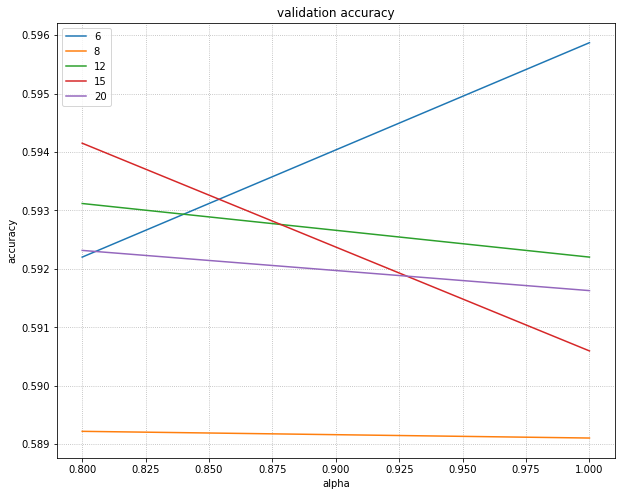

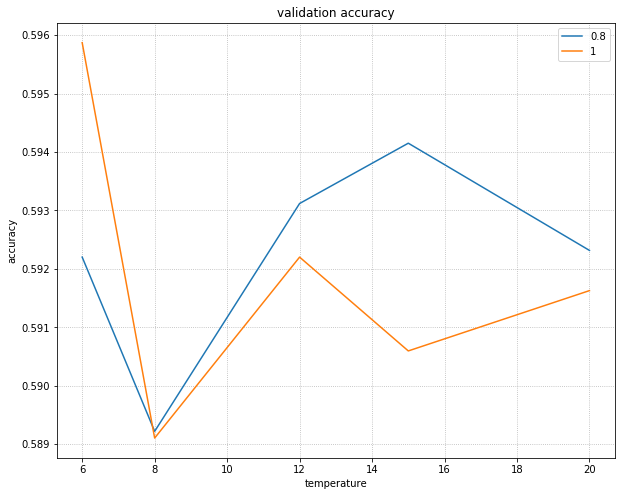

In [99]:
Ts = [6, 8, 12, 15, 20]
alphas = [0.8, 1]

T_scores_addition = defaultdict(lambda : [])
alpha_scores_addition = defaultdict(lambda : [])

for res in all_result_parameters_addition:
    T_scores_addition[res[0][0]].append([res[1], res[2], res[3]])
    alpha_scores_addition[res[0][1]].append([res[1], res[2], res[3]])

    
    
plt.figure(figsize=(10, 8))
for T in T_scores_addition.keys():
    plt.plot(alphas, (np.array(T_scores_addition[T])[:,2] + np.array(T_scores[T])[-2:,2]) / 2, label=str(T))
    
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.legend()
plt.title('validation accuracy')
plt.show();

plt.figure(figsize=(10, 8))
for alpha in alpha_scores_addition.keys():
    plt.plot(Ts, (np.array(alpha_scores_addition[alpha])[:,2] + np.array(alpha_scores[alpha])[-5:,2]) / 2, label=str(alpha))
    
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.title('validation accuracy')
plt.legend()
plt.show();


In [84]:
params['num_train_epochs'] = 25
params['train_batch_size'] = 256

Ts = [6, 10, 15]
alphas = [0.8, 0.9, 1]

different_params = product(Ts, alphas)
all_result_parameters_small_grid = []
count_experiments = 5
for param in list(different_params):
    cur_result = []
    mean_acc_val = 0
    mean_loss_val = 0
    mean_loss_train = 0
    for i in range(count_experiments):
        model = BlendCNN(params['max_seq_length'], len(tokenizer.vocab), len(params['label_list']), n_layers=8).to(params['device'])

        model, result = train_student(model, teacher_model, tokenizer, params, train_examples, 
                                      valid_examples=dev_examples, name='BlendCNN', 
                                      checkpoint_files=checkpoint_files, 
                                      all_logits_teacher=all_logits_teacher,
                                      temperature=param[0], alpha=param[1])
        
        mean_loss_val += result['eval_loss']
        mean_loss_train += result['train_loss']
        mean_acc_val += result['eval_accuracy']
    
    
    all_result_parameters_small_grid.append((param, mean_loss_train / count_experiments, mean_loss_val / count_experiments, 
                                   mean_acc_val / count_experiments))

    print('---------------------------------------------------------------------------------------')
    print('T = {}, alpha = {}, \n train_loss={}, eval_loss={}, eval_accuracy={}'.format(all_result_parameters_small_grid[-1][0][0], 
                                                                                        all_result_parameters_small_grid[-1][0][1],
                                                                                        all_result_parameters_small_grid[-1][1],
                                                                                        all_result_parameters_small_grid[-1][2],
                                                                                        all_result_parameters_small_grid[-1][3]))
    
    with open('all_result_parameters_small_grid.pickle', 'wb') as file:
        pickle.dump(all_result_parameters_small_grid, file)
    

***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6400878275885726, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.78it/s]

{'eval_loss': 0.7532416418741602, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6206965297460556, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.16it/s]

{'eval_loss': 0.7415687909025118, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.613923193378882, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.04it/s]

{'eval_loss': 0.7379122027836809, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6059858031345136, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.10it/s]

{'eval_loss': 0.7322049478427806, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5903501311937969, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.49it/s]

{'eval_loss': 0.7416645444912511, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.55354412577369, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.42it/s]

{'eval_loss': 0.7872619485747445, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6671961874503575, 'eval_matthews_corrcoef': 0.04661702010755758}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5059714272166744, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.55it/s]

{'eval_loss': 0.8228687824827722, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.657762938230384, 'eval_matthews_corrcoef': 0.06761571319977984}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4685858298431744, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.72it/s]

{'eval_loss': 0.8514183386733088, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6511627906976745, 'eval_matthews_corrcoef': 0.07753683007212665}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4395058859478345, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.52it/s]

{'eval_loss': 0.8686155263439179, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.657917760279965, 'eval_matthews_corrcoef': 0.11554733346149042}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4156252777937688, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.91it/s]

{'eval_loss': 0.8796631779274454, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6542553191489362, 'eval_matthews_corrcoef': 0.11560746356864308}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3953218189152805, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.94it/s]

{'eval_loss': 0.8913205463038447, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6594982078853047, 'eval_matthews_corrcoef': 0.1409644604973735}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.377640009377942, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.65it/s]

{'eval_loss': 0.903008186273595, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6606005459508644, 'eval_matthews_corrcoef': 0.15647304373644277}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3618050840767948, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.41it/s]

{'eval_loss': 0.9081367922398377, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6617781851512374, 'eval_matthews_corrcoef': 0.16548353143906797}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3476414757244515, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.28it/s]

{'eval_loss': 0.9024796882009352, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6604823747680891, 'eval_matthews_corrcoef': 0.17088030823035474}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3348788673227483, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.25it/s]

{'eval_loss': 0.8857074487045751, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6628679962013295, 'eval_matthews_corrcoef': 0.19449550474857924}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.32335973192345, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.93it/s]

{'eval_loss': 0.8645533817430954, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6567754698318495, 'eval_matthews_corrcoef': 0.2082721300717935}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3131056721463348, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.76it/s]

{'eval_loss': 0.8462874391506033, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6557711950970379, 'eval_matthews_corrcoef': 0.22891473708128846}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3038008745872613, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.27it/s]

{'eval_loss': 0.8428295622209948, 'eval_accuracy': 0.6169724770642202, 'eval_f1_score': 0.651356993736952, 'eval_matthews_corrcoef': 0.23448407163294752}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2952495330210887, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.86it/s]

{'eval_loss': 0.8622719894899985, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6531027466937944, 'eval_matthews_corrcoef': 0.21981300070375154}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2878404250650695, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.16it/s]

{'eval_loss': 0.8886326811654993, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6554121151936445, 'eval_matthews_corrcoef': 0.2078294555930315}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2814263195702524, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.28it/s]

{'eval_loss': 0.9008665241209877, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6554787759131293, 'eval_matthews_corrcoef': 0.20368486606737218}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2759491313587537, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.62it/s]

{'eval_loss': 0.8949734238813442, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6547263681592039, 'eval_matthews_corrcoef': 0.20761692755276753}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.271797772158276, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.47it/s]

{'eval_loss': 0.8857584818389289, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6532258064516129, 'eval_matthews_corrcoef': 0.21349472057411584}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2687732365095254, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.58it/s]

{'eval_loss': 0.885151984810764, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6504559270516718, 'eval_matthews_corrcoef': 0.21069018172219126}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2666536714091445, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.26it/s]


{'eval_loss': 0.8775415888539175, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6537282941777324, 'eval_matthews_corrcoef': 0.2242037569355582}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6400918838652698, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.54it/s]

{'eval_loss': 0.7529067347561, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6206621301896644, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.51it/s]

{'eval_loss': 0.7411135935113518, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6139060972314891, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.78it/s]

{'eval_loss': 0.7376608366676427, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6061021175348398, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.85it/s]

{'eval_loss': 0.732114316400038, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.591077699805751, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.50it/s]

{'eval_loss': 0.737272168714724, 'eval_accuracy': 0.5137614678899083, 'eval_f1_score': 0.6763358778625953, 'eval_matthews_corrcoef': 0.05702825259599388}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5556648296840263, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.41it/s]

{'eval_loss': 0.7855656146469159, 'eval_accuracy': 0.5229357798165137, 'eval_f1_score': 0.6708860759493671, 'eval_matthews_corrcoef': 0.06274407490495978}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5084580490083406, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.55it/s]

{'eval_loss': 0.8170137854876134, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6555462885738115, 'eval_matthews_corrcoef': 0.057701820637581065}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4710735069079832, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.29it/s]

{'eval_loss': 0.8433060792884619, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6575107296137339, 'eval_matthews_corrcoef': 0.09630370758703148}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4419756238207673, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.11it/s]

{'eval_loss': 0.865209272662135, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6514886164623468, 'eval_matthews_corrcoef': 0.0952604982767461}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.418266676140554, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 618.04it/s]

{'eval_loss': 0.8777480833635585, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6554472984942427, 'eval_matthews_corrcoef': 0.11857476423987304}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.398166566635623, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.75it/s]

{'eval_loss': 0.8874153318053161, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6576576576576577, 'eval_matthews_corrcoef': 0.13981794093060987}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3807415894486688, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.67it/s]

{'eval_loss': 0.8970255614343792, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6606005459508644, 'eval_matthews_corrcoef': 0.15647304373644277}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.365223846652291, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.59it/s]

{'eval_loss': 0.8988619400590173, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6642268984446478, 'eval_matthews_corrcoef': 0.17112924788833092}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3513526311426451, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 617.42it/s]

{'eval_loss': 0.8888161660177653, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6641860465116279, 'eval_matthews_corrcoef': 0.1831816800196893}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3387464506156517, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.40it/s]

{'eval_loss': 0.8702619825965092, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.21239761958421766}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3274514923493068, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.20it/s]

{'eval_loss': 0.8533695582491335, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6593625498007968, 'eval_matthews_corrcoef': 0.21947671114063752}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3174795273578528, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.16it/s]

{'eval_loss': 0.8402912205356438, 'eval_accuracy': 0.6181192660550459, 'eval_f1_score': 0.6584615384615384, 'eval_matthews_corrcoef': 0.23799794890905845}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.308451275030772, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.99it/s]

{'eval_loss': 0.8408927103024458, 'eval_accuracy': 0.6192660550458715, 'eval_f1_score': 0.6541666666666668, 'eval_matthews_corrcoef': 0.23926719875316624}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3001982136206194, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.35it/s]

{'eval_loss': 0.8629797515618228, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6572008113590263, 'eval_matthews_corrcoef': 0.22716252648763374}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2930233880425945, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.20it/s]

{'eval_loss': 0.8869764769015008, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6646766169154229, 'eval_matthews_corrcoef': 0.23156174302547058}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2866984768347307, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.58it/s]

{'eval_loss': 0.895767340083794, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6679841897233201, 'eval_matthews_corrcoef': 0.23486266836702105}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.281394888505791, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.33it/s]

{'eval_loss': 0.8910495818646277, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6646706586826349, 'eval_matthews_corrcoef': 0.23359250828228634}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2775109044530175, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.36it/s]

{'eval_loss': 0.8814556801932225, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6606060606060606, 'eval_matthews_corrcoef': 0.23228050045930795}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2745376631165997, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.30it/s]

{'eval_loss': 0.8805707566228635, 'eval_accuracy': 0.6169724770642202, 'eval_f1_score': 0.6619433198380568, 'eval_matthews_corrcoef': 0.2368189372007337}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2723955512046814, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.08it/s]


{'eval_loss': 0.8741426883985496, 'eval_accuracy': 0.6181192660550459, 'eval_f1_score': 0.6598569969356486, 'eval_matthews_corrcoef': 0.23833669737274904}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6401021548292853, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.23it/s]

{'eval_loss': 0.7531044098693843, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6208130902413167, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.88it/s]

{'eval_loss': 0.7410900429267129, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6140259445616694, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.80it/s]

{'eval_loss': 0.7380123573500629, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6062763784870957, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.18it/s]

{'eval_loss': 0.732187095294715, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5912572005481431, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.60it/s]

{'eval_loss': 0.7386648740978279, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6758199847444699, 'eval_matthews_corrcoef': 0.04696582675065622}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5556532808325507, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.48it/s]

{'eval_loss': 0.786962845262328, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6687847498014298, 'eval_matthews_corrcoef': 0.055897851507966306}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5081844799446338, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.49it/s]

{'eval_loss': 0.822012395691981, 'eval_accuracy': 0.5275229357798165, 'eval_f1_score': 0.6566666666666667, 'eval_matthews_corrcoef': 0.061227097171044916}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4712187548478444, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.10it/s]

{'eval_loss': 0.8480573439075603, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6535500427715997, 'eval_matthews_corrcoef': 0.07872851503567363}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4423921979738004, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.64it/s]

{'eval_loss': 0.863302473598021, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6537444933920705, 'eval_matthews_corrcoef': 0.10837591717876832}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4185080261844578, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.23it/s]

{'eval_loss': 0.8749532212934205, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.658886894075404, 'eval_matthews_corrcoef': 0.14057384378131416}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3981640040874481, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.83it/s]

{'eval_loss': 0.8830342043971925, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6612318840579711, 'eval_matthews_corrcoef': 0.15478757015633843}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3804706407315803, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.90it/s]

{'eval_loss': 0.8913718070729407, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6618049225159526, 'eval_matthews_corrcoef': 0.16138193615406166}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.364766395904801, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.51it/s]

{'eval_loss': 0.8958935332573991, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6599078341013825, 'eval_matthews_corrcoef': 0.1643689934079418}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.350641899488189, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]609.59it/s]


{'train_loss': 1.620680489323356, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.55it/s]

{'eval_loss': 0.7413284251415128, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6139504367654973, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.43it/s]

{'eval_loss': 0.7383050066888879, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6060521083347725, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.07it/s]

{'eval_loss': 0.7324313518309266, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5907288780718138, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.12it/s]

{'eval_loss': 0.739992784079882, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6758199847444699, 'eval_matthews_corrcoef': 0.04696582675065622}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5547135585185252, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.00it/s]

{'eval_loss': 0.7885247700070159, 'eval_accuracy': 0.5240825688073395, 'eval_f1_score': 0.6708961141950832, 'eval_matthews_corrcoef': 0.06609875597069263}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5074746784838764, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.70it/s]

{'eval_loss': 0.8235275361413529, 'eval_accuracy': 0.533256880733945, 'eval_f1_score': 0.6605504587155963, 'eval_matthews_corrcoef': 0.07789282689599626}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4703227078372783, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.44it/s]

{'eval_loss': 0.8503093144412093, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6540772532188841, 'eval_matthews_corrcoef': 0.0841788399843905}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4414284256371586, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.15it/s]

{'eval_loss': 0.8698746275577006, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6567685589519652, 'eval_matthews_corrcoef': 0.11017158108602998}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.417712643291011, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.15it/s]

{'eval_loss': 0.8845815723433497, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6578014184397163, 'eval_matthews_corrcoef': 0.126763916449548}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3976310541232426, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.79it/s]

{'eval_loss': 0.8958307550959727, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6612758310871518, 'eval_matthews_corrcoef': 0.14852377939689332}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3799672478979284, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.62it/s]

{'eval_loss': 0.9056444241144105, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.663023679417122, 'eval_matthews_corrcoef': 0.16422818311658519}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3642320104620673, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.12it/s]

{'eval_loss': 0.9083755572207396, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6605166051660516, 'eval_matthews_corrcoef': 0.1667856876005036}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3502371839501641, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.03it/s]

{'eval_loss': 0.8999693493070156, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6610328638497652, 'eval_matthews_corrcoef': 0.18139982691380452}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3375702017184459, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.69it/s]

{'eval_loss': 0.8794995082193588, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6576923076923076, 'eval_matthews_corrcoef': 0.19004140691246227}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3262031444094398, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 583.25it/s]

{'eval_loss': 0.8563611291789763, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6600199401794616, 'eval_matthews_corrcoef': 0.22175669766335263}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.31606408050566, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.57it/s]

{'eval_loss': 0.8415536255568508, 'eval_accuracy': 0.6158256880733946, 'eval_f1_score': 0.6535677352637022, 'eval_matthews_corrcoef': 0.23270835678485327}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3068287467414683, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.90it/s]

{'eval_loss': 0.8449487601186056, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6507276507276507, 'eval_matthews_corrcoef': 0.23005019922531258}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2984809821302241, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.71it/s]

{'eval_loss': 0.8704500539391729, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6585858585858586, 'eval_matthews_corrcoef': 0.22753919436379025}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2912044443867423, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.92it/s]

{'eval_loss': 0.8918546044334199, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6607319485657764, 'eval_matthews_corrcoef': 0.21789249755895335}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2848487970503895, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.54it/s]

{'eval_loss': 0.9004867794508822, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6633858267716537, 'eval_matthews_corrcoef': 0.22093134876412543}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.2795314594651714, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.40it/s]

{'eval_loss': 0.8932050957145284, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6640159045725647, 'eval_matthews_corrcoef': 0.22928831643988262}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.43161032687534, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.40it/s]

{'eval_loss': 0.9233818554989364, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6572504708097928, 'eval_matthews_corrcoef': 0.17332823105464087}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4180343327197162, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.78it/s]

{'eval_loss': 0.899682064742275, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6627906976744186, 'eval_matthews_corrcoef': 0.20855518686981414}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4057876259991617, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.26it/s]

{'eval_loss': 0.8785528675325956, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6573426573426573, 'eval_matthews_corrcoef': 0.21676020138255628}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3948554780447122, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.18it/s]

{'eval_loss': 0.865842501975974, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6515463917525773, 'eval_matthews_corrcoef': 0.22588516742336132}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3849372990203626, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.68it/s]

{'eval_loss': 0.8667486725507759, 'eval_accuracy': 0.6181192660550459, 'eval_f1_score': 0.652037617554859, 'eval_matthews_corrcoef': 0.23675873715892923}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3759510937062176, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.93it/s]

{'eval_loss': 0.892903309113118, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6531440162271804, 'eval_matthews_corrcoef': 0.2177028453464104}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.36814261701974, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.59it/s]

{'eval_loss': 0.9210863823692983, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.658102766798419, 'eval_matthews_corrcoef': 0.210793440412898}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3611551428383046, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.73it/s]

{'eval_loss': 0.9277087925781641, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6587537091988129, 'eval_matthews_corrcoef': 0.2130823138153734}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3553558565450436, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 578.39it/s]

{'eval_loss': 0.9222533347395782, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.653961885656971, 'eval_matthews_corrcoef': 0.2115866875621188}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3509453806010159, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.78it/s]

{'eval_loss': 0.9111901126630949, 'eval_accuracy': 0.6169724770642202, 'eval_f1_score': 0.6591836734693878, 'eval_matthews_corrcoef': 0.2360683030652311}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3478132278630228, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.81it/s]

{'eval_loss': 0.9106115372008414, 'eval_accuracy': 0.6158256880733946, 'eval_f1_score': 0.6578140960163432, 'eval_matthews_corrcoef': 0.23362571722701875}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.345575106866432, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.63it/s]


{'eval_loss': 0.9029903357060586, 'eval_accuracy': 0.6181192660550459, 'eval_f1_score': 0.65775950668037, 'eval_matthews_corrcoef': 0.2378373928912177}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7554528496482156, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.20it/s]

{'eval_loss': 0.7738167694470751, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7323338064280422, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.61it/s]

{'eval_loss': 0.7566429233571531, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7244615148414264, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.83it/s]

{'eval_loss': 0.7531646634494766, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7157785598978852, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.22it/s]

{'eval_loss': 0.7471846437013341, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6985641866922379, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.67it/s]

{'eval_loss': 0.7541353590017476, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6561472573966691, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.23it/s]

{'eval_loss': 0.826512101012359, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6713836477987422, 'eval_matthews_corrcoef': 0.05663050123599473}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6016092792604908, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.51it/s]

{'eval_loss': 0.8711170377984104, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.662828947368421, 'eval_matthews_corrcoef': 0.07139925187059241}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5609956008918358, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.41it/s]

{'eval_loss': 0.8967409101718025, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6587637595258257, 'eval_matthews_corrcoef': 0.08712500585915606}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.529392710237792, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.65it/s]

{'eval_loss': 0.9053552576670222, 'eval_accuracy': 0.5458715596330275, 'eval_f1_score': 0.65684575389948, 'eval_matthews_corrcoef': 0.10313660516279692}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.4480727405259104, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.55it/s]

{'eval_loss': 0.9349508843233957, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6592517694641052, 'eval_matthews_corrcoef': 0.229812012794754}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.439591433062698, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.33it/s]

{'eval_loss': 0.9575727114616386, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6580259222333001, 'eval_matthews_corrcoef': 0.21697452731113076}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.43194537496928, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.85it/s]

{'eval_loss': 0.9637206665379339, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6620139581256231, 'eval_matthews_corrcoef': 0.2265388680155745}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4257292878447156, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.19it/s]

{'eval_loss': 0.9584014168407137, 'eval_accuracy': 0.6158256880733946, 'eval_f1_score': 0.6633165829145728, 'eval_matthews_corrcoef': 0.23517804621261584}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.42103798642303, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.26it/s]

{'eval_loss': 0.9490340208344897, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6578411405295316, 'eval_matthews_corrcoef': 0.23152806639556994}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4175414131446318, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.11it/s]

{'eval_loss': 0.9484175633183983, 'eval_accuracy': 0.6158256880733946, 'eval_f1_score': 0.6571136131013307, 'eval_matthews_corrcoef': 0.23345850060434897}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4151025513807933, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.83it/s]


{'eval_loss': 0.9401526523615423, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6521739130434783, 'eval_matthews_corrcoef': 0.2303011533560759}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8692957641500416, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.30it/s]

{'eval_loss': 0.8017247991995253, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8417493773229194, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.95it/s]

{'eval_loss': 0.7771854848524026, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8326878172881675, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.95it/s]

{'eval_loss': 0.7728748201828347, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.823173677830985, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.09it/s]

{'eval_loss': 0.7667399345546824, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8035108429012876, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.75it/s]

{'eval_loss': 0.7754035495059274, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7518691217357463, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.51it/s]

{'eval_loss': 0.8661086573415017, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6682501979414094, 'eval_matthews_corrcoef': 0.047873621316215545}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6904047217332956, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.72it/s]

{'eval_loss': 0.9173669474019985, 'eval_accuracy': 0.533256880733945, 'eval_f1_score': 0.6611157368859283, 'eval_matthews_corrcoef': 0.07833898302097454}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6464581069621174, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.60it/s]

{'eval_loss': 0.9473435158444539, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6604095563139932, 'eval_matthews_corrcoef': 0.1008336828859657}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.612824623331879, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.42it/s]

{'eval_loss': 0.9465534167974086, 'eval_accuracy': 0.5493119266055045, 'eval_f1_score': 0.6549604916593503, 'eval_matthews_corrcoef': 0.10906853541414871}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5853401946299004, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.25it/s]

{'eval_loss': 0.9519302765845477, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6565836298932384, 'eval_matthews_corrcoef': 0.12600805585285196}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.562018080642729, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.75it/s]

{'eval_loss': 0.9658478436841514, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.654054054054054, 'eval_matthews_corrcoef': 0.1290169802208746}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5415999108191691, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.83it/s]

{'eval_loss': 0.9763534095548435, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6575342465753425, 'eval_matthews_corrcoef': 0.150445966077301}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5234705169092526, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.75it/s]

{'eval_loss': 0.9745148523045019, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6623496762257169, 'eval_matthews_corrcoef': 0.17400490612728545}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.507255390737996, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.96it/s]

{'eval_loss': 0.9576191534207458, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6590693257359924, 'eval_matthews_corrcoef': 0.18449903650970376}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.7534756330829677, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.28it/s]

{'eval_loss': 0.751186634063584, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.745862793741804, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.08it/s]

{'eval_loss': 0.7476493552190449, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.737263802777637, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.83it/s]

{'eval_loss': 0.741479883978673, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7198425432046254, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.30it/s]

{'eval_loss': 0.7512880488119404, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6766514069203176, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.98it/s]

{'eval_loss': 0.810994906060466, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6724821570182395, 'eval_matthews_corrcoef': 0.07553525158405937}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6227011703180545, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.40it/s]

{'eval_loss': 0.8492315635058405, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6666666666666667, 'eval_matthews_corrcoef': 0.09425916786452844}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.582089339241837, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.54it/s]

{'eval_loss': 0.8787949634099127, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6638225255972697, 'eval_matthews_corrcoef': 0.11318991833798397}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5507193117430715, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.06it/s]

{'eval_loss': 0.8901768634667184, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6578715919085312, 'eval_matthews_corrcoef': 0.12007710178109263}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.524979887135101, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.37it/s]

{'eval_loss': 0.9012599171664237, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6625, 'eval_matthews_corrcoef': 0.14726745809282754}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5033739200144103, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.21it/s]

{'eval_loss': 0.9137758938339325, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6642664266426641, 'eval_matthews_corrcoef': 0.15893732830253351}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4845272930282536, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.49it/s]

{'eval_loss': 0.9233789485186358, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6642468239564429, 'eval_matthews_corrcoef': 0.16505571305520125}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4677412419608145, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.93it/s]

{'eval_loss': 0.9170050522408111, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6654309545875811, 'eval_matthews_corrcoef': 0.18394910751820262}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4526544177170955, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 603.19it/s]

{'eval_loss': 0.8977910660369078, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6628571428571428, 'eval_matthews_corrcoef': 0.19650198061530844}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4389624211824301, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.62it/s]

{'eval_loss': 0.877002440651835, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6679764243614932, 'eval_matthews_corrcoef': 0.23086939511874832}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.426849286664616, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.53it/s]

{'eval_loss': 0.8587610421298016, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6579212916246217, 'eval_matthews_corrcoef': 0.225264931104253}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.415890885573445, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.65it/s]

{'eval_loss': 0.848991856494958, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6480331262939959, 'eval_matthews_corrcoef': 0.22094141222415487}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4058441041093883, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.19it/s]

{'eval_loss': 0.8534935085831046, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6458982346832814, 'eval_matthews_corrcoef': 0.2184274181606408}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3967161919131423, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.94it/s]

{'eval_loss': 0.8809202798458516, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6531850353892821, 'eval_matthews_corrcoef': 0.21559683674559396}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3888730704784393, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.42it/s]

{'eval_loss': 0.9042270645233423, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6607142857142857, 'eval_matthews_corrcoef': 0.219936444394906}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3817892386154695, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.30it/s]

{'eval_loss': 0.910970300604969, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6594059405940594, 'eval_matthews_corrcoef': 0.21536907553730203}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.375879047494946, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.07it/s]

{'eval_loss': 0.9063886375482346, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6573705179282868, 'eval_matthews_corrcoef': 0.21469116172788907}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.576235493927291, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.68it/s]

{'eval_loss': 0.9565548569735256, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6642335766423357, 'eval_matthews_corrcoef': 0.16910907191846775}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5573994463140315, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.30it/s]

{'eval_loss': 0.9545540770282435, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6623376623376624, 'eval_matthews_corrcoef': 0.17602986686931207}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5406285831422517, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.59it/s]

{'eval_loss': 0.9360240638202538, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.662251655629139, 'eval_matthews_corrcoef': 0.19014669756438338}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5254210287874395, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.61it/s]

{'eval_loss': 0.9208195813870247, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6660194174757281, 'eval_matthews_corrcoef': 0.21804109737768437}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5119034643426086, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.37it/s]

{'eval_loss': 0.9026372739813561, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6565656565656567, 'eval_matthews_corrcoef': 0.22279788826827254}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4997197768904946, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.52it/s]

{'eval_loss': 0.8937112851718675, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6508264462809917, 'eval_matthews_corrcoef': 0.22575051657620498}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4888440429261236, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.00it/s]

{'eval_loss': 0.8997321960278905, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.65015479876161, 'eval_matthews_corrcoef': 0.2234738578543679}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4788992960344662, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.85it/s]

{'eval_loss': 0.9338781746821809, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.657286432160804, 'eval_matthews_corrcoef': 0.22090896353119355}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4700737171100848, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.31it/s]

{'eval_loss': 0.9561446996356592, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6580773042616452, 'eval_matthews_corrcoef': 0.21285080265280698}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.462052204392173, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.94it/s]

{'eval_loss': 0.9629569295537445, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6554455445544556, 'eval_matthews_corrcoef': 0.20575595955304082}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.455504855874813, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.67it/s]

{'eval_loss': 0.9604228364657226, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6567164179104478, 'eval_matthews_corrcoef': 0.21240589064730814}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4506382580959436, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.44it/s]

{'eval_loss': 0.9485672278720362, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.655241935483871, 'eval_matthews_corrcoef': 0.21824195120295684}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4470218541947277, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.83it/s]

{'eval_loss': 0.9465462348388253, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6538461538461539, 'eval_matthews_corrcoef': 0.21787689782822958}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.444476754827933, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.41it/s]


{'eval_loss': 0.9391367140740323, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6517311608961304, 'eval_matthews_corrcoef': 0.21737143256771815}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9070155051621525, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.68it/s]

{'eval_loss': 0.7909240663871853, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8801473148844459, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.10it/s]

{'eval_loss': 0.7698590364648935, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8711961688417378, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.48it/s]

{'eval_loss': 0.7661196726605023, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8616108352487737, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 616.21it/s]

{'eval_loss': 0.7605475430129045, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8422622391671846, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.96it/s]

{'eval_loss': 0.7662540909859838, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."



{'train_loss': 1.7920076598723729, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.86it/s]

{'eval_loss': 0.8486486310513109, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6682464454976303, 'eval_matthews_corrcoef': 0.04399385061113716}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7308194971445836, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.72it/s]

{'eval_loss': 0.8924535802515318, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.6622296173044925, 'eval_matthews_corrcoef': 0.08196988296941493}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP

../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5033479183912277, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.68it/s]

{'eval_loss': 0.8832160741873241, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.64797507788162, 'eval_matthews_corrcoef': 0.22310080879358019}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.492597257097562, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.59it/s]

{'eval_loss': 0.8850871237461325, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6442812172088143, 'eval_matthews_corrcoef': 0.22258392254668863}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.48295085086967, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.95it/s]

{'eval_loss': 0.9136267188684684, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6551724137931034, 'eval_matthews_corrcoef': 0.2224326859170221}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4744204485958272, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.74it/s]

{'eval_loss': 0.941659744401527, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6528599605522682, 'eval_matthews_corrcoef': 0.19656661928907387}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4667524596055348, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.31it/s]

{'eval_loss': 0.946769127336148, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6541501976284585, 'eval_matthews_corrcoef': 0.20116574923124877}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4604435617273503, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.58it/s]

{'eval_loss': 0.9411260111876492, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6600199401794616, 'eval_matthews_corrcoef': 0.22175669766335263}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.455681897925608, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.18it/s]

{'eval_loss': 0.930082768309165, 'eval_accuracy': 0.6169724770642202, 'eval_f1_score': 0.659877800407332, 'eval_matthews_corrcoef': 0.23624694433818721}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.45213197081378, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.62it/s]

{'eval_loss': 0.9300245091819991, 'eval_accuracy': 0.6158256880733946, 'eval_f1_score': 0.6585117227319063, 'eval_matthews_corrcoef': 0.2337987725984034}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.449644058039694, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.18it/s]


{'eval_loss': 0.920718901826324, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6494312306101344, 'eval_matthews_corrcoef': 0.22334418109881765}
---------------------------------------------------------------------------------------
T = 10, alpha = 0.9, 
 train_loss=1.4476733538237485, eval_loss=0.925887186211218, eval_accuracy=0.6091743119266055
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0364827825264498, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.89it/s]

{'eval_loss': 0.8242000742653094, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0042546639839807, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.57it/s]

{'eval_loss': 0.7957098581956341, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.993947613871459, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.87it/s]

{'eval_loss': 0.7894167738001144, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9835034608840942, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.52it/s]

{'eval_loss': 0.7840894725293331, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9613573745344624, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.14it/s]

{'eval_loss': 0.7935913790726539, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9010748131708666, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.56it/s]

{'eval_loss': 0.9002834929979979, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6682427107959023, 'eval_matthews_corrcoef': 0.03993480245406702}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8324589029406055, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.94it/s]

{'eval_loss': 0.9514120056004468, 'eval_accuracy': 0.5263761467889908, 'eval_f1_score': 0.6606409202958093, 'eval_matthews_corrcoef': 0.060799742853120745}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7843961955019922, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.92it/s]

{'eval_loss': 0.9674130689389865, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6626712328767124, 'eval_matthews_corrcoef': 0.11218209992645131}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7468759164665684, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.88it/s]

{'eval_loss': 0.9656300123312634, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6560565870910698, 'eval_matthews_corrcoef': 0.11893737728731792}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7163800565582332, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.82it/s]

{'eval_loss': 0.9742395915913421, 'eval_accuracy': 0.5561926605504587, 'eval_f1_score': 0.6516651665166516, 'eval_matthews_corrcoef': 0.12107029270695722}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6905286632704013, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.54it/s]

{'eval_loss': 0.9860824377497887, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6551094890510949, 'eval_matthews_corrcoef': 0.14270092171916549}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
IOP


{'train_loss': 1.9937195674036488, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.92it/s]

{'eval_loss': 0.7899673880855425, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9829407492370317, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.22it/s]

{'eval_loss': 0.7836711338524698, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.960065999265873, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.04it/s]

{'eval_loss': 0.7940348549660534, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8997143114154988, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.27it/s]

{'eval_loss': 0.9003669258726146, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6682501979414094, 'eval_matthews_corrcoef': 0.047873621316215545}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.83230900312915, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.58it/s]

{'eval_loss': 0.9561490251403942, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6661170651277823, 'eval_matthews_corrcoef': 0.08845342080625969}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.784810466296745, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.61it/s]

{'eval_loss': 0.9710989107944952, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6593220338983051, 'eval_matthews_corrcoef': 0.09008235095471451}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.747773345672723, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.81it/s]

{'eval_loss': 0.9676145959941621, 'eval_accuracy': 0.5596330275229358, 'eval_f1_score': 0.6625659050966608, 'eval_matthews_corrcoef': 0.1345032380508702}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7173926834807252, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.24it/s]

{'eval_loss': 0.9699811497970202, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6642728904847397, 'eval_matthews_corrcoef': 0.15688599669703088}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6916687497586915, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.42it/s]

{'eval_loss': 0.9810194008038599, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6624434389140272, 'eval_matthews_corrcoef': 0.1576655113459845}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6690715876492588, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.38it/s]

{'eval_loss': 0.9931310588453759, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6623970722781336, 'eval_matthews_corrcoef': 0.16587115401381985}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.648900973074364, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.49it/s]

{'eval_loss': 0.9886795009530166, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6635687732342008, 'eval_matthews_corrcoef': 0.18080242729234747}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6305963667956265, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.01it/s]

{'eval_loss': 0.9724664160838391, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.662878787878788, 'eval_matthews_corrcoef': 0.19248899641928371}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6141597642139955, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.90it/s]

{'eval_loss': 0.9557738166292831, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6537342386032978, 'eval_matthews_corrcoef': 0.1864034302501314}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5995266785224278, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.55it/s]

{'eval_loss': 0.9382894492579716, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6541501976284585, 'eval_matthews_corrcoef': 0.20116574923124877}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5864791626280004, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.86it/s]

{'eval_loss': 0.9212282800237533, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6497975708502025, 'eval_matthews_corrcoef': 0.20840587814197753}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5744101639949915, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.29it/s]

{'eval_loss': 0.9267151412310307, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6511156186612576, 'eval_matthews_corrcoef': 0.21297300477579875}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5638018440116535, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.44it/s]

{'eval_loss': 0.9688934495702889, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6561264822134388, 'eval_matthews_corrcoef': 0.20597959482207337}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.554282015020197, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.96it/s]

{'eval_loss': 0.9851729317541942, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6548323471400395, 'eval_matthews_corrcoef': 0.201387897754985}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.545618087053299, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.57it/s]

{'eval_loss': 0.9953063637039697, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6535433070866142, 'eval_matthews_corrcoef': 0.19678705658918091}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5385855472449101, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.47it/s]

{'eval_loss': 0.9941190564629132, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6548323471400395, 'eval_matthews_corrcoef': 0.201387897754985}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5333549709934178, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.05it/s]

{'eval_loss': 0.9810210701377625, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6553784860557769, 'eval_matthews_corrcoef': 0.20990561231514063}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5294328891869746, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.19it/s]

{'eval_loss': 0.9761737363675712, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6559679037111334, 'eval_matthews_corrcoef': 0.21634929963114738}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5266887947465435, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.48it/s]


{'eval_loss': 0.9635064930196744, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6537282941777324, 'eval_matthews_corrcoef': 0.2242037569355582}
---------------------------------------------------------------------------------------
T = 10, alpha = 1, 
 train_loss=1.5259989427797722, eval_loss=0.9662104313384632, eval_accuracy=0.6089449541284403
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8229860424092321, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.40it/s]

{'eval_loss': 0.7693199000295696, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7996447578524097, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.00it/s]

{'eval_loss': 0.7546559841021758, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7917157145160618, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.61it/s]

{'eval_loss': 0.7517052946287558, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7828076621799758, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.69it/s]

{'eval_loss': 0.7457357892817861, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7655242013208794, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.07it/s]

{'eval_loss': 0.75069227163603, 'eval_accuracy': 0.5114678899082569, 'eval_f1_score': 0.6753048780487805, 'eval_matthews_corrcoef': 0.03519372228339802}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7232103943824768, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.88it/s]

{'eval_loss': 0.8187574637368099, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6724273369992144, 'eval_matthews_corrcoef': 0.06245083598866863}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6675053803306636, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.87it/s]

{'eval_loss': 0.8572164029881589, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6650124069478909, 'eval_matthews_corrcoef': 0.08726750451152838}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.625048060308803, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.05it/s]

{'eval_loss': 0.8857342987930095, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6581849024597116, 'eval_matthews_corrcoef': 0.08671997308490936}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5920914059335536, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.52it/s]

{'eval_loss': 0.8987868925307689, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6585152838427948, 'eval_matthews_corrcoef': 0.11594916219662765}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5649650796796337, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.64it/s]

{'eval_loss': 0.9122632834893478, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6589902568644819, 'eval_matthews_corrcoef': 0.12975283931199946}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5420892703713793, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.51it/s]

{'eval_loss': 0.9243506788240891, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.658886894075404, 'eval_matthews_corrcoef': 0.14057384378131416}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5222560262138194, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.20it/s]

{'eval_loss': 0.9338531074057538, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6582278481012658, 'eval_matthews_corrcoef': 0.14445949120804058}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.50461968915029, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.43it/s]

{'eval_loss': 0.9395835037730231, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6587155963302752, 'eval_matthews_corrcoef': 0.15744000253909002}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.488830860365521, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.09it/s]

{'eval_loss': 0.9322725603246282, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6598322460391426, 'eval_matthews_corrcoef': 0.17257692572015326}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.474473980791641, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.48it/s]

{'eval_loss': 0.9109889296157293, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6525505293551491, 'eval_matthews_corrcoef': 0.17758447983168052}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4615082916888325, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.85it/s]

{'eval_loss': 0.8857687582488016, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.658102766798419, 'eval_matthews_corrcoef': 0.210793440412898}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4500266376769904, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.36it/s]

{'eval_loss': 0.8666469219216538, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6523076923076924, 'eval_matthews_corrcoef': 0.22389532513570298}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4396110267350168, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.16it/s]

{'eval_loss': 0.8654457620888283, 'eval_accuracy': 0.6181192660550459, 'eval_f1_score': 0.6542056074766355, 'eval_matthews_corrcoef': 0.23712098069239843}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4300932315262882, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.19it/s]

{'eval_loss': 0.8911081169122603, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6524390243902439, 'eval_matthews_corrcoef': 0.21753437348915655}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4218290687510462, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.02it/s]

{'eval_loss': 0.9189421178101789, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6514399205561073, 'eval_matthews_corrcoef': 0.19823766532749093}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4145309667695651, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.47it/s]

{'eval_loss': 0.9261019978942745, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6534653465346535, 'eval_matthews_corrcoef': 0.2009494015609102}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4084725127075657, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.92it/s]

{'eval_loss': 0.9225711598800103, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6546546546546547, 'eval_matthews_corrcoef': 0.21178281626936069}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4039519673044032, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.73it/s]

{'eval_loss': 0.913621051565273, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6498486377396568, 'eval_matthews_corrcoef': 0.20628792212706157}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4006742798920833, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.02it/s]

{'eval_loss': 0.9137096957343235, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6511627906976745, 'eval_matthews_corrcoef': 0.21085844472920728}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3983431688763879, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.55it/s]


{'eval_loss': 0.9060066894813945, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6571428571428571, 'eval_matthews_corrcoef': 0.2313547209010783}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8229742506236741, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.03it/s]

{'eval_loss': 0.7691923896653936, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7995957240010754, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.37it/s]

{'eval_loss': 0.7542949934242242, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.791666689695734, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.06it/s]

{'eval_loss': 0.7515766887387277, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7827353441354, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.28it/s]

{'eval_loss': 0.7456565867049978, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7649731843760519, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.42it/s]

{'eval_loss': 0.7517262262745051, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6758199847444699, 'eval_matthews_corrcoef': 0.04696582675065622}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.721967777519515, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.42it/s]

{'eval_loss': 0.8227894186659571, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6703383162863886, 'eval_matthews_corrcoef': 0.05094212778757934}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6667598720752832, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.27it/s]

{'eval_loss': 0.8605272099135418, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6600496277915634, 'eval_matthews_corrcoef': 0.06629251445252818}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6248319605083177, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.63it/s]

{'eval_loss': 0.8885646723779538, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6575576430401366, 'eval_matthews_corrcoef': 0.0913694729640897}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5920120748606594, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.53it/s]

{'eval_loss': 0.899395393287104, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6520595968448729, 'eval_matthews_corrcoef': 0.09797236498273372}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.565155202240655, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.74it/s]

{'eval_loss': 0.9130138594373086, 'eval_accuracy': 0.5527522935779816, 'eval_f1_score': 0.6536412078152752, 'eval_matthews_corrcoef': 0.11526784981013465}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5426470587650936, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.24it/s]

{'eval_loss': 0.9256025349188365, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6576576576576577, 'eval_matthews_corrcoef': 0.13981794093060987}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5228874078302672, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.55it/s]

{'eval_loss': 0.9347221448031199, 'eval_accuracy': 0.5711009174311926, 'eval_f1_score': 0.6593806921675774, 'eval_matthews_corrcoef': 0.15363281646390226}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5051442664681058, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.65it/s]

{'eval_loss': 0.9344967475433704, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6592797783933518, 'eval_matthews_corrcoef': 0.1640130701285909}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4892699614618763, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.57it/s]

{'eval_loss': 0.919258849780567, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6610009442870634, 'eval_matthews_corrcoef': 0.18545066001404537}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4749144911766052, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.97it/s]

{'eval_loss': 0.9004092906943363, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.658252427184466, 'eval_matthews_corrcoef': 0.19849629506340183}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.462082991997401, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.03it/s]

{'eval_loss': 0.8805469147804398, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6486486486486488, 'eval_matthews_corrcoef': 0.19747582713185816}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4507605767611302, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.33it/s]

{'eval_loss': 0.8648961847849616, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6426364572605561, 'eval_matthews_corrcoef': 0.20484392722308203}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.440393806406946, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.86it/s]

{'eval_loss': 0.8639001985782904, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6416666666666666, 'eval_matthews_corrcoef': 0.21126420161920584}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.430986813975103, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.56it/s]

{'eval_loss': 0.8883334498585084, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6441717791411042, 'eval_matthews_corrcoef': 0.20293672676680846}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4227521898168507, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.73it/s]

{'eval_loss': 0.917318569437599, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.651394422310757, 'eval_matthews_corrcoef': 0.20033451348964373}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.415452376459584, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.29it/s]

{'eval_loss': 0.9233331166008469, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.654037886340977, 'eval_matthews_corrcoef': 0.207410186606687}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4093163185047382, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.13it/s]

{'eval_loss': 0.9197264495255653, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6533066132264529, 'eval_matthews_corrcoef': 0.20930114421102058}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4047266348744885, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.00it/s]

{'eval_loss': 0.9103509917107775, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.651866801210898, 'eval_matthews_corrcoef': 0.21103217437135943}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4015130698680878, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.92it/s]

{'eval_loss': 0.9095005233573312, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6531850353892821, 'eval_matthews_corrcoef': 0.21559683674559396}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3991534289988605, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.98it/s]


{'eval_loss': 0.9007148530537561, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6495901639344263, 'eval_matthews_corrcoef': 0.2169153210641}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8229859778375337, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.27it/s]

{'eval_loss': 0.7696830352785391, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7996368069540372, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.96it/s]

{'eval_loss': 0.7545216435036801, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7916857049320682, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.05it/s]

{'eval_loss': 0.751392581115622, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7827200578017668, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.92it/s]

{'eval_loss': 0.745502552769463, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7647477474176523, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.42it/s]

{'eval_loss': 0.7535136858291855, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6758199847444699, 'eval_matthews_corrcoef': 0.04696582675065622}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7204626911517344, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.85it/s]

{'eval_loss': 0.8194875624340557, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6682464454976303, 'eval_matthews_corrcoef': 0.04399385061113716}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6646141296986379, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.01it/s]

{'eval_loss': 0.8635200368130469, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6622734761120262, 'eval_matthews_corrcoef': 0.0709185137723626}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6224131593198488, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.36it/s]

{'eval_loss': 0.8995755007680091, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.6632825719120135, 'eval_matthews_corrcoef': 0.10323426504190913}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5892722742124037, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.02it/s]

{'eval_loss': 0.9087160674350736, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6631944444444444, 'eval_matthews_corrcoef': 0.12623961806086978}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5622339858250185, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.67it/s]

{'eval_loss': 0.9137480930304273, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6631111111111111, 'eval_matthews_corrcoef': 0.14560628723743063}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5395954806696286, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.57it/s]

{'eval_loss': 0.9262122859318053, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6630532971996387, 'eval_matthews_corrcoef': 0.15808037388635537}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5199339398832032, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.18it/s]

{'eval_loss': 0.9371353943589642, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.662431941923775, 'eval_matthews_corrcoef': 0.15972502484097403}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5024889246983961, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.11it/s]

{'eval_loss': 0.943038488790906, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6630036630036631, 'eval_matthews_corrcoef': 0.16830150747802164}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4869333496599486, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.99it/s]

{'eval_loss': 0.928967167313145, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6604127579737337, 'eval_matthews_corrcoef': 0.1790332135355889}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4728483675104198, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.63it/s]

{'eval_loss': 0.9082533083317418, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6602502406159768, 'eval_matthews_corrcoef': 0.197293486629851}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4601391711921403, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.62it/s]

{'eval_loss': 0.8884301304018446, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6607843137254902, 'eval_matthews_corrcoef': 0.21177877172847892}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4487546966834501, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.69it/s]

{'eval_loss': 0.8715842860994365, 'eval_accuracy': 0.6169724770642202, 'eval_f1_score': 0.6577868852459017, 'eval_matthews_corrcoef': 0.2357287445739364}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.438357684196848, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.90it/s]

{'eval_loss': 0.8693453497852123, 'eval_accuracy': 0.6192660550458715, 'eval_f1_score': 0.6556016597510373, 'eval_matthews_corrcoef': 0.23952399327218088}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4290466231830192, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.64it/s]

{'eval_loss': 0.8939494684169287, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6606243705941592, 'eval_matthews_corrcoef': 0.23021238796880758}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.420950463323882, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.51it/s]

{'eval_loss': 0.9239428152072958, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6627218934911243, 'eval_matthews_corrcoef': 0.2206730116186295}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4137313533009905, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.36it/s]

{'eval_loss': 0.9307022572847761, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6620689655172415, 'eval_matthews_corrcoef': 0.2183888432945448}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4077114688627648, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.49it/s]

{'eval_loss': 0.9270630748078057, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6620416253716551, 'eval_matthews_corrcoef': 0.22245673888680179}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4032443057407031, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.14it/s]

{'eval_loss': 0.9168286673322671, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.664, 'eval_matthews_corrcoef': 0.23335810496969256}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.399919215025324, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.86it/s]

{'eval_loss': 0.9166469080836903, 'eval_accuracy': 0.6169724770642202, 'eval_f1_score': 0.6653306613226453, 'eval_matthews_corrcoef': 0.2378958691564995}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3975787993633386, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.94it/s]


{'eval_loss': 0.907214369269466, 'eval_accuracy': 0.6181192660550459, 'eval_f1_score': 0.6619289340101523, 'eval_matthews_corrcoef': 0.23888965417970517}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8229746068968917, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.85it/s]

{'eval_loss': 0.7690792066309977, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7996310569120175, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 580.17it/s]

{'eval_loss': 0.7543617395872096, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7917175979325266, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.25it/s]

{'eval_loss': 0.7515618073830911, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.782733920848731, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.31it/s]

{'eval_loss': 0.7451231597384455, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7649120796810498, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.01it/s]

{'eval_loss': 0.7517001603841098, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6758199847444699, 'eval_matthews_corrcoef': 0.04696582675065622}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7215369619203336, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.87it/s]

{'eval_loss': 0.8201734490656303, 'eval_accuracy': 0.5149082568807339, 'eval_f1_score': 0.6671911880409126, 'eval_matthews_corrcoef': 0.030203782581804745}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.665702536702156, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.90it/s]

{'eval_loss': 0.8587903408237536, 'eval_accuracy': 0.5321100917431193, 'eval_f1_score': 0.6628099173553719, 'eval_matthews_corrcoef': 0.07702655590195712}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.623611561276696, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.56it/s]

{'eval_loss': 0.8869246695473162, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6609735269000854, 'eval_matthews_corrcoef': 0.10369149282562484}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5909223637797616, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.99it/s]

{'eval_loss': 0.8986262566793962, 'eval_accuracy': 0.5435779816513762, 'eval_f1_score': 0.652097902097902, 'eval_matthews_corrcoef': 0.09556998691079806}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.564194587595535, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.75it/s]

{'eval_loss': 0.9114677730450832, 'eval_accuracy': 0.551605504587156, 'eval_f1_score': 0.6524444444444445, 'eval_matthews_corrcoef': 0.11232775784610452}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5416910472241314, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.40it/s]

{'eval_loss': 0.9239783767042596, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6564472497745717, 'eval_matthews_corrcoef': 0.13693836867971132}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5219613074353247, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 584.56it/s]

{'eval_loss': 0.9325957295401134, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.658204895738894, 'eval_matthews_corrcoef': 0.14658119822067714}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5044593314329784, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.39it/s]

{'eval_loss': 0.9375944789248725, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6581118240146654, 'eval_matthews_corrcoef': 0.154998017748117}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4887221211736852, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.47it/s]

{'eval_loss': 0.9292000290887524, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6573295985060691, 'eval_matthews_corrcoef': 0.16713491742264655}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4743986238132825, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.78it/s]

{'eval_loss': 0.9085044131574617, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6564299424184261, 'eval_matthews_corrcoef': 0.18538212435621979}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.461484581232071, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.25it/s]

{'eval_loss': 0.887862098745779, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6594274432379071, 'eval_matthews_corrcoef': 0.21331995358016098}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4499823130441434, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.19it/s]

{'eval_loss': 0.870152025768112, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6585365853658536, 'eval_matthews_corrcoef': 0.23170726452939447}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4395226831689025, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.27it/s]

{'eval_loss': 0.8669921060327981, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6494312306101344, 'eval_matthews_corrcoef': 0.22334418109881765}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4300150920947392, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.67it/s]

{'eval_loss': 0.8907606325756039, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6551724137931034, 'eval_matthews_corrcoef': 0.2224326859170221}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4217634246204838, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.82it/s]

{'eval_loss': 0.9194196993670664, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6633663366336633, 'eval_matthews_corrcoef': 0.22498219152156326}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.414446466348388, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.69it/s]

{'eval_loss': 0.9289784824993373, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6627218934911243, 'eval_matthews_corrcoef': 0.2206730116186295}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4082683722178142, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.82it/s]

{'eval_loss': 0.9259707372802616, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6620553359683795, 'eval_matthews_corrcoef': 0.2204211315945472}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4037354132442763, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.67it/s]

{'eval_loss': 0.9151734697558798, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6599394550958627, 'eval_matthews_corrcoef': 0.23000918334855086}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4004172321521875, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.05it/s]

{'eval_loss': 0.9134066122829158, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6585612968591691, 'eval_matthews_corrcoef': 0.22962081937924955}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.398029948725845, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.94it/s]


{'eval_loss': 0.9051127760701652, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.654434250764526, 'eval_matthews_corrcoef': 0.2243663431681356}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.822981138120998, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.29it/s]

{'eval_loss': 0.7695028365273541, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7996121721737313, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.43it/s]

{'eval_loss': 0.754422870148486, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.791670232108145, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.77it/s]

{'eval_loss': 0.7516873097474422, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7826694823575742, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.20it/s]

{'eval_loss': 0.7453478342349377, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7646961252797733, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.59it/s]

{'eval_loss': 0.7530537238857204, 'eval_accuracy': 0.5126146788990825, 'eval_f1_score': 0.6758199847444699, 'eval_matthews_corrcoef': 0.04696582675065622}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7203329345493605, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.54it/s]

{'eval_loss': 0.8201050428927816, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6687747035573123, 'eval_matthews_corrcoef': 0.048564442970091326}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6643158838604435, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.03it/s]

{'eval_loss': 0.8585434263580641, 'eval_accuracy': 0.5286697247706422, 'eval_f1_score': 0.6600496277915634, 'eval_matthews_corrcoef': 0.06629251445252818}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6222001314163208, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.18it/s]

{'eval_loss': 0.8855830270123087, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.6643835616438356, 'eval_matthews_corrcoef': 0.11829296893793717}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5894935830976025, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.90it/s]

{'eval_loss': 0.896360370327175, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6590509666080845, 'eval_matthews_corrcoef': 0.12312058824687575}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5628072452364545, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.45it/s]

{'eval_loss': 0.9111988218287604, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6636851520572451, 'eval_matthews_corrcoef': 0.15231520908900206}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5403694587223458, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.84it/s]

{'eval_loss': 0.926122633759397, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6672710788757933, 'eval_matthews_corrcoef': 0.17327685503948048}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.520805448293686, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.02it/s]

{'eval_loss': 0.9382325827475576, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6654478976234004, 'eval_matthews_corrcoef': 0.17396687941787017}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5033792871417422, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.62it/s]

{'eval_loss': 0.937833008737212, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6685236768802229, 'eval_matthews_corrcoef': 0.193847008504958}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4877421562418793, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.48it/s]

{'eval_loss': 0.9226549861973623, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6597156398104266, 'eval_matthews_corrcoef': 0.18480930409080512}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4736018429199855, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.59it/s]

{'eval_loss': 0.9059902810708699, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6595330739299612, 'eval_matthews_corrcoef': 0.20311132193069595}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4609612840594668, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.66it/s]

{'eval_loss': 0.8857733309256268, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6519558676028084, 'eval_matthews_corrcoef': 0.2068240754930902}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4496323854634257, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.70it/s]

{'eval_loss': 0.8723918470640698, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6495375128468653, 'eval_matthews_corrcoef': 0.219053387221338}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4392654570666226, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.14it/s]

{'eval_loss': 0.8755540888762655, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6418219461697724, 'eval_matthews_corrcoef': 0.20690180052627327}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4298881445870255, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.82it/s]

{'eval_loss': 0.9047888333790662, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6565656565656567, 'eval_matthews_corrcoef': 0.22279788826827254}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4217243921576124, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.37it/s]

{'eval_loss': 0.9283240255147434, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6567164179104478, 'eval_matthews_corrcoef': 0.21240589064730814}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4144141055417783, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.21it/s]

{'eval_loss': 0.9355254306571682, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6547619047619048, 'eval_matthews_corrcoef': 0.20553820268977402}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4083262370391325, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.44it/s]

{'eval_loss': 0.93270087225839, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6573705179282868, 'eval_matthews_corrcoef': 0.21469116172788907}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4038452208042145, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.30it/s]

{'eval_loss': 0.9222701905638891, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6558704453441295, 'eval_matthews_corrcoef': 0.22261240767135562}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.400537266424208, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.23it/s]

{'eval_loss': 0.9202892705244776, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6545086119554204, 'eval_matthews_corrcoef': 0.22015550055072042}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.3981412333069425, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.75it/s]


{'eval_loss': 0.9126433948834038, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6510204081632652, 'eval_matthews_corrcoef': 0.21721397440861986}
---------------------------------------------------------------------------------------
T = 15, alpha = 0.8, 
 train_loss=1.3982493158542748, eval_loss=0.9063384165516372, eval_accuracy=0.6119266055045871
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9598151048024495, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.20it/s]

{'eval_loss': 0.7970814889450686, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9314285909587687, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.74it/s]

{'eval_loss': 0.7749295896004647, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9221608534906849, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.21it/s]

{'eval_loss': 0.7715388730920236, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.912241008697134, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.94it/s]

{'eval_loss': 0.7654488391131846, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8916201677286264, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.25it/s]

{'eval_loss': 0.7773007919259984, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8382887280348577, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.66it/s]

{'eval_loss': 0.8660960373225186, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6698262243285941, 'eval_matthews_corrcoef': 0.0538607841844169}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7751231681216846, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.76it/s]

{'eval_loss': 0.9075202702113679, 'eval_accuracy': 0.5355504587155964, 'eval_f1_score': 0.6633416458852868, 'eval_matthews_corrcoef': 0.0856300393839005}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7296092785669095, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.59it/s]

{'eval_loss': 0.9392263319882951, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6604255319148936, 'eval_matthews_corrcoef': 0.09840459984614756}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6941529074401567, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.56it/s]

{'eval_loss': 0.9394831013267138, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6614035087719298, 'eval_matthews_corrcoef': 0.12925060580352773}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6652572484630528, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.00it/s]

{'eval_loss': 0.9507668647208088, 'eval_accuracy': 0.5607798165137615, 'eval_f1_score': 0.6577301161751564, 'eval_matthews_corrcoef': 0.13333849281217627}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6409734121777795, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.59it/s]

{'eval_loss': 0.9647057893546619, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6576332429990968, 'eval_matthews_corrcoef': 0.14195928164845167}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6198409520315402, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.87it/s]

{'eval_loss': 0.9731187932695922, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6557971014492753, 'eval_matthews_corrcoef': 0.13874461122095882}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6008020305272304, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 605.74it/s]

{'eval_loss': 0.9720011505395374, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6593001841620626, 'eval_matthews_corrcoef': 0.1619470253065099}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5838258609627232, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.79it/s]

{'eval_loss': 0.954367930164487, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6546830652790918, 'eval_matthews_corrcoef': 0.17006580616603745}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5685954130057134, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.87it/s]

{'eval_loss': 0.9327068576609119, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.653061224489796, 'eval_matthews_corrcoef': 0.18615963589677523}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.554925193840807, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 606.49it/s]

{'eval_loss': 0.9115904826778222, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6514399205561073, 'eval_matthews_corrcoef': 0.19823766532749093}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.542614816716223, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.81it/s]

{'eval_loss': 0.8963769551447605, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6407369498464688, 'eval_matthews_corrcoef': 0.19581156347499304}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5314310414321495, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.45it/s]

{'eval_loss': 0.8993735692767937, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6431535269709544, 'eval_matthews_corrcoef': 0.21147086082232303}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.521326150858041, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.35it/s]

{'eval_loss': 0.9391970177469566, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.647410358565737, 'eval_matthews_corrcoef': 0.19076341466414684}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.512497020941792, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.53it/s]

{'eval_loss': 0.9592200760770196, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6483300589390962, 'eval_matthews_corrcoef': 0.18250352145366364}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.50450587227489, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.19it/s]

{'eval_loss': 0.9664822776373737, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6483300589390962, 'eval_matthews_corrcoef': 0.18250352145366364}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4979783138542464, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.19it/s]

{'eval_loss': 0.9597291205454977, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6475247524752475, 'eval_matthews_corrcoef': 0.18652972758451836}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4931720075282184, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.36it/s]

{'eval_loss': 0.9488546572578377, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6499498495486459, 'eval_matthews_corrcoef': 0.20206146342406162}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4895448391184662, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.32it/s]

{'eval_loss': 0.9481637700655233, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6505538771399798, 'eval_matthews_corrcoef': 0.2064611808806864}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4870012027747703, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.67it/s]


{'eval_loss': 0.9371120618489265, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6386036960985626, 'eval_matthews_corrcoef': 0.19328192107671202}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.959814445087404, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.99it/s]

{'eval_loss': 0.7965996253791205, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9314026521010832, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.60it/s]

{'eval_loss': 0.7757453949558079, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9220200817693363, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.27it/s]

{'eval_loss': 0.7713106116707172, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.911902991208163, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.13it/s]

{'eval_loss': 0.7655406195772897, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8909400873111957, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.54it/s]

{'eval_loss': 0.77480504147435, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8371038766521397, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.85it/s]

{'eval_loss': 0.867651964385071, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6671936758893281, 'eval_matthews_corrcoef': 0.03878877485607479}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7735540451425496, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.59it/s]

{'eval_loss': 0.9088755505586176, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6644518272425248, 'eval_matthews_corrcoef': 0.08932009048036406}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7278451016454985, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.26it/s]

{'eval_loss': 0.9375742042694591, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.6558219178082191, 'eval_matthews_corrcoef': 0.08773862388050789}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.692131471453291, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.98it/s]

{'eval_loss': 0.9428543266701435, 'eval_accuracy': 0.5504587155963303, 'eval_f1_score': 0.656140350877193, 'eval_matthews_corrcoef': 0.11210458223445934}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6627753060875516, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.32it/s]

{'eval_loss': 0.954745225876024, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6570915619389587, 'eval_matthews_corrcoef': 0.13513645947607525}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6380647028034383, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.36it/s]

{'eval_loss': 0.9709108348961475, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.656391659111514, 'eval_matthews_corrcoef': 0.14124206685691645}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.616553888627977, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.71it/s]

{'eval_loss': 0.9791538697844179, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6593406593406594, 'eval_matthews_corrcoef': 0.1578007265306236}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5973959596771183, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.83it/s]

{'eval_loss': 0.9734279422655914, 'eval_accuracy': 0.5825688073394495, 'eval_f1_score': 0.6617100371747211, 'eval_matthews_corrcoef': 0.17566626243051117}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5803333633776866, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.18it/s]

{'eval_loss': 0.9585574497786509, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6616257088846882, 'eval_matthews_corrcoef': 0.18780060584280675}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5647203696496559, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.82it/s]

{'eval_loss': 0.938567327189357, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6588693957115009, 'eval_matthews_corrcoef': 0.20284655112178687}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.550632978930618, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.85it/s]

{'eval_loss': 0.9187668738586331, 'eval_accuracy': 0.6158256880733946, 'eval_f1_score': 0.6626384692849949, 'eval_matthews_corrcoef': 0.2349626293864318}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5379525278553818, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.64it/s]

{'eval_loss': 0.9063743378208344, 'eval_accuracy': 0.6135321100917431, 'eval_f1_score': 0.6514994829369183, 'eval_matthews_corrcoef': 0.22802626894183547}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.526667075626778, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.11it/s]

{'eval_loss': 0.9092589309489127, 'eval_accuracy': 0.6192660550458715, 'eval_f1_score': 0.6527196652719666, 'eval_matthews_corrcoef': 0.2390328278030737}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5163382716251141, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.35it/s]

{'eval_loss': 0.9445983920161054, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6578947368421052, 'eval_matthews_corrcoef': 0.22734791751448163}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5072996905355742, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.38it/s]

{'eval_loss': 0.9718517236953063, 'eval_accuracy': 0.6123853211009175, 'eval_f1_score': 0.6646825396825397, 'eval_matthews_corrcoef': 0.22953527219832734}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4992123092665817, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.74it/s]

{'eval_loss': 0.9783169185587738, 'eval_accuracy': 0.6112385321100917, 'eval_f1_score': 0.6626865671641791, 'eval_matthews_corrcoef': 0.22677277993092998}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4925480715253137, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.39it/s]

{'eval_loss': 0.9738870328953761, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6606786427145709, 'eval_matthews_corrcoef': 0.2240348568548204}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.487536838108843, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.03it/s]

{'eval_loss': 0.9611913277784286, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6510204081632652, 'eval_matthews_corrcoef': 0.21721397440861986}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4838346852497621, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.01it/s]

{'eval_loss': 0.9600561571624819, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6516393442622951, 'eval_matthews_corrcoef': 0.2216186769415591}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.48126216729482, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.00it/s]


{'eval_loss': 0.9520365966164476, 'eval_accuracy': 0.6146788990825688, 'eval_f1_score': 0.6521739130434783, 'eval_matthews_corrcoef': 0.2303011533560759}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.95982031027476, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.13it/s]

{'eval_loss': 0.7968319224005719, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9315623297835842, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.83it/s]

{'eval_loss': 0.7758219447670454, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.922202549197457, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.47it/s]

{'eval_loss': 0.7715307887421425, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.912197487823891, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.31it/s]

{'eval_loss': 0.7654144146881245, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8914496645782932, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.53it/s]

{'eval_loss': 0.7757862974727235, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.837440919243928, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.26it/s]

{'eval_loss': 0.8627927043168686, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6682539682539683, 'eval_matthews_corrcoef': 0.0515955203264796}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7742611047896473, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.15it/s]

{'eval_loss': 0.9065661253898891, 'eval_accuracy': 0.5389908256880734, 'eval_f1_score': 0.664440734557596, 'eval_matthews_corrcoef': 0.0944405093372721}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7285980234543483, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.95it/s]

{'eval_loss': 0.935013358273096, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6632478632478632, 'eval_matthews_corrcoef': 0.11267943827814884}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.69304733023499, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.50it/s]

{'eval_loss': 0.9346312453315877, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6531690140845071, 'eval_matthews_corrcoef': 0.10571209902489967}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6640157293189655, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.18it/s]

{'eval_loss': 0.9465851672809441, 'eval_accuracy': 0.5584862385321101, 'eval_f1_score': 0.6553267681289167, 'eval_matthews_corrcoef': 0.1274980400588741}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6396390606056561, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.90it/s]

{'eval_loss': 0.9630676162975985, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6552346570397113, 'eval_matthews_corrcoef': 0.13406973290878088}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.618167369203134, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.86it/s]

{'eval_loss': 0.9692666938592099, 'eval_accuracy': 0.5630733944954128, 'eval_f1_score': 0.6533212010919016, 'eval_matthews_corrcoef': 0.13524975953389523}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5990862263874575, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.57it/s]

{'eval_loss': 0.9657230659715357, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.6537396121883656, 'eval_matthews_corrcoef': 0.14846072159095156}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5820371942086653, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.55it/s]

{'eval_loss': 0.9457895583758844, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6559241706161136, 'eval_matthews_corrcoef': 0.1747910451596114}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5666077150539919, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.34it/s]

{'eval_loss': 0.9240778002542457, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6569200779727096, 'eval_matthews_corrcoef': 0.19797751917457815}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5528750076438442, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.75it/s]

{'eval_loss': 0.9025816043507502, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6532258064516129, 'eval_matthews_corrcoef': 0.21349472057411584}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.540460780262947, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.70it/s]

{'eval_loss': 0.8934141775809304, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6487603305785123, 'eval_matthews_corrcoef': 0.2210661826133635}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5293132053180174, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.77it/s]

{'eval_loss': 0.8978455786005441, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6487603305785123, 'eval_matthews_corrcoef': 0.2210661826133635}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5192470491835566, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.53it/s]

{'eval_loss': 0.9351723735570376, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6560319042871386, 'eval_matthews_corrcoef': 0.2121923569589089}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5104637507236365, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.80it/s]

{'eval_loss': 0.9589513821536441, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6541871921182265, 'eval_matthews_corrcoef': 0.1990886435020199}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5024528264096288, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.16it/s]

{'eval_loss': 0.9668046825233241, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6535433070866142, 'eval_matthews_corrcoef': 0.19678705658918091}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4958649697628887, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.44it/s]

{'eval_loss': 0.9610151632283355, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6541129831516352, 'eval_matthews_corrcoef': 0.20324486641881218}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4909415850133607, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.06it/s]

{'eval_loss': 0.9488356501662916, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6553106212424851, 'eval_matthews_corrcoef': 0.21406693170193375}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4872230341037114, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.45it/s]

{'eval_loss': 0.9468410780585004, 'eval_accuracy': 0.6089449541284404, 'eval_f1_score': 0.6565961732124874, 'eval_matthews_corrcoef': 0.22071190513355912}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.484648163119952, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 587.11it/s]


{'eval_loss': 0.9367306656387732, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6503567787971457, 'eval_matthews_corrcoef': 0.21493391373786785}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9598233293403278, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.85it/s]

{'eval_loss': 0.7971926059129588, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9314795181606754, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 582.84it/s]

{'eval_loss': 0.7755089103150259, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.922067968231259, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.81it/s]

{'eval_loss': 0.7712773047985697, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.911949935284528, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.58it/s]

{'eval_loss': 0.76562625000578, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8909883255308324, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.56it/s]

{'eval_loss': 0.7753756106959298, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8365182732090806, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.33it/s]

{'eval_loss': 0.8643515967494817, 'eval_accuracy': 0.5194954128440367, 'eval_f1_score': 0.6682501979414094, 'eval_matthews_corrcoef': 0.047873621316215545}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7729577390533504, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.73it/s]

{'eval_loss': 0.9086572568601429, 'eval_accuracy': 0.5309633027522935, 'eval_f1_score': 0.6605809128630705, 'eval_matthews_corrcoef': 0.07239304739798703}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7275439622727307, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.28it/s]

{'eval_loss': 0.9334875966551491, 'eval_accuracy': 0.5401376146788991, 'eval_f1_score': 0.6563838903170524, 'eval_matthews_corrcoef': 0.09060733773160491}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6920113978963909, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.86it/s]

{'eval_loss': 0.9394229320379897, 'eval_accuracy': 0.5470183486238532, 'eval_f1_score': 0.6525945470536499, 'eval_matthews_corrcoef': 0.10303860654029537}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6627399641456027, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.52it/s]

{'eval_loss': 0.9529178637424869, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.655357142857143, 'eval_matthews_corrcoef': 0.12528573548807823}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.637772742545966, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.41it/s]

{'eval_loss': 0.9699014295220969, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6594594594594595, 'eval_matthews_corrcoef': 0.14521842128547752}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.616118436961463, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.85it/s]

{'eval_loss': 0.9823469033611243, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6575591985428051, 'eval_matthews_corrcoef': 0.1483351331375608}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5968288707010674, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.41it/s]

{'eval_loss': 0.978896782984554, 'eval_accuracy': 0.5779816513761468, 'eval_f1_score': 0.6598890942698706, 'eval_matthews_corrcoef': 0.16642648732577353}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5794844618349364, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.03it/s]

{'eval_loss': 0.958832608410726, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6540642722117203, 'eval_matthews_corrcoef': 0.16769722647932436}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5636477185921236, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.53it/s]

{'eval_loss': 0.9425124476035366, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6576139670223085, 'eval_matthews_corrcoef': 0.19618461879135865}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5495895689184016, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.29it/s]

{'eval_loss': 0.9263435566900383, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6559356136820926, 'eval_matthews_corrcoef': 0.21843305936344767}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.53694527889743, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.57it/s]

{'eval_loss': 0.9170136777907044, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6445595854922279, 'eval_matthews_corrcoef': 0.21386448001279643}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5255405198444019, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.55it/s]

{'eval_loss': 0.9203558789385662, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6443514644351465, 'eval_matthews_corrcoef': 0.22039579044217597}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5151433195128585, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.78it/s]

{'eval_loss': 0.949842179308372, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6476578411405296, 'eval_matthews_corrcoef': 0.20793367668248364}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5060347359288822, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.59it/s]

{'eval_loss': 0.981211153344986, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6560319042871386, 'eval_matthews_corrcoef': 0.2121923569589089}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4978779721440691, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.41it/s]

{'eval_loss': 0.9901762396074354, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6573705179282868, 'eval_matthews_corrcoef': 0.21469116172788907}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4911289635029705, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.66it/s]

{'eval_loss': 0.9854783791260486, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6519558676028084, 'eval_matthews_corrcoef': 0.2068240754930902}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.486061303453012, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 579.42it/s]

{'eval_loss': 0.9751444778158415, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6483739837398375, 'eval_matthews_corrcoef': 0.20808577946233126}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4822407604166956, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.05it/s]

{'eval_loss': 0.9759288899576609, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.649746192893401, 'eval_matthews_corrcoef': 0.21052733524832146}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4796061976389452, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.73it/s]


{'eval_loss': 0.9675484529353033, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6462167689161554, 'eval_matthews_corrcoef': 0.20764513528481232}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9598114237640842, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.58it/s]

{'eval_loss': 0.796510216156277, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9314713049115557, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.52it/s]

{'eval_loss': 0.7756531466687218, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9221417831652092, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.80it/s]

{'eval_loss': 0.7715210931700304, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9121969789266586, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.14it/s]

{'eval_loss': 0.7659735185171076, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8912369938510838, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.47it/s]

{'eval_loss': 0.7774279061363104, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8360941261053085, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.65it/s]

{'eval_loss': 0.868284496008803, 'eval_accuracy': 0.5217889908256881, 'eval_f1_score': 0.6687847498014298, 'eval_matthews_corrcoef': 0.055897851507966306}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.77273754594904, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.82it/s]

{'eval_loss': 0.921113538943496, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6677631578947368, 'eval_matthews_corrcoef': 0.09299736043829243}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7271795588912386, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.74it/s]

{'eval_loss': 0.9453008703747551, 'eval_accuracy': 0.5424311926605505, 'eval_f1_score': 0.6615776081424937, 'eval_matthews_corrcoef': 0.09932747834166844}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6914144862781872, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.49it/s]

{'eval_loss': 0.9442163877661229, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.657243816254417, 'eval_matthews_corrcoef': 0.12193291572715168}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6625347891540239, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.04it/s]

{'eval_loss': 0.9556958899746351, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.6541889483065955, 'eval_matthews_corrcoef': 0.1201272735111391}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6381158268812932, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 586.62it/s]

{'eval_loss': 0.9703438633362258, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.6594399277326107, 'eval_matthews_corrcoef': 0.14733297906108622}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6166398782621731, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 589.06it/s]

{'eval_loss': 0.9819783346733899, 'eval_accuracy': 0.5676605504587156, 'eval_f1_score': 0.658204895738894, 'eval_matthews_corrcoef': 0.14658119822067714}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.597598388339534, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.42it/s]

{'eval_loss': 0.9859025465413835, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6599634369287021, 'eval_matthews_corrcoef': 0.1581692760938925}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5806634737686678, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.86it/s]

{'eval_loss': 0.9733660742852767, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6572769953051644, 'eval_matthews_corrcoef': 0.17126653741548054}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5652260468764738, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.68it/s]

{'eval_loss': 0.9525519461449639, 'eval_accuracy': 0.5894495412844036, 'eval_f1_score': 0.6564299424184261, 'eval_matthews_corrcoef': 0.18538212435621979}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.551282898946242, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.04it/s]

{'eval_loss': 0.9282425914625658, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6508407517309595, 'eval_matthews_corrcoef': 0.19384157884105369}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5389658528746981, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.55it/s]

{'eval_loss': 0.9085440558911122, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6462167689161554, 'eval_matthews_corrcoef': 0.20764513528481232}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.527645004066554, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.55it/s]

{'eval_loss': 0.9088611593300427, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.643821391484943, 'eval_matthews_corrcoef': 0.21375402752770137}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5173445447827831, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.34it/s]

{'eval_loss': 0.942140116226147, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.654690618762475, 'eval_matthews_corrcoef': 0.20969837971362154}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.508372886614366, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 581.93it/s]

{'eval_loss': 0.9664858924463945, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6547619047619048, 'eval_matthews_corrcoef': 0.20553820268977402}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5003051536552834, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.19it/s]

{'eval_loss': 0.973915744978329, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6560951437066402, 'eval_matthews_corrcoef': 0.20804783453580958}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4936509263334852, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.81it/s]

{'eval_loss': 0.9707514856805958, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6560636182902585, 'eval_matthews_corrcoef': 0.21011867004145715}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4886793155561795, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.15it/s]

{'eval_loss': 0.9579904411331731, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6498993963782697, 'eval_matthews_corrcoef': 0.2041732050188984}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4849562807516619, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.92it/s]

{'eval_loss': 0.9571072721158698, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.648539778449144, 'eval_matthews_corrcoef': 0.20171093946306218}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.4823516101548166, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.89it/s]


{'eval_loss': 0.9464163654908397, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6449643947100713, 'eval_matthews_corrcoef': 0.2009267127331464}
---------------------------------------------------------------------------------------
T = 15, alpha = 0.9, 
 train_loss=1.482973868196661, eval_loss=0.9479688285060581, eval_accuracy=0.6041284403669724
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0946915208390267, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.10it/s]

{'eval_loss': 0.8327362989203646, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0605918570901407, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.01it/s]

{'eval_loss': 0.8024463767373781, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.049771917588783, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.29it/s]

{'eval_loss': 0.7967576342592135, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0385014992771726, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.93it/s]

{'eval_loss': 0.7901278537604104, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.013771824312933, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 594.41it/s]

{'eval_loss': 0.8097751903595454, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9473438660303752, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.67it/s]

{'eval_loss': 0.9206386920734343, 'eval_accuracy': 0.518348623853211, 'eval_f1_score': 0.6661367249602544, 'eval_matthews_corrcoef': 0.04172317669991908}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8777671284747846, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.49it/s]

{'eval_loss': 0.9674463191051239, 'eval_accuracy': 0.536697247706422, 'eval_f1_score': 0.6661157024793389, 'eval_matthews_corrcoef': 0.091066513415859}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8291370272636414, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.55it/s]

{'eval_loss': 0.976223505049364, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6627017841971112, 'eval_matthews_corrcoef': 0.10512649735256853}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7909793275775332, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.65it/s]

{'eval_loss': 0.9792622633411473, 'eval_accuracy': 0.555045871559633, 'eval_f1_score': 0.660245183887916, 'eval_matthews_corrcoef': 0.12395976392673318}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7593558024276386, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.22it/s]

{'eval_loss': 0.9858171819364, 'eval_accuracy': 0.5688073394495413, 'eval_f1_score': 0.6606498194945849, 'eval_matthews_corrcoef': 0.15021735819834675}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7325705565286404, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.33it/s]

{'eval_loss': 0.9987828784361652, 'eval_accuracy': 0.5756880733944955, 'eval_f1_score': 0.6624087591240876, 'eval_matthews_corrcoef': 0.1638274418786073}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7092942893505096, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.74it/s]

{'eval_loss': 1.0108635722381307, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6642134314627415, 'eval_matthews_corrcoef': 0.17515842166682788}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6884713177428101, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.98it/s]

{'eval_loss': 1.0013667041070171, 'eval_accuracy': 0.5871559633027523, 'eval_f1_score': 0.6635514018691588, 'eval_matthews_corrcoef': 0.1848156879310854}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.670045670686346, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.93it/s]

{'eval_loss': 0.9859685639204236, 'eval_accuracy': 0.5860091743119266, 'eval_f1_score': 0.6571699905033238, 'eval_matthews_corrcoef': 0.17950080239026603}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6532923954002785, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.11it/s]

{'eval_loss': 0.9692025558570845, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6531400966183575, 'eval_matthews_corrcoef': 0.18200038226995163}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6381650287093539, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.44it/s]

{'eval_loss': 0.950525412032471, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6488095238095238, 'eval_matthews_corrcoef': 0.19113996098464203}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6245933111869928, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.62it/s]

{'eval_loss': 0.9347066400535811, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6503567787971457, 'eval_matthews_corrcoef': 0.21493391373786785}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6123320744796232, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.77it/s]

{'eval_loss': 0.9352163974039652, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6460905349794238, 'eval_matthews_corrcoef': 0.2119444478872151}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6014350846861347, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.44it/s]

{'eval_loss': 0.9784735724982916, 'eval_accuracy': 0.5986238532110092, 'eval_f1_score': 0.6520874751491055, 'eval_matthews_corrcoef': 0.2005338468422444}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5916440897818767, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.69it/s]

{'eval_loss': 0.998766638371341, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.65748031496063, 'eval_matthews_corrcoef': 0.2064447734591587}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5827049752979567, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.43it/s]

{'eval_loss': 1.0057359794405751, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.658128078817734, 'eval_matthews_corrcoef': 0.20873874339828236}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5754730665322505, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.38it/s]

{'eval_loss': 1.0012790977488535, 'eval_accuracy': 0.6077981651376146, 'eval_f1_score': 0.6607142857142857, 'eval_matthews_corrcoef': 0.219936444394906}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5700901823513436, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.46it/s]

{'eval_loss': 0.9871410248607398, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6539235412474849, 'eval_matthews_corrcoef': 0.21367977458193127}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5660105036063627, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.25it/s]

{'eval_loss': 0.982929473606869, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.651866801210898, 'eval_matthews_corrcoef': 0.21103217437135943}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5632210378393983, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.46it/s]


{'eval_loss': 0.9698969131296766, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6454265159301131, 'eval_matthews_corrcoef': 0.20966138438639814}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.094686880707741, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.99it/s]

{'eval_loss': 0.8329892205159872, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0605820828314982, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.86it/s]

{'eval_loss': 0.8020662211582338, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0497701691858694, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.03it/s]

{'eval_loss': 0.7963483811210875, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0387588667147085, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.29it/s]

{'eval_loss': 0.791060961740211, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0148372063131044, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.26it/s]

{'eval_loss': 0.8023967042590978, 'eval_accuracy': 0.5080275229357798, 'eval_f1_score': 0.673764258555133, 'eval_matthews_corrcoef': -0.03326758858132089}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9490176145777558, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.19it/s]

{'eval_loss': 0.9169094946519515, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6671974522292994, 'eval_matthews_corrcoef': 0.050301200745159175}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8786113650509806, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.02it/s]

{'eval_loss': 0.9616184380817827, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6688741721854303, 'eval_matthews_corrcoef': 0.10439269575094602}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8300984849532445, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.11it/s]

{'eval_loss': 0.9731786892587295, 'eval_accuracy': 0.5447247706422018, 'eval_f1_score': 0.6621276595744681, 'eval_matthews_corrcoef': 0.10463527157616795}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7919928214766763, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.02it/s]

{'eval_loss': 0.9765690454453285, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6578715919085312, 'eval_matthews_corrcoef': 0.12007710178109263}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.76062634722753, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.46it/s]

{'eval_loss': 0.9851858548292278, 'eval_accuracy': 0.5665137614678899, 'eval_f1_score': 0.6594594594594595, 'eval_matthews_corrcoef': 0.14521842128547752}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7338115803220056, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.81it/s]

{'eval_loss': 0.997370862229268, 'eval_accuracy': 0.569954128440367, 'eval_f1_score': 0.658158614402917, 'eval_matthews_corrcoef': 0.1508026963159665}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7101257786606296, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 608.51it/s]

{'eval_loss': 1.0090437064207252, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6593204775022957, 'eval_matthews_corrcoef': 0.1598763743994004}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6891857340480343, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.50it/s]

{'eval_loss': 1.009180703692428, 'eval_accuracy': 0.5814220183486238, 'eval_f1_score': 0.6604651162790697, 'eval_matthews_corrcoef': 0.1729225647353496}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6705024364319714, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.36it/s]

{'eval_loss': 0.9946307320059774, 'eval_accuracy': 0.5802752293577982, 'eval_f1_score': 0.6520912547528518, 'eval_matthews_corrcoef': 0.16687144842928783}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6534879004413432, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.45it/s]

{'eval_loss': 0.9787200785913145, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6492248062015504, 'eval_matthews_corrcoef': 0.1742899828255273}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6384460948633426, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.14it/s]

{'eval_loss': 0.9554808699625219, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6474677259185699, 'eval_matthews_corrcoef': 0.18864587506195038}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6248864648920116, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.65it/s]

{'eval_loss': 0.9390698413666575, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6407369498464688, 'eval_matthews_corrcoef': 0.19581156347499304}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6126601167700507, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.19it/s]

{'eval_loss': 0.94356909506601, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6432989690721649, 'eval_matthews_corrcoef': 0.2071295145959788}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6018033479199265, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.25it/s]

{'eval_loss': 0.9851304247318912, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6494023904382471, 'eval_matthews_corrcoef': 0.1955489640768953}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5921077299298663, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.55it/s]

{'eval_loss': 1.0034716870319211, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6488095238095238, 'eval_matthews_corrcoef': 0.19113996098464203}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5831039168617942, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.62it/s]

{'eval_loss': 1.0125005749672242, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6488095238095238, 'eval_matthews_corrcoef': 0.19113996098464203}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.575898135250265, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.57it/s]

{'eval_loss': 1.0101631346291253, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.646061814556331, 'eval_matthews_corrcoef': 0.18828150519779954}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5705020143227144, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.96it/s]

{'eval_loss': 0.9986433168964507, 'eval_accuracy': 0.5997706422018348, 'eval_f1_score': 0.6478304742684158, 'eval_matthews_corrcoef': 0.2015436698827637}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5664937003995434, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 601.36it/s]

{'eval_loss': 0.993767560768668, 'eval_accuracy': 0.6032110091743119, 'eval_f1_score': 0.6483739837398375, 'eval_matthews_corrcoef': 0.20808577946233126}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5636731575835834, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.58it/s]


{'eval_loss': 0.9814289369283419, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6452947259565668, 'eval_matthews_corrcoef': 0.21398000541278203}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0946977003054186, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.34it/s]

{'eval_loss': 0.8323661196430069, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.060648432735241, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.55it/s]

{'eval_loss': 0.8014902316819911, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.049921675613432, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 595.20it/s]

{'eval_loss': 0.7961490194595188, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0389469035647134, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.57it/s]

{'eval_loss': 0.7907833784066756, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.015344694708333, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.47it/s]

{'eval_loss': 0.798822774380924, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9510440582578832, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.65it/s]

{'eval_loss': 0.9097259702756916, 'eval_accuracy': 0.5206422018348624, 'eval_f1_score': 0.6682539682539683, 'eval_matthews_corrcoef': 0.0515955203264796}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.879313505508683, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.41it/s]

{'eval_loss': 0.9579335632803423, 'eval_accuracy': 0.5344036697247706, 'eval_f1_score': 0.663907284768212, 'eval_matthews_corrcoef': 0.08350137903701742}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.829855046489022, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 602.91it/s]

{'eval_loss': 0.9737990505920207, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6587030716723549, 'eval_matthews_corrcoef': 0.09465556515995656}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7912644156903932, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.60it/s]

{'eval_loss': 0.9781468667231052, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6590106007067137, 'eval_matthews_corrcoef': 0.12755503409189767}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7597480289863818, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.55it/s]

{'eval_loss': 0.9891589132601255, 'eval_accuracy': 0.5642201834862385, 'eval_f1_score': 0.6576576576576577, 'eval_matthews_corrcoef': 0.13981794093060987}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.733407071594036, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.90it/s]

{'eval_loss': 1.0038335234657172, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.662431941923775, 'eval_matthews_corrcoef': 0.15972502484097403}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7103802579821963, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.66it/s]

{'eval_loss': 1.014778001110845, 'eval_accuracy': 0.5791284403669725, 'eval_f1_score': 0.6623735050597978, 'eval_matthews_corrcoef': 0.16994551573872296}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6897817159240895, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.27it/s]

{'eval_loss': 1.007272703193623, 'eval_accuracy': 0.5768348623853211, 'eval_f1_score': 0.6561043802423112, 'eval_matthews_corrcoef': 0.16234388619696724}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6710784245621075, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.73it/s]

{'eval_loss': 0.9784536452232614, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.655893536121673, 'eval_matthews_corrcoef': 0.17685716782472696}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6541808997139786, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 610.18it/s]

{'eval_loss': 0.9641029915561843, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6549019607843137, 'eval_matthews_corrcoef': 0.1972453701848876}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6392571474566604, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.30it/s]

{'eval_loss': 0.9476005973438828, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6479438314944834, 'eval_matthews_corrcoef': 0.19729885135503303}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6257369861458286, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.35it/s]

{'eval_loss': 0.9360099497754255, 'eval_accuracy': 0.6020642201834863, 'eval_f1_score': 0.6426364572605561, 'eval_matthews_corrcoef': 0.20484392722308203}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6135371589299403, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.64it/s]

{'eval_loss': 0.9374572772614406, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6445595854922279, 'eval_matthews_corrcoef': 0.21386448001279643}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6026205415978576, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.92it/s]

{'eval_loss': 0.9762360135474751, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6472361809045226, 'eval_matthews_corrcoef': 0.19712715906215642}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5929332122658237, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.74it/s]

{'eval_loss': 1.0054046565474148, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6507936507936508, 'eval_matthews_corrcoef': 0.1959393748863527}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.584206296639009, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 609.28it/s]

{'eval_loss': 1.0113593764516227, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6507462686567165, 'eval_matthews_corrcoef': 0.19803900136368632}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.577342313798991, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.33it/s]

{'eval_loss': 1.0047289004896895, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6506024096385542, 'eval_matthews_corrcoef': 0.2043515529680039}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5720235822778759, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.17it/s]

{'eval_loss': 0.9936534979262783, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6518218623481782, 'eval_matthews_corrcoef': 0.21314138798510357}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5680250466773005, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.72it/s]

{'eval_loss': 0.990117869204911, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6517766497461929, 'eval_matthews_corrcoef': 0.21525438840355207}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5652629240895763, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.96it/s]


{'eval_loss': 0.9786879565304977, 'eval_accuracy': 0.6100917431192661, 'eval_f1_score': 0.6516393442622951, 'eval_matthews_corrcoef': 0.2216186769415591}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.094690720240275, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 615.30it/s]

{'eval_loss': 0.8325255901612546, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0606044964356856, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 607.62it/s]

{'eval_loss': 0.8020271728789314, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0498377292445213, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.41it/s]

{'eval_loss': 0.7964307597898151, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.038815272576881, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.02it/s]

{'eval_loss': 0.7910267090373629, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.015019300760645, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.15it/s]

{'eval_loss': 0.8015856224180566, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9497502446174622, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.19it/s]

{'eval_loss': 0.9141654634112364, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6645418326693228, 'eval_matthews_corrcoef': 0.03651022823534921}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.879356101155281, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.56it/s]

{'eval_loss': 0.9613892186048318, 'eval_accuracy': 0.5298165137614679, 'eval_f1_score': 0.6605960264900661, 'eval_matthews_corrcoef': 0.06957383456106501}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8307286049380447, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.44it/s]

{'eval_loss': 0.9767289010105908, 'eval_accuracy': 0.5412844036697247, 'eval_f1_score': 0.6587030716723549, 'eval_matthews_corrcoef': 0.09465556515995656}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7930155328728936, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 614.28it/s]

{'eval_loss': 0.9818180215609348, 'eval_accuracy': 0.5538990825688074, 'eval_f1_score': 0.6596675415573053, 'eval_matthews_corrcoef': 0.12129963277517046}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.761863107031042, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.26it/s]

{'eval_loss': 0.9838766641678542, 'eval_accuracy': 0.5653669724770642, 'eval_f1_score': 0.6594788858939802, 'eval_matthews_corrcoef': 0.14309575191851565}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.735212764505184, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.91it/s]

{'eval_loss': 0.9940934954594272, 'eval_accuracy': 0.5722477064220184, 'eval_f1_score': 0.6599817684594348, 'eval_matthews_corrcoef': 0.15609231623501407}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7118785891569022, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.55it/s]

{'eval_loss': 1.001850590503194, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6586936522539097, 'eval_matthews_corrcoef': 0.15951970388251313}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6910639283331959, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.34it/s]

{'eval_loss': 1.0005086375658887, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6629526462395544, 'eval_matthews_corrcoef': 0.17841851348703874}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6724882338083151, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.21it/s]

{'eval_loss': 0.9857325638875893, 'eval_accuracy': 0.5848623853211009, 'eval_f1_score': 0.6571969696969696, 'eval_matthews_corrcoef': 0.17744504282724122}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6555999684514422, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.90it/s]

{'eval_loss': 0.967992639678681, 'eval_accuracy': 0.588302752293578, 'eval_f1_score': 0.6517943743937925, 'eval_matthews_corrcoef': 0.18151283597951776}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6404727164543036, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.82it/s]

{'eval_loss': 0.9439629748665355, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6474677259185699, 'eval_matthews_corrcoef': 0.18864587506195038}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6266733593109883, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.52it/s]

{'eval_loss': 0.9299264384391306, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6504559270516718, 'eval_matthews_corrcoef': 0.21069018172219126}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6142908402464606, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.53it/s]

{'eval_loss': 0.9372142067484407, 'eval_accuracy': 0.6055045871559633, 'eval_f1_score': 0.6504065040650406, 'eval_matthews_corrcoef': 0.2128100764757439}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6034435950445407, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 613.29it/s]

{'eval_loss': 0.9779817502911085, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6488625123639961, 'eval_matthews_corrcoef': 0.18903139509747374}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.593780614661448, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.77it/s]

{'eval_loss': 0.9950615753200217, 'eval_accuracy': 0.591743119266055, 'eval_f1_score': 0.6496062992125984, 'eval_matthews_corrcoef': 0.1871293397192031}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.584911401073138, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 584.44it/s]

{'eval_loss': 1.0034434781836346, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6489675516224188, 'eval_matthews_corrcoef': 0.18481768163117135}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.577722100145889, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 593.79it/s]

{'eval_loss': 1.0014424754871463, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6495557749259625, 'eval_matthews_corrcoef': 0.189232234798189}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5724075414014584, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.92it/s]

{'eval_loss': 0.9887750332176054, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6480558325024925, 'eval_matthews_corrcoef': 0.1930636755500214}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5684723303173527, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 596.09it/s]

{'eval_loss': 0.983020605818863, 'eval_accuracy': 0.5963302752293578, 'eval_f1_score': 0.6472945891783568, 'eval_matthews_corrcoef': 0.19500378173828115}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5655937881180735, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 598.36it/s]


{'eval_loss': 0.9711020979326733, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6483180428134557, 'eval_matthews_corrcoef': 0.21021769902273396}
***** Running training *****
Num examples: 67349
Batch size:   256
Num steps:    6575
Epoch: 1


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0946676884636735, 'train_global_step': 264}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 597.42it/s]

{'eval_loss': 0.8327708830458855, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 2



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0605594728029137, 'train_global_step': 528}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.28it/s]

{'eval_loss': 0.8021177652659356, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 3



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.0498364947058936, 'train_global_step': 792}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 580.06it/s]

{'eval_loss': 0.796785619742143, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 4



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.038813102425951, 'train_global_step': 1056}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.44it/s]

{'eval_loss': 0.7909913376452179, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6747720364741641, 'eval_matthews_corrcoef': 0.0}
Epoch: 5



/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 2.015056970896143, 'train_global_step': 1320}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.03it/s]

{'eval_loss': 0.8015787093900144, 'eval_accuracy': 0.5091743119266054, 'eval_f1_score': 0.6742770167427703, 'eval_matthews_corrcoef': 0.0008798973078983672}
Epoch: 6


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.9507791666370449, 'train_global_step': 1584}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.60it/s]

{'eval_loss': 0.9140377879183347, 'eval_accuracy': 0.5172018348623854, 'eval_f1_score': 0.6650755767700876, 'eval_matthews_corrcoef': 0.03691061246240113}
Epoch: 7


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8803634720318245, 'train_global_step': 1848}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.20it/s]

{'eval_loss': 0.9674446337874776, 'eval_accuracy': 0.5378440366972477, 'eval_f1_score': 0.6672171758876961, 'eval_matthews_corrcoef': 0.0948991660204661}
Epoch: 8


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.8312524304245457, 'train_global_step': 2112}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.95it/s]

{'eval_loss': 0.9730729352636903, 'eval_accuracy': 0.5481651376146789, 'eval_f1_score': 0.6609294320137694, 'eval_matthews_corrcoef': 0.11076470811087653}
Epoch: 9


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7932906367562034, 'train_global_step': 2376}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.09it/s]

{'eval_loss': 0.9806695459807722, 'eval_accuracy': 0.5573394495412844, 'eval_f1_score': 0.6590106007067137, 'eval_matthews_corrcoef': 0.12755503409189767}
Epoch: 10


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.761931818091508, 'train_global_step': 2640}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.70it/s]

{'eval_loss': 0.9913336306502252, 'eval_accuracy': 0.5619266055045872, 'eval_f1_score': 0.6564748201438848, 'eval_matthews_corrcoef': 0.1347729765202496}
Epoch: 11


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7353201070518205, 'train_global_step': 2904}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.63it/s]

{'eval_loss': 1.0060185507643986, 'eval_accuracy': 0.573394495412844, 'eval_f1_score': 0.6612021857923497, 'eval_matthews_corrcoef': 0.1589304997902437}
Epoch: 12


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.7120111128597548, 'train_global_step': 3168}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 585.80it/s]

{'eval_loss': 1.0181048452882058, 'eval_accuracy': 0.5745412844036697, 'eval_f1_score': 0.6599450045829515, 'eval_matthews_corrcoef': 0.16024077459359248}
Epoch: 13


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6909276897257024, 'train_global_step': 3432}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 588.36it/s]

{'eval_loss': 1.0096420151907912, 'eval_accuracy': 0.5837155963302753, 'eval_f1_score': 0.6635773864689527, 'eval_matthews_corrcoef': 0.1787927611842733}
Epoch: 14


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6720462969758294, 'train_global_step': 3696}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.95it/s]

{'eval_loss': 0.9816193768689585, 'eval_accuracy': 0.5905963302752294, 'eval_f1_score': 0.6583732057416268, 'eval_matthews_corrcoef': 0.18828144597492558}
Epoch: 15


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6550317804018657, 'train_global_step': 3960}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 592.08it/s]

{'eval_loss': 0.9670667431808296, 'eval_accuracy': 0.5928899082568807, 'eval_f1_score': 0.6543330087633886, 'eval_matthews_corrcoef': 0.19079498204085138}
Epoch: 16


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6400190921443882, 'train_global_step': 4224}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 590.59it/s]

{'eval_loss': 0.9525495510511106, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6467065868263473, 'eval_matthews_corrcoef': 0.1905830768586897}
Epoch: 17


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6262642059362296, 'train_global_step': 4488}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 600.50it/s]

{'eval_loss': 0.9395502611119358, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6454265159301131, 'eval_matthews_corrcoef': 0.20966138438639814}
Epoch: 18


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.613863004879518, 'train_global_step': 4752}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.82it/s]

{'eval_loss': 0.9490332890531836, 'eval_accuracy': 0.606651376146789, 'eval_f1_score': 0.6474820143884892, 'eval_matthews_corrcoef': 0.21435738580386807}
Epoch: 19


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.6027813680244214, 'train_global_step': 5016}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 599.75it/s]

{'eval_loss': 0.9881639668280489, 'eval_accuracy': 0.5974770642201835, 'eval_f1_score': 0.6500498504486542, 'eval_matthews_corrcoef': 0.19784584590224327}
Epoch: 20


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5929731153177493, 'train_global_step': 5280}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 591.80it/s]

{'eval_loss': 1.0089783917260362, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6501976284584979, 'eval_matthews_corrcoef': 0.19153805804959953}
Epoch: 21


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5840425622282606, 'train_global_step': 5544}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 604.24it/s]

{'eval_loss': 1.0183656630355922, 'eval_accuracy': 0.5940366972477065, 'eval_f1_score': 0.6522593320235757, 'eval_matthews_corrcoef': 0.19217669618668057}
Epoch: 22


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5768986412070014, 'train_global_step': 5808}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.71it/s]

{'eval_loss': 1.01477956299167, 'eval_accuracy': 0.5951834862385321, 'eval_f1_score': 0.6515301085883515, 'eval_matthews_corrcoef': 0.19404977855458339}
Epoch: 23


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.571534381219835, 'train_global_step': 6072}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.96it/s]

{'eval_loss': 1.0009960190324543, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6506024096385542, 'eval_matthews_corrcoef': 0.2043515529680039}
Epoch: 24


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5673917897722938, 'train_global_step': 6336}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 612.71it/s]

{'eval_loss': 0.9976810634369431, 'eval_accuracy': 0.6009174311926605, 'eval_f1_score': 0.6484848484848486, 'eval_matthews_corrcoef': 0.20383266388620172}
Epoch: 25


../lib/train_student.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
../lib/train_student.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_first = KLDivLoss()(F.log_softmax(logits_model / temperature), F.softmax(teacher_logits / temperature))
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
Eva


{'train_loss': 1.5645756649248528, 'train_global_step': 6600}
***** Running evaluation *****
Num examples:  872
Batch size:    8


Evaluating: 100%|██████████| 109/109 [00:00<00:00, 611.42it/s]


{'eval_loss': 0.9863541201710244, 'eval_accuracy': 0.6043577981651376, 'eval_f1_score': 0.6446961894953657, 'eval_matthews_corrcoef': 0.20953517379673808}
---------------------------------------------------------------------------------------
T = 15, alpha = 1, 
 train_loss=1.564465314511097, eval_loss=0.9774940049384429, eval_accuracy=0.6059633027522935


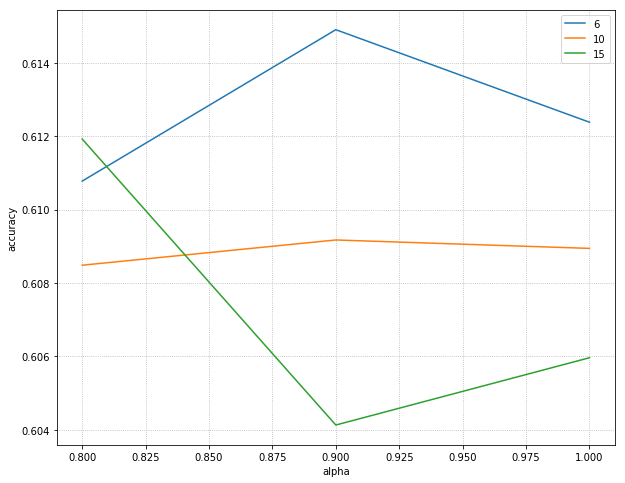

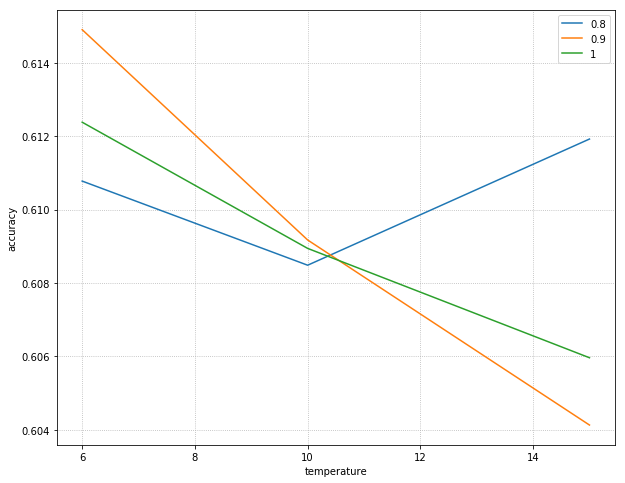

In [100]:
Ts = [6, 10, 15]
alphas = [0.8, 0.9, 1]

T_scores = defaultdict(lambda : [])
alpha_scores = defaultdict(lambda : [])

for res in all_result_parameters_small_grid:
    T_scores[res[0][0]].append([res[1], res[2], res[3]])
    alpha_scores[res[0][1]].append([res[1], res[2], res[3]])
    
    
plt.figure(figsize=(10, 8))
for T in T_scores.keys():
    plt.plot(alphas, np.array(T_scores[T])[:,2], label=str(T))
    
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.legend()
plt.show();

plt.figure(figsize=(10, 8))
for alpha in alpha_scores.keys():
    plt.plot(Ts, np.array(alpha_scores[alpha])[:,2], label=str(alpha))
    
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.legend()
plt.show();